# UCS1818: Project Work

## Group: D10

## Project Guide: 
- Dr. D. Thenmozhi

## Team Members:
- Lakshmi Priya B (185001083)
- Nivedhitha D (185001104)
- Sakthi Sairaj (185001134)

## DEMONSTRATION

## Braille-to-Text Convertor with Audio Support

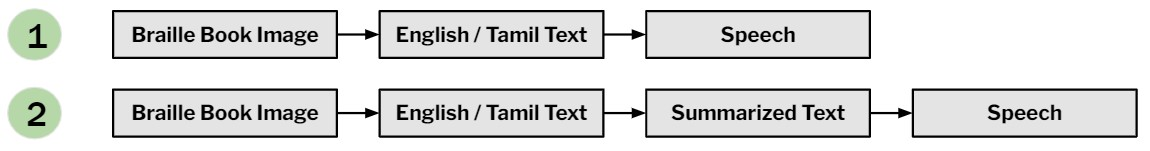

### Overview

1. [MODULE 1: Image Tilt Correction](#MODULE-1:-Image-Tilt-Correction)
2. [MODULE 2: Braille Cell Segmentation](#MODULE-2:-Braille-Cell-Segmentation)
3. [MODULE 3: CNN (DenseNet121) Braille Cell Classifier](#MODULE-3:-CNN-(DenseNet121)-Braille-Cell-Classifier)
4. [MODULE 4: Braille Recognition using Predictions from Classifier](#MODULE-4:-Braille-Recognition-using-Predictions-from-Classifier)
5. [MODULE 5: Text Correction](#MODULE-5:-Text-Correction)
6. [MODULE 6: Text Summarization](#MODULE-6:-Text-Summarization)
7. [MODULE 7: Text to Speech](#MODULE-7:-Text-to-Speech)
8. [Performance Analysis](#Performance-Analysis)

### Flow diagram of Proposed System
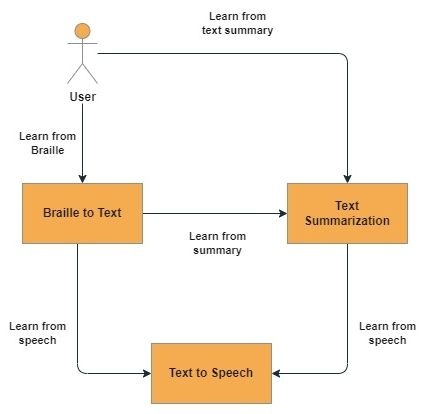

### Architecture of the Proposed System
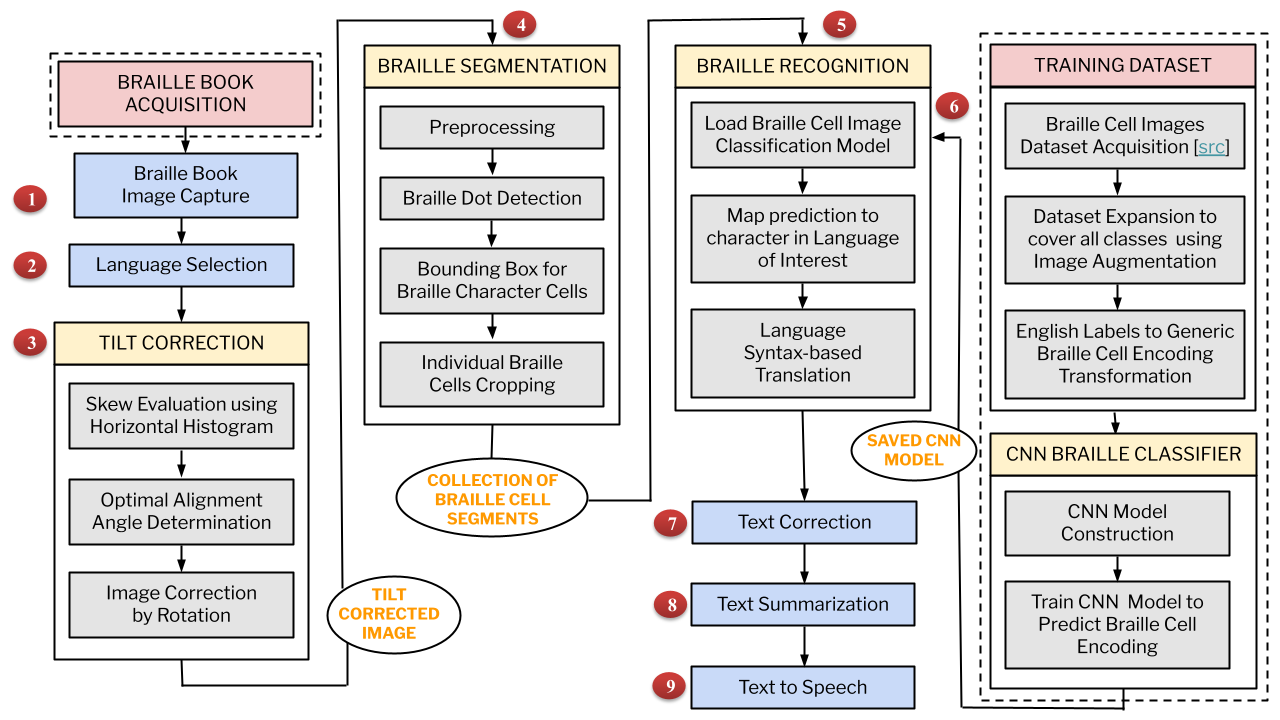

## MODULE 1: Image Tilt Correction

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
img_path = "tilt1.jpeg"

In [3]:
# Rotates an image
def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    mean_pixel = np.median(np.median(image, axis=0), axis=0)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=mean_pixel)
    return result

# Returns a small value if the horizontal histogram is sharp.
# Returns a large value if the horizontal histogram is blurry.
def eval_image(image: np.ndarray) -> float:
    hist = np.sum(np.mean(image, axis=1), axis=1)
    bef = 0
    aft = 0
    err = 0.
    assert(hist.shape[0] > 0)
    for pos in range(hist.shape[0]):
        if pos == aft:
            bef = pos
            while aft + 1 < hist.shape[0] and abs(hist[aft + 1] - hist[pos]) >= abs(hist[aft] - hist[pos]):
                aft += 1
        err += min(abs(hist[bef] - hist[pos]), abs(hist[aft] - hist[pos]))
    assert(err > 0)
    return err

# Measures horizontal histogram sharpness across many angles
def sweep_angles(image: np.ndarray) -> np.ndarray:
    results = np.empty((81, 2))
    for i in range(81):
        angle = (i - results.shape[0] // 2) / 4.
        rotated = rotate_image(image, angle)
        err = eval_image(rotated)
        results[i, 0] = angle
        results[i, 1] = err
    return results

# Find an angle that is a lot better than its neighbors
def find_alignment_angle(image: np.ndarray) -> float:
    best_gain = 0
    best_angle = 0.
    results = sweep_angles(image)
    for i in range(2, results.shape[0] - 2):
        ave = np.mean(results[i-2:i+3, 1])
        gain = ave - results[i, 1]
        # print('angle=' + str(results[i, 0]) + ', gain=' + str(gain))
        if gain > best_gain:
            best_gain = gain
            best_angle = results[i, 0]
    return best_angle

# input: an image that needs aligning
# output: the aligned image
def align_image(image: np.ndarray) -> np.ndarray:
    angle = find_alignment_angle(image)
    return rotate_image(image, angle)

[BEFORE]


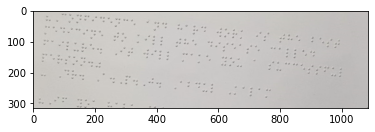

[AFTER DE-SKEWING]


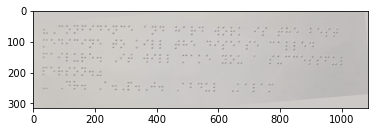

In [4]:
# Read in the image
image = cv2.imread(img_path)

# Print the Tilted or de-skewed image
print(f'[BEFORE]')
plt.imshow(image)
plt.show()

# Fixed the tilt by calling the above function
fixed = align_image(image)

# Print the de-skewed image and save it in the same directory as the image
print(f'[AFTER DE-SKEWING]')
plt.imshow(fixed)
plt.savefig('image-fixed.png')
plt.show()

## MODULE 2: Braille Cell Segmentation

In [5]:
class BrailleCharacter(object):
    def __init__(self, dot_coordinates, diameter, radius, parent_image):
        self.left = None
        self.right = None
        self.top = None
        self.bottom = None
        self.dot_coordinates = dot_coordinates
        self.diameter = diameter
        self.radius = radius
        self.parent_image = parent_image
        return;

    def mark(self):
        self.parent_image.bound_box(self.left,self.right,self.top,self.bottom)
        return;

    def get_parent_image(self):
        return self.parent_image

    def get_dot_diameter(self):
        return self.diameter

    def get_dot_radius(self):
        return self.radius

    def get_dot_coordinates(self):
        return self.dot_coordinates

    def get_left(self):
        return self.left

    def get_right(self):
        return self.right

    def get_top(self):
        return self.top

    def get_bottom(self):
        return self.bottom

    def get_opencv_left_top(self):
        return (self.left, self.top)
        
    def get_opencv_right_bottom(self):
        return (self.right, self.bottom)

    def get_bounding_box(self, form = "left,right,top,bottom"):
        r = []
        form = form.split(',')
        if len(form) < 4:
            return (self.left,self.right,self.top,self.bottom)

        for direction in form:
            direction = direction.lower()
            if direction == 'left':
                r.append(self.left)
            elif direction == 'right':
                r.append(self.right)
            elif direction == 'top':
                r.append(self.top)
            elif direction == 'bottom':
                r.append(self.bottom)
            else:
                return (self.left,self.right,self.top,self.bottom)
        
        return tuple(r)

    def is_valid(self):
        r = True
        r = r and (self.left is not None)
        r = r and (self.right is not None)
        r = r and (self.top is not None)
        r = r and (self.bottom is not None)
        return r

In [6]:
import cv2
import numpy as np

class BrailleImage(object): 
    def __init__(self, image_path=None, image=None):
        # Read source image
        if image_path != None:
          self.original = cv2.imread(image_path)
        else:
          self.original = image
          
        if self.original is None:
            raise IOError('Cannot open given image')

        # First Layer, Convert BGR(Blue Green Red Scale) to Gray Scale
        gray = cv2.cvtColor(self.original, cv2.COLOR_BGR2GRAY)
        
        # Save the binary image of the edge detected 
        self.edged_binary_image = self.__get_edged_binary_image(gray)

        # Now do the same to save a binary image to get the contents
        # inside the edges to see if the dot is really filled.
        self.binary_image = self.__get_binary_image(gray)
        self.final = self.original.copy()
        self.height, self.width, self.channels = self.original.shape
        return;

    def bound_box(self,left,right,top,bottom,color= (255,0,0), size=1):
        self.final = cv2.rectangle(self.final, (left, top), (right, bottom), color, size)
        display(self.final)
        return True

    def get_final_image(self):
        display(self.final)
        return self.final

    def get_original_image(self):
        return self.original

    def get_edged_binary_image(self):
        return self.edged_binary_image

    def get_binary_image(self):
        return self.binary_image

    def get_height(self):
        return self.height

    def get_width(self):
        return self.width

    def __get_edged_binary_image(self, gray):
        # First Lvl Blur to Reduce Noise
        blur = cv2.GaussianBlur(gray,(3,3),0)
        # Adaptive Thresholding to define the  dots in Braille
        thres = cv2.adaptiveThreshold(
                blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,4) 
        # Remove more Noise from the edges.
        blur2 = cv2.medianBlur(thres,3)
        # Sharpen again.
        ret2,th2 = cv2.threshold(blur2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # Remove more Noise.
        blur3 = cv2.GaussianBlur(th2,(3,3),0)
        # Final threshold
        ret3,th3 = cv2.threshold(blur3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        display(thres)
        return cv2.bitwise_not(th3)

    def __get_binary_image(self, gray):
        blur     = cv2.GaussianBlur(gray,(3,3),0)
        ret2,th2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        blur2    = cv2.medianBlur(th2,3)
        ret3,th3 = cv2.threshold(blur2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return cv2.bitwise_not(th3)

In [7]:
import cv2
import numpy as np
from math import sqrt
from collections import Counter
import sys


class SegmentationEngine(object): 
    def __init__(self, image = None):
        self.image = image
        self.initialized = False
        self.dots = []
        self.diameter = 0.0
        self.radius = 0.0
        self.next_epoch = 0
        self.characters = []
        self.xmin = sys.maxsize
        self.xmax = 0
        self.ymax = 0
        self.ymin = sys.maxsize
        self.w = 0
        self.h = 0
        return;

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if not self.initialized:
            self.initialized = True
            contours = self.__process_contours()
            if len(contours) == 0:
                # Since we have no dots.
                #self.__clear()
                raise StopIteration()
            enclosingCircles = self.__get_min_enclosing_circles(contours)
            if len(enclosingCircles) == 0:
                #self.__clear()
                raise StopIteration()

            diameter,dots,radius = self.__get_valid_dots(enclosingCircles)
            if len(dots) == 0:
                #self.__clear()
                raise StopIteration()
            self.diameter = diameter
            self.dots = dots
            self.radius = radius
            self.next_epoch = 0
            self.characters = []

        if len(self.characters) > 0:
            r = self.characters[0]
            del self.characters[0]
            return r

        cor = self.__get_row_cor(self.dots, epoch=self.next_epoch) # do not respect breakpoints
        if cor is None:
            #self.__clear()
            raise StopIteration()

        top = int(cor[1] - int(self.radius*1.5)) # y coordinate
        self.next_epoch = int(cor[1] + self.radius)

        cor = self.__get_row_cor(self.dots,self.next_epoch,self.diameter,True)
        if cor is None:
            # Assume next epoch
            self.next_epoch = int(self.next_epoch + (2*self.diameter))
        else:
            self.next_epoch = int(cor[1] + self.radius)

        cor = self.__get_row_cor(self.dots,self.next_epoch,self.diameter,True)
        if cor is None:
            self.next_epoch = int(self.next_epoch + (2*self.diameter))
        else:
            self.next_epoch = int(cor[1] + self.radius)
        
        bottom = self.next_epoch
        self.next_epoch += int(2*self.diameter)

        DOI = self.__get_dots_from_region(self.dots, top, bottom)
        xnextEpoch = 0
        while True:
            xcor = self.__get_col_cor(DOI, xnextEpoch)
            if xcor is None:
                break

            left = int(xcor[0] - self.radius) # x coordinate
            xnextEpoch = int(xcor[0] + self.radius)
            xcor = self.__get_col_cor(DOI,xnextEpoch,self.diameter,True)
            if xcor is None:
                # Assumed
                xnextEpoch += int(self.diameter*1.5)
            else:
                xnextEpoch = int(xcor[0]) + int(self.radius)
            right = xnextEpoch
            box = (left, right, top, bottom)
            dts = self.__get_dots_from_box(DOI, box)
            char = BrailleCharacter(dts, self.diameter, self.radius, self.image)
            
            char.left = left
            char.right = right
            char.top = top
            char.bottom = bottom

            
            self.w = max(self.w, abs(char.right - char.left))
            self.h = max(self.h, abs(char.bottom -  char.top))
            self.characters.append(char)

        if len(self.characters) < 1:
            self.__clear()
            raise StopIteration()

        r = self.characters[0]
        del self.characters[0]
        return r

    def __clear(self):
        self.image = None
        self.initialized = False
        self.dots = []
        self.diameter = 0.0
        self.radius = 0.0
        self.next_epoch = 0
        self.characters = []

    def update(self, image):
        self.__clear()
        self.image = image
        return True
    def get_attributes(self):
      return self.xmin, self.xmax, self.ymin, self.ymax, self.w, self.h

    def __get_row_cor(self, dots, epoch = 0, diameter = 0, respectBreakpoint = False):
        if len(dots) == 0:
            return None
        minDot = None
        for dot in dots:
            x,y = dot[0]
            if y < epoch:
                continue

            if minDot is None:
                minDot = dot
            else:
                v = int(y - epoch)
                minV = int(minDot[0][1] - epoch)
                if minV > v:
                    minDot = dot
                else:
                    continue
        if minDot is None:
            return None
        if respectBreakpoint:
            v = int(minDot[0][1] - epoch)
            if v > (2*diameter):
                return None # indicates that the entire row is not set
        return minDot[0] # (X,Y)

    def __get_col_cor(self, dots, epoch = 0, diameter = 0, respectBreakpoint = False):
        if len(dots) == 0:
            return None
        minDot = None
        for dot in dots:
            x,y = dot[0]
            if x < epoch:
                continue

            if minDot is None:
                minDot = dot
            else:
                v = int(x - epoch)
                minV = int(minDot[0][0] - epoch)
                if minV > v:
                    minDot = dot
                else:
                    continue
        if minDot is None:
            return None
        if respectBreakpoint:
            v = int(minDot[0][0] - epoch)
            if v > (2*diameter):
                return None # indicates that the entire row is not set
        return minDot[0] # (X,Y)

    def __get_dots_from_box(self, dots, box):
        left,right,top,bottom = box
        result = []
        for dot in dots:
            x,y = dot[0]
            if x >= left and x <= right and y >= top and y <= bottom:
                result.append(dot)
        return result

    def __get_dots_from_region(self, dots, y1, y2):
        D = []
        if y2 < y1:
            return D

        for dot in dots:
            x,y = dot[0]
            if y > y1 and y < y2:
                D.append(dot)
        return D

    def __get_valid_dots(self, circles):
        tolerance = 0.45
        radii = []
        consider = []
        bin_img = self.image.get_binary_image()
        for circle in circles:
            x,y = circle[0]
            rad = circle[1]
            # OpenCV uses row major
            # Since we do a bitwise not, white pixels belong to the dot.
            
            # Go through the x axis and check if all those are white
            # pixels till you reach the rad
            it = 0
            while it < int(rad):
                if bin_img[y,x+it] > 0 and bin_img[y+it,x] > 0:
                    it += 1
                else:
                    break
            else:
                if bin_img[y,x] > 0:
                    consider.append(circle)
                    radii.append(rad)
        
        print(len(radii))
        baserad = Counter(radii).most_common(1)[0][0]
        dots = []
        for circle in consider:
            x,y = circle[0]
            rad = circle[1]
            if rad <= int(baserad * (1+tolerance)) and rad >= int(baserad * (1-tolerance)):
                dots.append(circle)

        # Remove duplicate enclosing circles
        # (i.e) Remove circle enclosed by another other circle.
        for dot in dots:
            X1,Y1 = dot[0]
            C1 = dot[1]
            for sdot in dots:
                if dot == sdot:
                    continue
                X2,Y2 = sdot[0]
                C2 = sdot[1]
                D = sqrt(((X2 - X1)**2) + ((Y2-Y1)**2))
                if C1 > (D + C2):
                    dots.remove(sdot)
        
        # Filtered base radius
        radii = []
        for dot in dots:
            rad = dot[1]
            x, y = dot[0]
            self.ymax = max(self.ymax, y)
            self.xmax = max(self.xmax, x)
            self.ymin = min(self.ymin, y)
            self.xmin = min(self.xmin, x)

            radii.append(rad)
        baserad = Counter(radii).most_common(1)[0][0] 
        return 2*(baserad), dots, baserad
            
    def __get_min_enclosing_circles(self, contours):
        circles = []
        radii = []
        for contour in contours:
            (x,y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            radii.append(radius)
            circles.append((center, radius))
        return circles

    def __process_contours(self):
        edg_bin_img = self.image.get_edged_binary_image()
        contours = cv2.findContours(edg_bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #print(contours)
        if len(contours) == 2:
            contours = contours[0]
        else:
            contours = contours[1]
        return contours

In [8]:
  from matplotlib.patches import Rectangle
  def show_dots(image, dots, chars):
    fig = plt.figure()
    plt.rcParams['axes.grid'] = False
    plt.rcParams['axes.spines.left'] = False
    plt.axis('off')
    plt.imshow(image)
    for dot in dots:
      x, y = dot[0]
      plt.plot(x, y, "ro", markersize=0.5)
    for char in chars:
      plt.gca().add_patch(Rectangle((char.left, char.top), char.right-char.left, char.bottom-char.top,linewidth=0.5,edgecolor='g',facecolor='none'))
    plt.show()

In [9]:
def line_parameters(image):
    boxes = []
    engine = SegmentationEngine(BrailleImage(image=image))
    for char in engine:
      boxes.append(char)
    
    inter_width = sys.maxsize
    inter_height = sys.maxsize
    #print(engine.diameter)
    a, b, c, d, w, h = engine.get_attributes()
    #print(a, b, c, d, w, h)


    for i in range(len(boxes)):
      for j in range(i+1, len(boxes)):
        if boxes[i].top < boxes[j].bottom and boxes[j].bottom - boxes[i].top >= w:
          inter_height = min(inter_height, boxes[j].bottom - boxes[i].top)
        elif boxes[j].top < boxes[i].bottom and boxes[i].bottom - boxes[j].top >= w:
          inter_height = min(inter_height, boxes[i].bottom - boxes[j].top)
        if boxes[i].right < boxes[j].left and boxes[j].left - boxes[i].right >= 2*engine.diameter:
          inter_width = min(inter_width, boxes[j].left - boxes[i].right)
        elif boxes[j].right < boxes[i].left and boxes[i].left - boxes[j].right >= 2*engine.diameter:
          inter_width = min(inter_width, boxes[i].left - boxes[j].right)

    height, width = image.shape[:2]
    #print(width, height)
    #print("inter width: ", inter_width, "inter height: ", inter_height)
    w_new = w + inter_width
    h_new = h + inter_height
    #print("new: ", w, h, inter_width, inter_height)

    return w_new

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

961


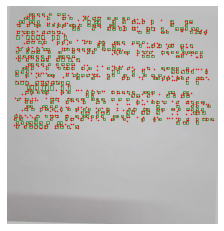

4
28 854 31 507 13 20
inter width:  8 inter height:  14
height, h, width, w: 


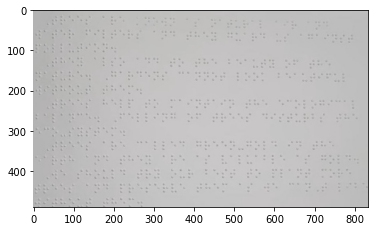

490 20 834 13


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

847


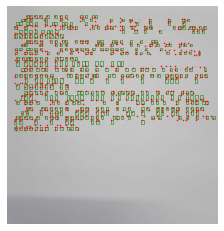

4
30 854 40 513 13 21
834 490
inter width:  8 inter height:  13
new:  13 21 8 13
lines:  14 chars:  40


In [10]:
import math
from PIL import Image

def get_parameters(img_path):
    boxes = []
    initial = cv2.imread(img_path)

    # Fixed the tilt by calling the above function
    fixed = align_image(initial)
    im = Image.fromarray(fixed)
    im.save("fixed.jpeg")

    engine = SegmentationEngine(BrailleImage('fixed.jpeg'))
    image = cv2.imread('fixed.jpeg')
    for char in engine:
      boxes.append(char)
    show_dots(image, engine.dots, boxes)
    inter_width = sys.maxsize
    inter_height = sys.maxsize
    print(engine.diameter)
    a, b, c, d, w, h = engine.get_attributes()
    print(a, b, c, d, w, h)


    for i in range(len(boxes)):
      for j in range(i+1, len(boxes)):
        if boxes[i].top < boxes[j].bottom and boxes[j].bottom - boxes[i].top >= w:
          inter_height = min(inter_height, boxes[j].bottom - boxes[i].top)
        elif boxes[j].top < boxes[i].bottom and boxes[i].bottom - boxes[j].top >= w:
          inter_height = min(inter_height, boxes[i].bottom - boxes[j].top)
        if boxes[i].right < boxes[j].left and boxes[j].left - boxes[i].right >= 2*engine.diameter:
          inter_width = min(inter_width, boxes[j].left - boxes[i].right)
        elif boxes[j].right < boxes[i].left and boxes[i].left - boxes[j].right >= 2*engine.diameter:
          inter_width = min(inter_width, boxes[i].left - boxes[j].right)

    
    
    print("inter width: ", inter_width, "inter height: ", inter_height)
    w_new = w + inter_width
    h_new = h + inter_height
    print("height, h, width, w: ")
    

    cropped = initial[max(0, c-inter_height//2):d+inter_height//2, max(0, a-inter_width//2):b+inter_width//2] 

    plt.imshow(cropped)
    plt.show()
    # cr = cropped[h_new:2*h_new, 2*w_new:3*w_new]
    # plt.imshow(cr)
    # plt.show()
    height, width = cropped.shape[:2]
    n_lines = round((height)/h_new)
    chars = round((width)/w_new)
    print(height, h, width, w)

    boxes = []
    engine = SegmentationEngine(BrailleImage(img_path))
    image = cv2.imread(img_path)
    for char in engine:
      boxes.append(char)
    show_dots(image, engine.dots, boxes)
    inter_width = sys.maxsize
    inter_height = sys.maxsize
    print(engine.diameter)
    a, b, c, d, w, h = engine.get_attributes()
    print(a, b, c, d, w, h)


    for i in range(len(boxes)):
      for j in range(i+1, len(boxes)):
        if boxes[i].top < boxes[j].bottom and boxes[j].bottom - boxes[i].top >= w:
          inter_height = min(inter_height, boxes[j].bottom - boxes[i].top)
        elif boxes[j].top < boxes[i].bottom and boxes[i].bottom - boxes[j].top >= w:
          inter_height = min(inter_height, boxes[i].bottom - boxes[j].top)
        if boxes[i].right < boxes[j].left and boxes[j].left - boxes[i].right >= 2*engine.diameter:
          inter_width = min(inter_width, boxes[j].left - boxes[i].right)
        elif boxes[j].right < boxes[i].left and boxes[i].left - boxes[j].right >= 2*engine.diameter:
          inter_width = min(inter_width, boxes[i].left - boxes[j].right)

    height, width = cropped.shape[:2]
    print(width, height)
    print("inter width: ", inter_width, "inter height: ", inter_height)
    w_new = w + inter_width
    h_new = h + inter_height
    n_lines = min(n_lines, round((height)/h_new))
    chars = min(chars, round((width)/w_new))
    print("new: ", w, h, inter_width, inter_height)
    cropped = initial[max(0, c-inter_height//2):d+inter_height//2, max(0, a-inter_width//2):b+inter_width//2] 


    return n_lines, chars, cropped


n_line, chars, cropped = get_parameters("page2.jpeg")
print("lines: ", n_line, "chars: ", chars)

## MODULE 3: CNN (DenseNet121) Braille Cell Classifier

Link to [DENSENET121 Notebook](01-Transfer-Learning-Densenet121-01.ipynb)

### Architecture Layers
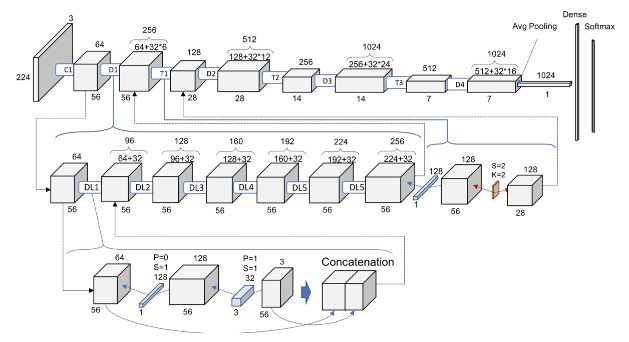

### Model Summary
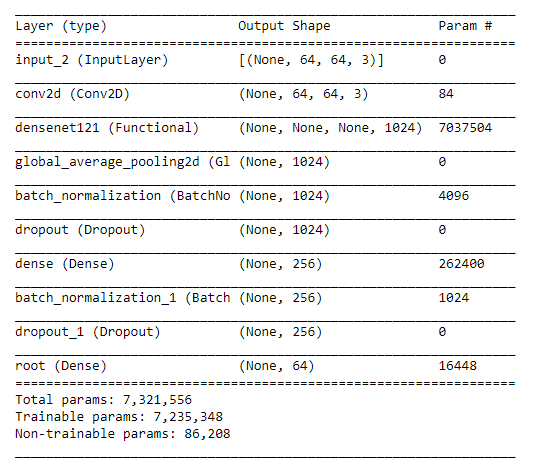

### Final Loss & Accuracy Post-training
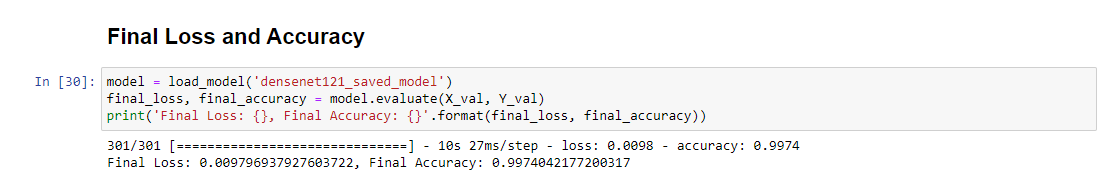

### Loss Curves
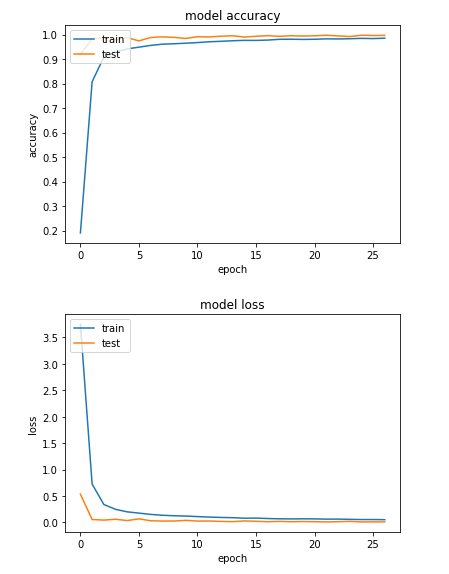

## MODULE 4: Braille Recognition using Predictions from Classifier

In [11]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import DenseNet121

from PIL import Image
import torch

from glob import glob

In [12]:
ImagePATH = "dataset"
categories = glob(ImagePATH+"*")

In [13]:
filedf = pd.DataFrame()
for cat in categories:
    files = glob(cat+"/*")
    tempdf = pd.DataFrame({'filepath':files,'category':cat.split("\\")[-1]})
    filedf = pd.concat([filedf,tempdf])

In [15]:
gby_cnt = filedf.groupby("category").aggregate('count').rename(columns = {'filepath':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)
print(gby_cnt)
print(np.array(gby_cnt['category']))
print(np.array(gby_cnt['cnt']))

  category  cnt
0  dataset   64
['dataset']
[64]


In [16]:
braille_cell_encoding_class= list(gby_cnt['category'])
data_dir = 'dataset'

In [17]:
braille_cell_encoding_class = ['dataset/0', 'dataset/1', 'dataset/23', 'dataset/234', 'dataset/2345', 'dataset/23456', 'dataset/2346', 'dataset/235', 'dataset/2356', 'dataset/236', 'dataset/24', 'dataset/245', 'dataset/2456', 'dataset/246', 'dataset/25', 'dataset/256', 'dataset/26', 'dataset/3', 'dataset/34', 'dataset/345', 'dataset/3456', 'dataset/346', 'dataset/35', 'dataset/356', 'dataset/36', 'dataset/4', 'dataset/45', 'dataset/456', 'dataset/46', 'dataset/5', 'dataset/56', 'dataset/2', 'dataset/16', 'dataset/156', 'dataset/125', 'dataset/12', 'dataset/123', 'dataset/1234', 'dataset/12345', 'dataset/123456', 'dataset/12346', 'dataset/1235', 'dataset/12356', 'dataset/1236', 'dataset/124', 'dataset/1245', 'dataset/12456', 'dataset/1246', 'dataset/1256', 'dataset/15', 'dataset/126', 'dataset/13', 'dataset/134', 'dataset/1345', 'dataset/13456', 'dataset/1346', 'dataset/135', 'dataset/1356', 'dataset/136', 'dataset/14', 'dataset/145', 'dataset/1456', 'dataset/146', 'dataset/6']

In [18]:
for i in range(len(braille_cell_encoding_class)):
  braille_cell_encoding_class[i] = braille_cell_encoding_class[i][8:]

In [19]:
print(braille_cell_encoding_class)

['0', '1', '23', '234', '2345', '23456', '2346', '235', '2356', '236', '24', '245', '2456', '246', '25', '256', '26', '3', '34', '345', '3456', '346', '35', '356', '36', '4', '45', '456', '46', '5', '56', '2', '16', '156', '125', '12', '123', '1234', '12345', '123456', '12346', '1235', '12356', '1236', '124', '1245', '12456', '1246', '1256', '15', '126', '13', '134', '1345', '13456', '1346', '135', '1356', '136', '14', '145', '1456', '146', '6']


In [22]:
mapping = {
    "english" : {
        "1" : "a", "12" : "b", "14" : "c", "145" : "d", "15" : "e", 
        "124" : "f", "1245" : "g", "125" : "h", "24" : "i", "245" : "j", 
        "13" : "k", "123" : "l", "134" : "m", "1345" : "n", "135" : "o", 
        "1234" : "p", "12345" : "q", "1235" : "r", "234" : "s", "2345" : "t", 
        "136" : "u", "1236" : "v", "2456" : "w", "1346" : "x", "13456" : "y", 
        "1356" : "z", "0" : " ", "3456" : "#", "245" : ".", "2" : ",", 
        "25" : ":", "3" : "'", "36" : "-", "23" : ";", "236" : "?",
        "235" : "!", "6" : "^",
    },
    "tamil" : {        
        "1" : "அ", "345" : "ஆ", "24" : "இ", "35" : "ஈ", "136" : "உ", "1256" : "ஊ", 
        "26" : "எ", "15" : "ஏ", "34" : "ஐ", "1346" : "ஒ", "135" : "ஓ", "246" : "ஔ",
        "13" : "க", "346" : "ங", "14" : "ச", "25" : "ஞ", "2345" : "ட",  "3456" : "ண", 
        "2345" : "த", "1345" : "ந", "1234" : "ப", "134" : "ம", "13456" : "ய", "1235" : "ர",
        "123" : "ல", "1236" : "வ", "12356" : "ழ", "456" : "ள", "12456" : "ற", "56" : "ன",
        "6" : "ஃ", "245" : "ஜ", "146" : "ஶ", "12346" : "ஷ", "234" : "ஸ", "125" : "ஹ",
        "12345" : "க்ஷ்", "4" : "^", "256" : ".", "0" : " ", 
    }
}

symbols = ['0', '1', '2', '3', '4', '5', '6', '12', '13', '14', 
           '15', '16', '23', '24', '25', '26', '34', '35', '36', 
           '45', '46', '56', '123', '124', '125', '126', '134', 
           '135', '136', '145', '146', '156', '234', '235', '236', 
           '245', '246', '256', '345', '346', '356', '456', '1234',
           '1235', '1236', '1245', '1246', '1256', '1345', '1346',
           '1356', '1456', '2345', '2346', '2356', '2456', '3456',
           '12345', '12346', '12356', '12456', '13456', '23456', 
           '123456']

tamil_syntax = {
    "^க" : "க்", "கஆ" : "கா", "கஇ" : "கி", "கஈ" : "கீ", "கஉ" : "கு", "கஊ" : "கூ", "கஎ" : "கெ", "கஏ" : "கே", "கஐ" : "கை", "கஒ" : "கொ", "கஓ" : "கோ", "கஔ" : "கௌ",
    "^ங" : "ங்", "ஙஆ" : "ஙா", "ஙஇ" : "ஙி", "ஙஈ" : "ஙீ", "ஙஉ" : "ஙு", "ஙஊ" : "ஙூ", "ஙஎ" : "ஙெ", "ஙஏ" : "ஙே", "ஙஐ" : "ஙை", "ஙஒ" : "ஙொ", "ஙஓ" : "ஙோ", "ஙஔ" : "ஙௌ",
    "^ச" : "ச்", "சஆ" : "சா", "சஇ" : "சி", "சஈ" : "சீ", "சஉ" : "சு", "சஊ" : "சூ", "சஎ" : "செ", "சஏ" : "சே", "சஐ" : "சை", "சஒ" : "சொ", "சஓ" : "சோ", "சஔ" : "சௌ",
    "^ஞ" : "ஞ்", "ஞஆ" : "ஞா", "ஞஇ" : "ஞி", "ஞஈ" : "ஞீ", "ஞஉ" : "ஞு", "ஞஊ" : "ஞூ", "ஞஎ" : "ஞெ", "ஞஏ" : "ஞே", "ஞஐ" : "ஞை", "ஞஒ" : "ஞொ", "ஞஓ" : "ஞோ", "ஞஔ" : "ஞௌ",
    "^ட" : "ட்", "டஆ" : "டா", "டஇ" : "டி", "டஈ" : "டீ", "டஉ" : "டு", "டஊ" : "டூ", "டஎ" : "டெ", "டஏ" : "டே", "டஐ" : "டை", "டஒ" : "டொ", "டஓ" : "டோ", "டஔ" : "டௌ",
    "^ண" : "ண்", "ணஆ" : "ணா	", "ணஇ" : "ணி", "ணஈ" : "ணீ", "ணஉ" : "ணு", "ணஊ" : "ணூ", "ணஎ" : "ணெ", "ணஏ" : "ணே", "ணஐ" : "ணை	", "ணஒ" : "ணொ", "ணஓ" : "ணோ", "ணஔ" : "ணௌ",
    "^த" : "த்", "தஆ" : "தா", "தஇ" : "தி", "தஈ" : "தீ", "தஉ" : "து", "தஊ" : "தூ", "தஎ" : "தெ", "தஏ" : "தே", "தஐ" : "தை", "தஒ" : "தொ", "தஓ" : "தோ", "தஔ" : "தௌ",
    "^ந" : "ந்", "நஆ" : "நா", "நஇ" : "நி", "நஈ" : "நீ", "நஉ" : "நு", "நஊ" : "நூ", "நஎ" : "நெ", "நஏ" : "நே", "நஐ" : "நை", "நஒ" : "நொ", "நஓ" : "நோ", "நஔ" : "நௌ",
    "^ப" : "ப்", "பஆ" : "பா", "பஇ" : "பி", "பஈ" : "பீ", "பஉ" : "பு", "பஊ" : "பூ", "பஎ" : "பெ", "பஏ" : "பே", "பஐ" : "பை", "பஒ" : "பொ", "பஓ" : "போ", "பஔ" : "பௌ",
    "^ம" : "ம்", "மஆ" : "மா", "மஇ" : "மி", "மஈ" : "மீ", "மஉ" : "மு", "மஊ" : "மூ", "மஎ" : "மெ", "மஏ" : "மே", "மஐ" : "மை", "மஒ" : "மொ", "மஓ" : "மோ", "மஔ" : "மௌ",
    "^ய" : "ய்", "யஆ" : "யா", "யஇ" : "யி", "யஈ" : "யீ", "யஉ" : "யு", "யஊ" : "யூ", "யஎ" : "யெ", "யஏ" : "யே", "யஐ" : "யை", "யஒ" : "யொ", "யஓ" : "யோ", "யஔ" : "யௌ",
    "^ர" : "ர்", "ரஆ" : "ரா", "ரஇ" : "ரி", "ரஈ" : "ரீ", "ரஉ" : "ரு", "ரஊ" : "ரூ", "ரஎ" : "ரெ", "ரஏ" : "ரே", "ரஐ" : "ரை", "ரஒ" : "ரொ", "ரஓ" : "ரோ", "ரஔ" : "ரௌ",
    "^ல" : "ல்", "லஆ" : "லா", "லஇ" : "லி", "லஈ" : "லீ", "லஉ" : "லு", "லஊ" : "லூ", "லஎ" : "லெ", "லஏ" : "லே", "லஐ" : "லை", "லஒ" : "லொ", "லஓ" : "லோ", "லஔ" : "லௌ",
    "^வ" : "வ்", "வஆ" : "வா", "வஇ" : "வி", "வஈ" : "வீ", "வஉ" : "வு", "வஊ" : "வூ", "வஎ" : "வெ", "வஏ" : "வே", "வஐ" : "வை", "வஒ" : "வொ", "வஓ" : "வோ", "வஔ" : "வௌ",
    "^ழ" : "ழ்", "ழஆ" : "ழா", "ழஇ" : "ழி", "ழஈ" : "ழீ", "ழஉ" : "ழு", "ழஊ" : "ழூ", "ழஎ" : "ழெ", "ழஏ" : "ழே", "ழஐ" : "ழை", "ழஒ" : "ழொ", "ழஓ" : "ழோ", "ழஔ" : "ழௌ",
    "^ள" : "ள்", "ளஆ" : "ளா", "ளஇ" : "ளி", "ளஈ" : "ளீ", "ளஉ" : "ளு", "ளஊ" : "ளூ", "ளஎ" : "ளெ", "ளஏ" : "ளே", "ளஐ" : "ளை", "ளஒ" : "ளொ", "ளஓ" : "ளோ", "ளஔ" : "ளௌ",
    "^ற" : "ற்", "றஆ" : "றா", "றஇ" : "றி", "றஈ" : "றீ", "றஉ" : "று", "றஊ" : "றூ", "றஎ" : "றெ", "றஏ" : "றே", "றஐ" : "றை", "றஒ" : "றொ", "றஓ" : "றோ", "றஔ" : "றௌ",
    "^ன" : "ன்", "னஆ" : "னா", "னஇ" : "னி", "னஈ" : "னீ", "னஉ" : "னு", "னஊ" : "னூ", "னஎ" : "னெ", "னஏ" : "னே", "னஐ" : "னை", "னஒ" : "னொ", "னஓ" : "னோ", "னஔ" : "னௌ",
    "^ஜ" : "ஜ்", "ஜஆ" : "ஜா", "ஜஇ" : "ஜி", "ஜஈ" : "ஜீ", "ஜஉ" : "ஜு", "ஜஊ" : "ஜூ", "ஜஎ" : "ஜெ", "ஜஏ" : "ஜே", "ஜஐ" : "ஜை", "ஜஒ" : "ஜொ", "ஜஓ" : "ஜோ", "ஜஔ" : "ஜௌ",
    "^ஶ" : "ஶ்", "ஶஆ" : "ஶா", "ஶஇ" : "ஶி", "ஶஈ" : "ஶீ", "ஶஉ" : "ஶு", "ஶஊ" : "ஶூ", "ஶஎ" : "ஶெ", "ஶஏ" : "ஶே", "ஶஐ" : "ஶை", "ஶஒ" : "ஶொ", "ஶஓ" : "ஶோ", "ஶஔ" : "ஶௌ",
    "^ஷ" : "ஷ்", "ஷஆ" : "ஷா", "ஷஇ" : "ஷி", "ஷஈ" : "ஷீ", "ஷஉ" : "ஷு", "ஷஊ" : "ஷூ", "ஷஎ" : "ஷெ", "ஷஏ" : "ஷே", "ஷஐ" : "ஷை", "ஷஒ" : "ஷொ", "ஷஓ" : "ஷோ", "ஷஔ" : "ஷௌ",
    "^ஸ" : "ஸ்", "ஸஆ" : "ஸா", "ஸஇ" : "ஸி", "ஸஈ" : "ஸீ", "ஸஉ" : "ஸு", "ஸஊ" : "ஸூ", "ஸஎ" : "ஸெ", "ஸஏ" : "ஸே", "ஸஐ" : "ஸை", "ஸஒ" : "ஸொ", "ஸஓ" : "ஸோ", "ஸஔ" : "ஸௌ",
    "^ஹ" : "ஹ்", "ஹஆ" : "ஹா", "ஹஇ" : "ஹி", "ஹஈ" : "ஹீ", "ஹஉ" : "ஹு", "ஹஊ" : "ஹூ", "ஹஎ" : "ஹெ", "ஹஏ" : "ஹே", "ஹஐ" : "ஹை", "ஹஒ" : "ஹொ", "ஹஓ" : "ஹோ", "ஹஔ" : "ஹௌ",
    "^க்ஷ" : "க்ஷ", "க்ஷஆ" : "க்ஷா", "க்ஷஇ" : "க்ஷி", "க்ஷஈ" : "க்ஷீ", "க்ஷஉ" : "க்ஷு", "க்ஷஊ" : "க்ஷூ", "க்ஷஎ" : "க்ஷெ", "க்ஷஏ" : "க்ஷே", "க்ஷஐ" : "க்ஷை", "க்ஷஒ" : "க்ஷொ", "க்ஷஓ" : "க்ஷோ", "க்ஷஔ" : "க்ஷௌ",
}


In [16]:
model = load_model('densenet121_final_corrected_saved_model')

In [17]:
def predict_english(predictions):
    letters = []
    for prediction in predictions:
        if prediction in mapping["english"]:
          letters.append(mapping["english"][prediction])
          print("##", prediction, " - ", mapping["english"][prediction])
        else:
          print(f"prediction {prediction} type: {type(prediction)}")
    
    output = ""
    number = False
    capL = False
    capW = False
    for j in letters:
      if j == '#':
        number = True
      elif j == '^':
        if capL:
          capW = True
        capL = True
      elif j == ' ':
        number = False
        capL = False
        capW = False
        output = output + j
      elif not number:
        if capW and ord(j) in range(97, 123):
          output = output + chr(ord(j) - 32)
        elif capL and ord(j) in range(97, 123):
          output = output + chr(ord(j) - 32)
          capL = False
        else:
          output = output + j
      else:
        if ord(j) in range(97, 106):
          output = output + chr(ord(j)-48)
        elif ord(j) == 106:
          output = output + chr(48)
        else:
          output = output + j

    return output

In [18]:
def predict_tamil(predictions):
    letters = []
    for prediction in predictions:
        if prediction in mapping["tamil"]:
          letters.append(mapping["tamil"][prediction])
          print("##", prediction, " - ", mapping["tamil"][prediction])
        else:
          print(f"prediction {prediction} type: {type(prediction)}")

    output = ""
    
    i = 0
    while i < len(letters)-1:
        syllable = letters[i] + letters[i+1]
        if syllable in tamil_syntax:
            output += tamil_syntax[syllable]
            i +=2
        else:
            output += letters[i]
            i += 1

    return output

In [19]:
import matplotlib.pyplot as plt

def make_prediction(img_path, lang="english"):
    
    nlines, nchars, updated = get_parameters(img_path)
    
    image = Image.open(img_path)
    image = image.convert('RGB')
    height, width = updated.shape[:2]
    updated = cv2.cvtColor(updated, cv2.COLOR_BGR2RGB)
    updated = Image.fromarray(updated)

    h = height/nlines
    w = width/nchars
    
    print("width: ", width, "height: ", height, "nchars: ", nchars, "nlines: ", nlines, "w: ", w, "h: ", h)
    
    letters = []
    predictions = []
    
    for n in range(0, nlines):
        
      cropped = updated.crop((0, n * h, width, (n + 1) * h))
      crop = cv2.cvtColor(np.array(cropped), cv2.COLOR_RGB2BGR)
      w1 = line_parameters(image=crop)
      if w1 < 0.6*w:
        w1 = w
      #w1 = (w1 + w)/2
      i = 0
      img_list = []

      while w1*(i+1) <= width:

        cropped = updated.crop((i*w1, n * h, (i+1)*w1, (n + 1) * h))          
        cropped = np.array(cropped)
        x = cv2.resize(cropped, (64, 64))
        
        plt.imshow(cropped)
        plt.show()

        x = np.expand_dims(x, axis = 0)
        x = x.astype(np.float32) / 255.0

        custom = model.predict(x)
        a = custom[0]
        ind = np.argmax(a)
        print("ind: ", ind)

        print('Prediction: ', braille_cell_encoding_class[ind])

        predicted_letter = braille_cell_encoding_class[ind]
        predictions.append(predicted_letter)
        i += 1

    print(predictions, end="\n\n")
  
    output = ""
    if lang=="english":
      output = predict_english(predictions)
    elif lang=="tamil":
      output = predict_tamil(predictions)
           
    plt.imshow(image)
    plt.show()
    
    return output

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

961


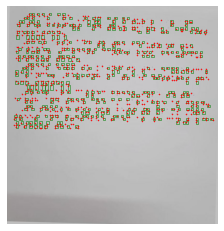

4
28 854 31 507 13 20
inter width:  8 inter height:  14
height, h, width, w: 


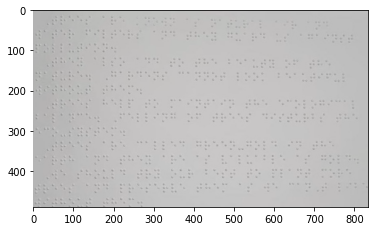

490 20 834 13


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

847


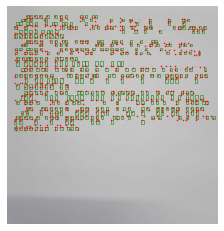

4
30 854 40 513 13 21
834 490
inter width:  8 inter height:  13
new:  13 21 8 13
width:  832 height:  485 nchars:  40 nlines:  14 w:  20.8 h:  34.642857142857146


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

76


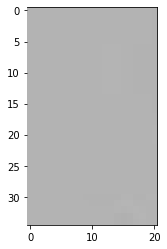

ind:  63
Prediction:  6


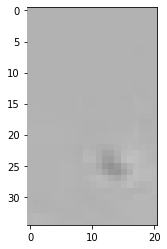

ind:  29
Prediction:  5


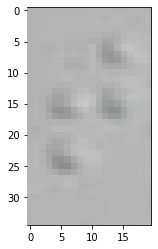

ind:  4
Prediction:  2345


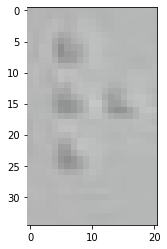

ind:  41
Prediction:  1235


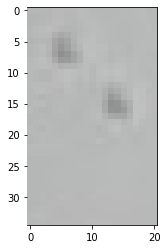

ind:  49
Prediction:  15


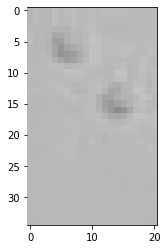

ind:  49
Prediction:  15


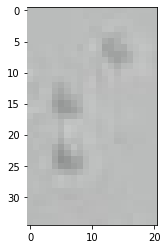

ind:  3
Prediction:  234


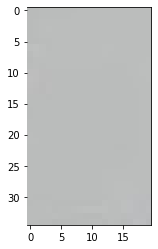

ind:  43
Prediction:  1236


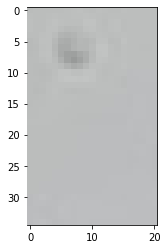

ind:  1
Prediction:  1


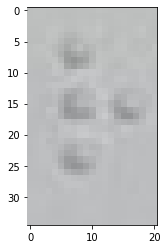

ind:  41
Prediction:  1235


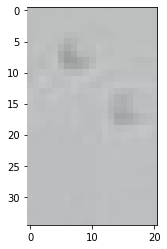

ind:  49
Prediction:  15


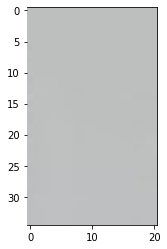

ind:  0
Prediction:  0


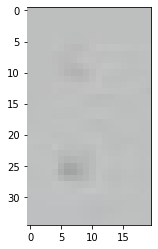

ind:  51
Prediction:  13


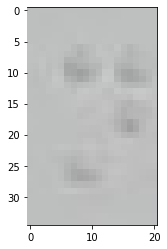

ind:  53
Prediction:  1345


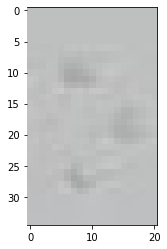

ind:  56
Prediction:  135


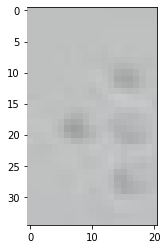

ind:  12
Prediction:  2456


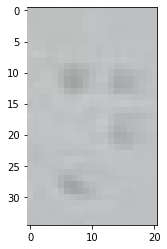

ind:  53
Prediction:  1345


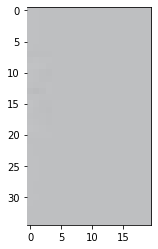

ind:  0
Prediction:  0


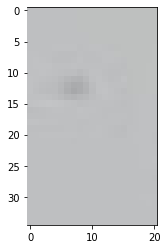

ind:  31
Prediction:  2


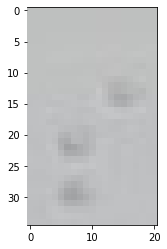

ind:  3
Prediction:  234


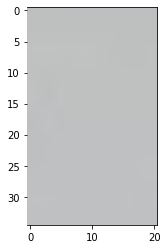

ind:  0
Prediction:  0


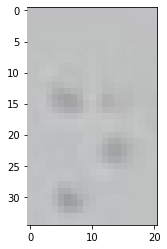

ind:  53
Prediction:  1345


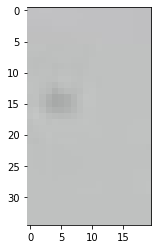

ind:  31
Prediction:  2


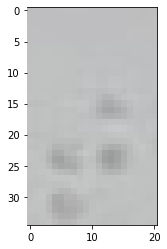

ind:  23
Prediction:  356


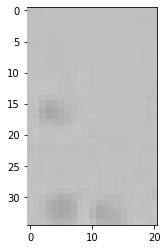

ind:  58
Prediction:  136


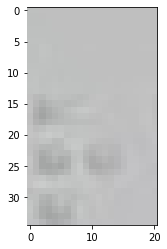

ind:  41
Prediction:  1235


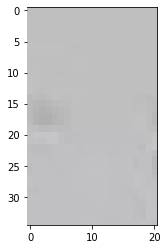

ind:  30
Prediction:  56


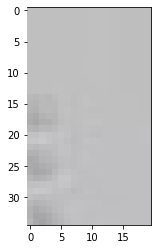

ind:  36
Prediction:  123


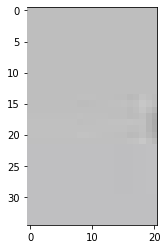

ind:  29
Prediction:  5


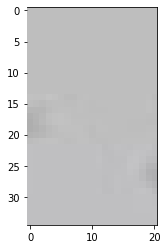

ind:  31
Prediction:  2


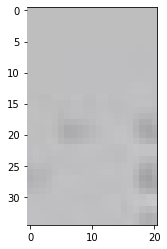

ind:  30
Prediction:  56


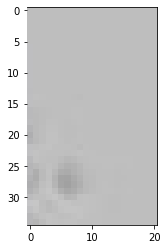

ind:  9
Prediction:  236


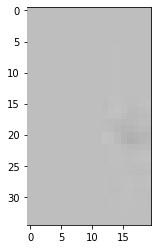

ind:  29
Prediction:  5


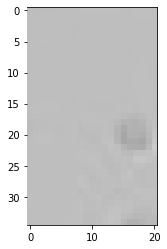

ind:  28
Prediction:  46


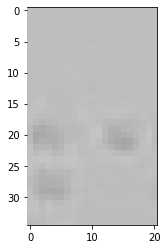

ind:  7
Prediction:  235


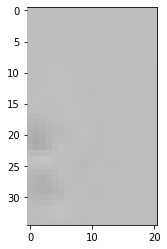

ind:  2
Prediction:  23


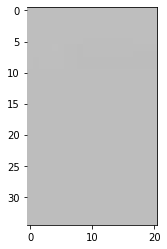

ind:  0
Prediction:  0


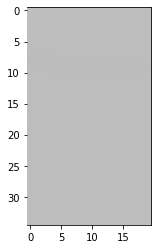

ind:  0
Prediction:  0


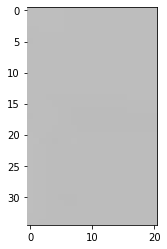

ind:  0
Prediction:  0


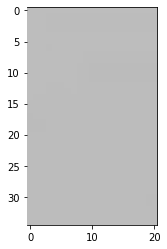

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

99


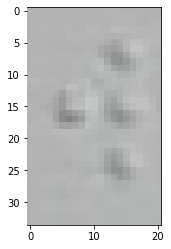

ind:  12
Prediction:  2456


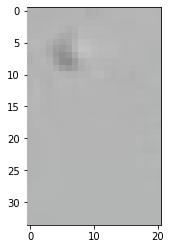

ind:  1
Prediction:  1


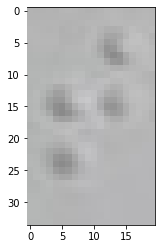

ind:  4
Prediction:  2345


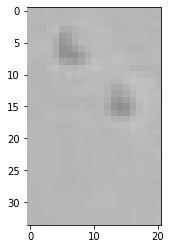

ind:  49
Prediction:  15


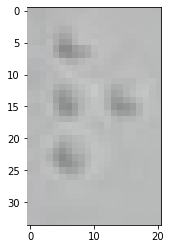

ind:  41
Prediction:  1235


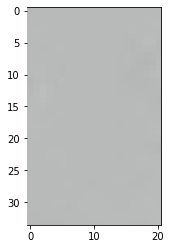

ind:  0
Prediction:  0


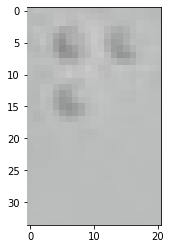

ind:  44
Prediction:  124


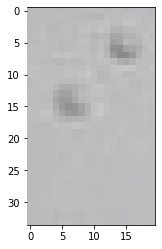

ind:  10
Prediction:  24


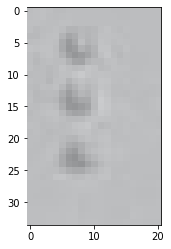

ind:  36
Prediction:  123


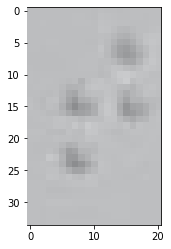

ind:  4
Prediction:  2345


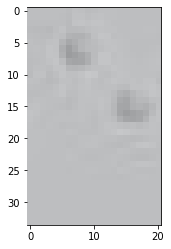

ind:  49
Prediction:  15


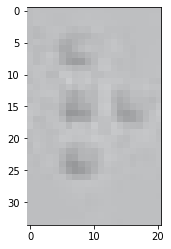

ind:  41
Prediction:  1235


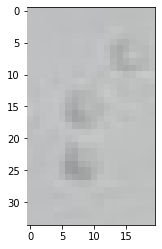

ind:  3
Prediction:  234


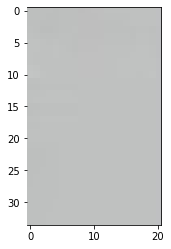

ind:  0
Prediction:  0


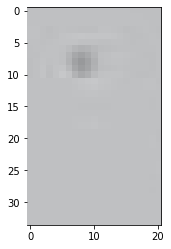

ind:  1
Prediction:  1


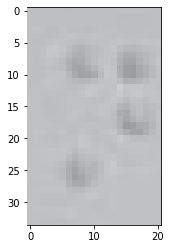

ind:  53
Prediction:  1345


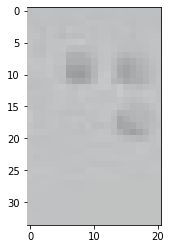

ind:  60
Prediction:  145


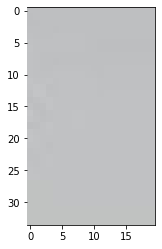

ind:  0
Prediction:  0


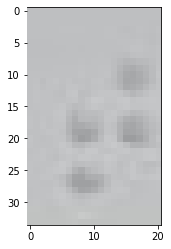

ind:  4
Prediction:  2345


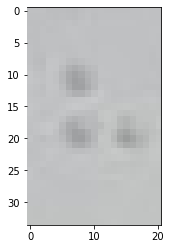

ind:  34
Prediction:  125


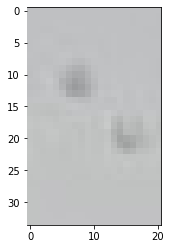

ind:  49
Prediction:  15


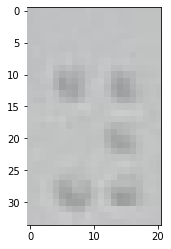

ind:  54
Prediction:  13456


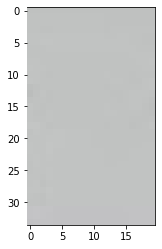

ind:  0
Prediction:  0


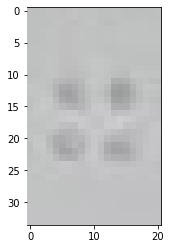

ind:  8
Prediction:  2356


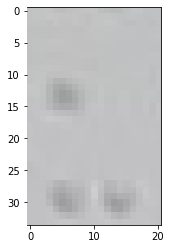

ind:  58
Prediction:  136


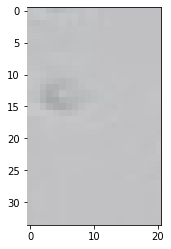

ind:  31
Prediction:  2


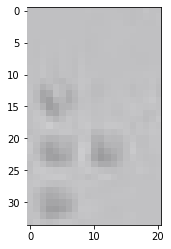

ind:  41
Prediction:  1235


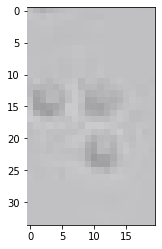

ind:  48
Prediction:  1256


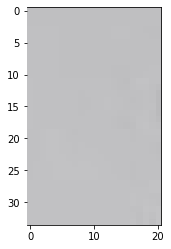

ind:  0
Prediction:  0


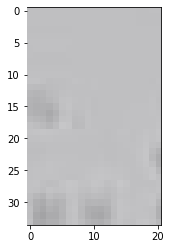

ind:  57
Prediction:  1356


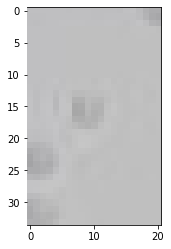

ind:  3
Prediction:  234


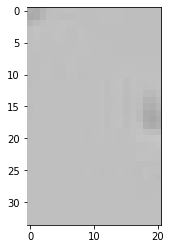

ind:  29
Prediction:  5


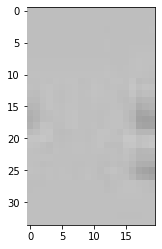

ind:  30
Prediction:  56


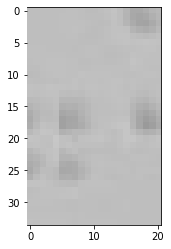

ind:  4
Prediction:  2345


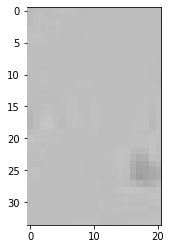

ind:  32
Prediction:  16


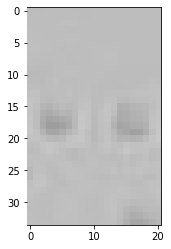

ind:  15
Prediction:  256


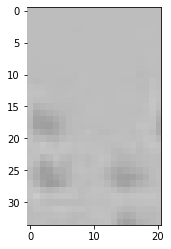

ind:  48
Prediction:  1256


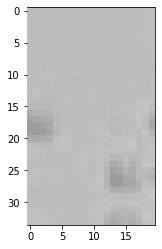

ind:  30
Prediction:  56


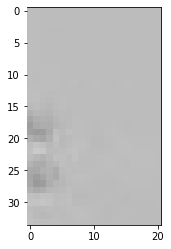

ind:  2
Prediction:  23


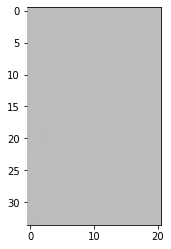

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

35


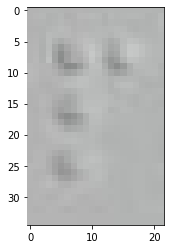

ind:  37
Prediction:  1234


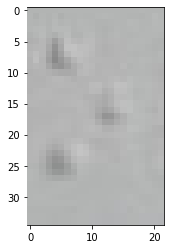

ind:  56
Prediction:  135


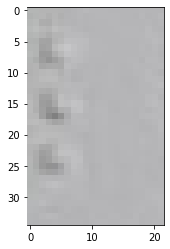

ind:  36
Prediction:  123


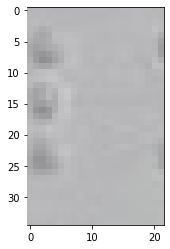

ind:  36
Prediction:  123


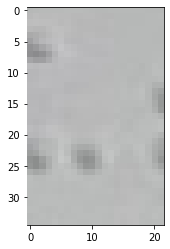

ind:  58
Prediction:  136


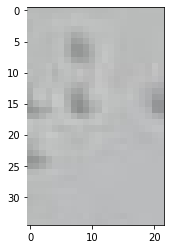

ind:  34
Prediction:  125


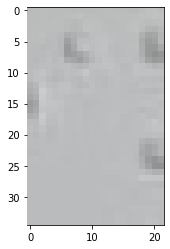

ind:  13
Prediction:  246


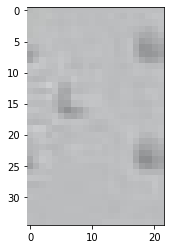

ind:  13
Prediction:  246


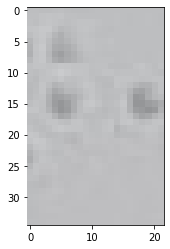

ind:  34
Prediction:  125


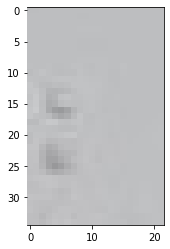

ind:  2
Prediction:  23


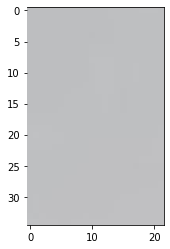

ind:  0
Prediction:  0


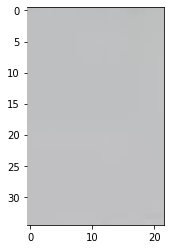

ind:  0
Prediction:  0


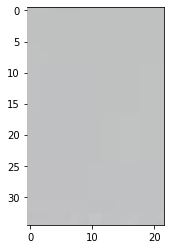

ind:  63
Prediction:  6


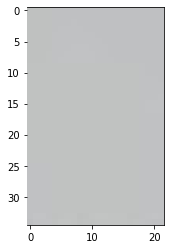

ind:  17
Prediction:  3


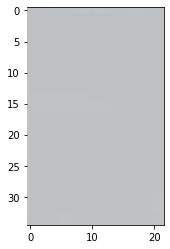

ind:  0
Prediction:  0


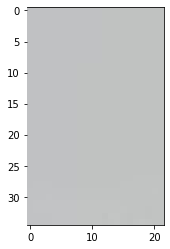

ind:  63
Prediction:  6


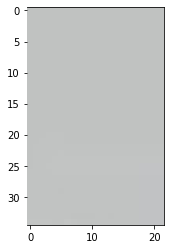

ind:  0
Prediction:  0


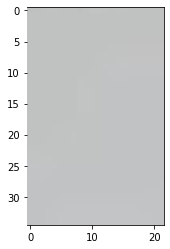

ind:  0
Prediction:  0


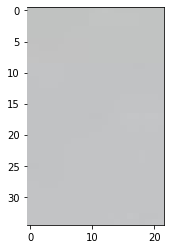

ind:  0
Prediction:  0


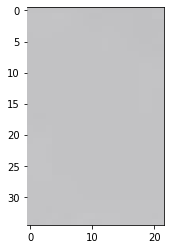

ind:  0
Prediction:  0


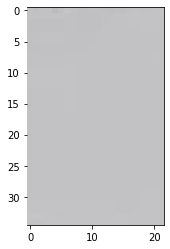

ind:  0
Prediction:  0


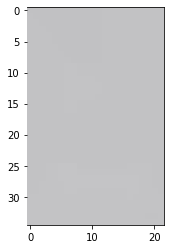

ind:  0
Prediction:  0


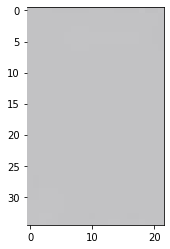

ind:  0
Prediction:  0


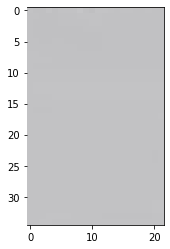

ind:  0
Prediction:  0


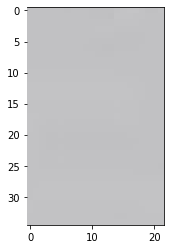

ind:  0
Prediction:  0


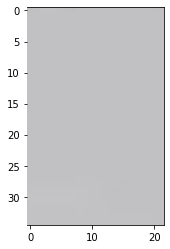

ind:  0
Prediction:  0


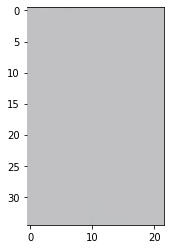

ind:  0
Prediction:  0


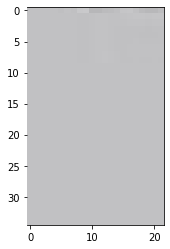

ind:  59
Prediction:  14


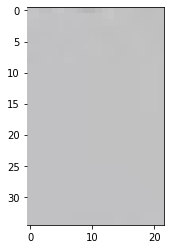

ind:  59
Prediction:  14


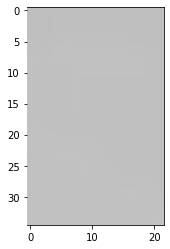

ind:  0
Prediction:  0


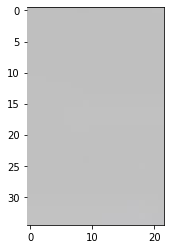

ind:  0
Prediction:  0


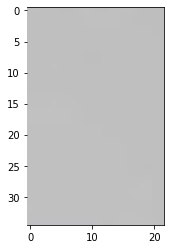

ind:  0
Prediction:  0


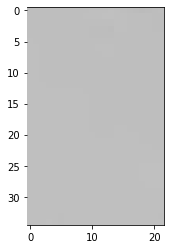

ind:  0
Prediction:  0


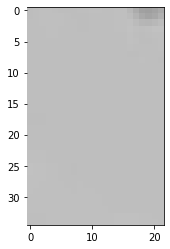

ind:  25
Prediction:  4


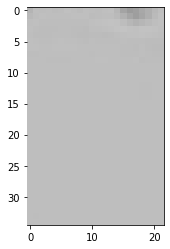

ind:  25
Prediction:  4


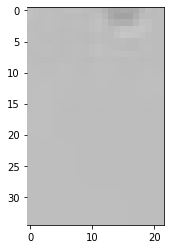

ind:  25
Prediction:  4


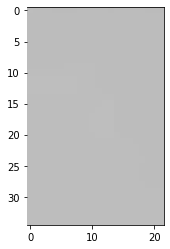

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

80


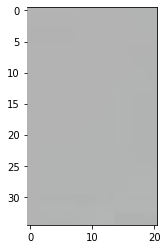

ind:  63
Prediction:  6


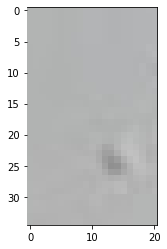

ind:  29
Prediction:  5


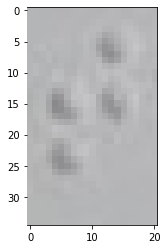

ind:  4
Prediction:  2345


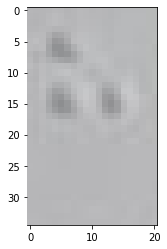

ind:  34
Prediction:  125


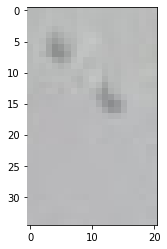

ind:  49
Prediction:  15


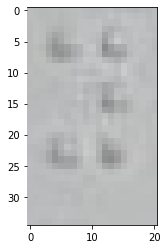

ind:  54
Prediction:  13456


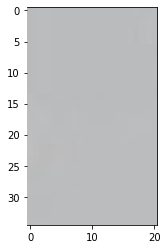

ind:  0
Prediction:  0


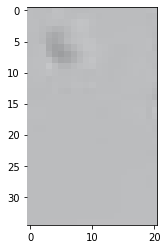

ind:  1
Prediction:  1


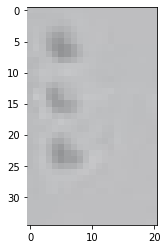

ind:  36
Prediction:  123


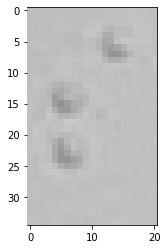

ind:  3
Prediction:  234


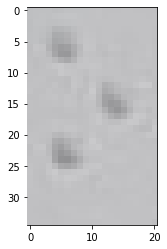

ind:  56
Prediction:  135


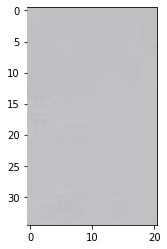

ind:  0
Prediction:  0


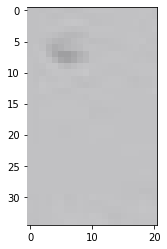

ind:  1
Prediction:  1


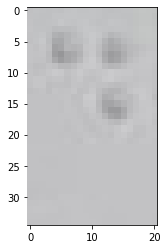

ind:  60
Prediction:  145


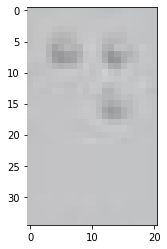

ind:  60
Prediction:  145


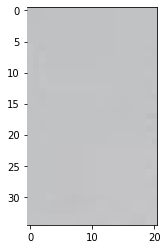

ind:  0
Prediction:  0


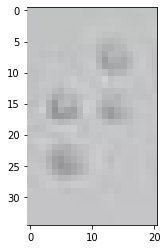

ind:  4
Prediction:  2345


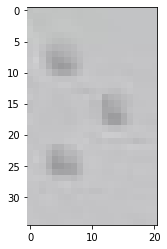

ind:  56
Prediction:  135


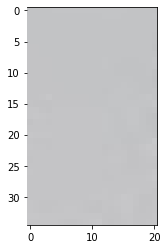

ind:  0
Prediction:  0


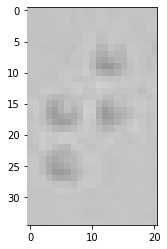

ind:  4
Prediction:  2345


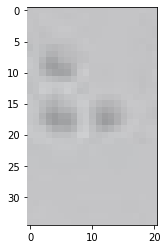

ind:  34
Prediction:  125


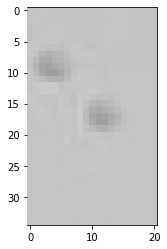

ind:  49
Prediction:  15


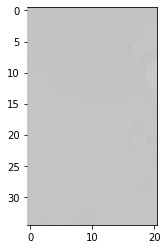

ind:  0
Prediction:  0


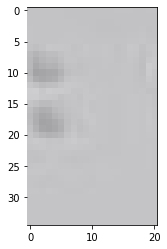

ind:  35
Prediction:  12


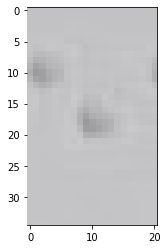

ind:  49
Prediction:  15


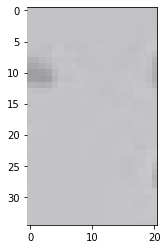

ind:  31
Prediction:  2


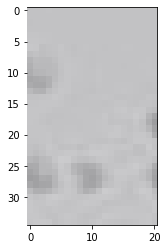

ind:  57
Prediction:  1356


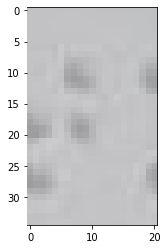

ind:  7
Prediction:  235


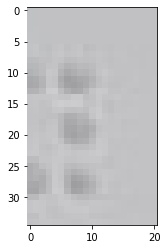

ind:  54
Prediction:  13456


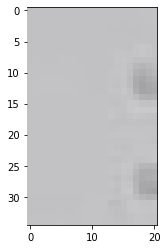

ind:  28
Prediction:  46


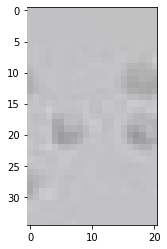

ind:  21
Prediction:  346


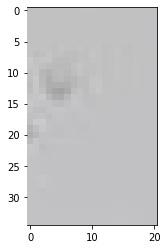

ind:  31
Prediction:  2


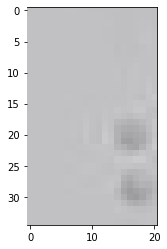

ind:  30
Prediction:  56


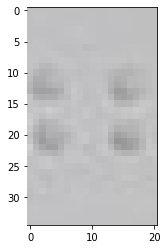

ind:  21
Prediction:  346


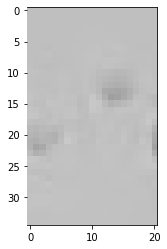

ind:  10
Prediction:  24


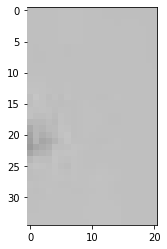

ind:  31
Prediction:  2


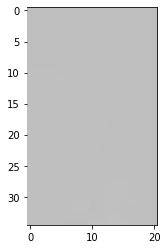

ind:  0
Prediction:  0


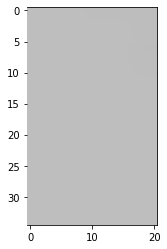

ind:  0
Prediction:  0


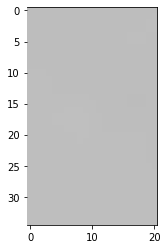

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

95


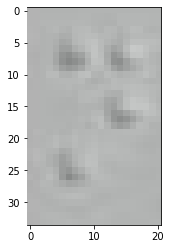

ind:  53
Prediction:  1345


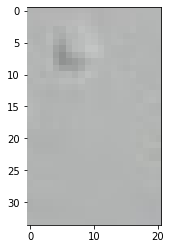

ind:  1
Prediction:  1


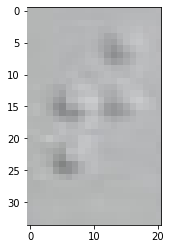

ind:  4
Prediction:  2345


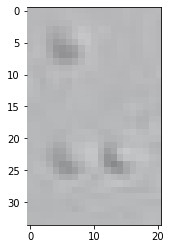

ind:  58
Prediction:  136


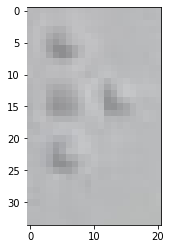

ind:  41
Prediction:  1235


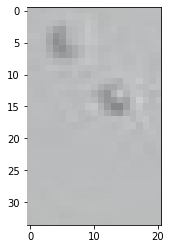

ind:  49
Prediction:  15


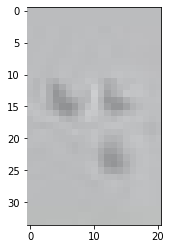

ind:  15
Prediction:  256


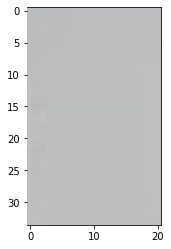

ind:  0
Prediction:  0


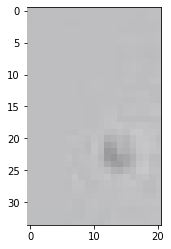

ind:  29
Prediction:  5


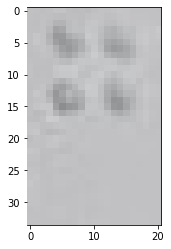

ind:  45
Prediction:  1245


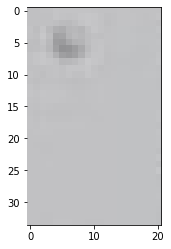

ind:  1
Prediction:  1


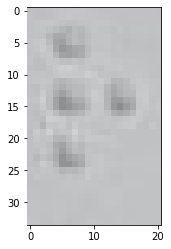

ind:  41
Prediction:  1235


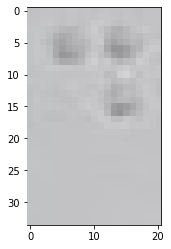

ind:  60
Prediction:  145


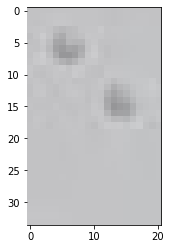

ind:  49
Prediction:  15


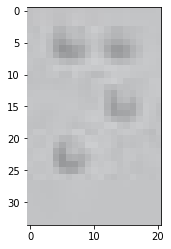

ind:  53
Prediction:  1345


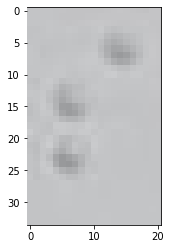

ind:  3
Prediction:  234


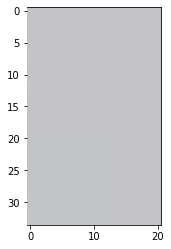

ind:  0
Prediction:  0


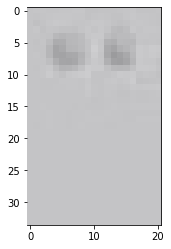

ind:  59
Prediction:  14


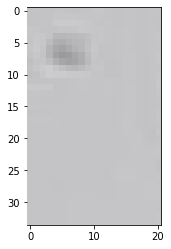

ind:  1
Prediction:  1


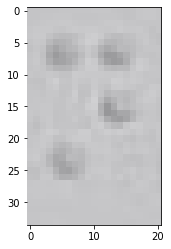

ind:  53
Prediction:  1345


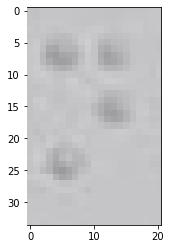

ind:  53
Prediction:  1345


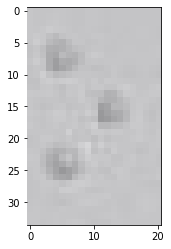

ind:  56
Prediction:  135


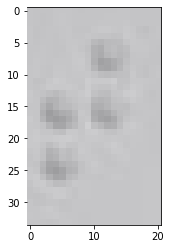

ind:  4
Prediction:  2345


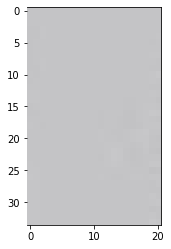

ind:  0
Prediction:  0


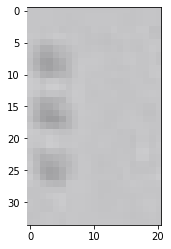

ind:  36
Prediction:  123


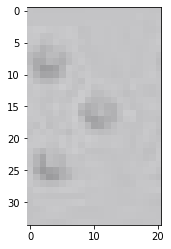

ind:  56
Prediction:  135


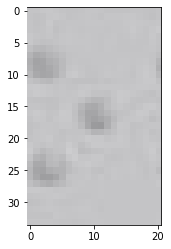

ind:  56
Prediction:  135


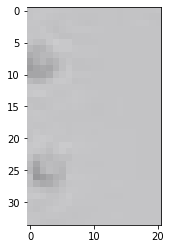

ind:  51
Prediction:  13


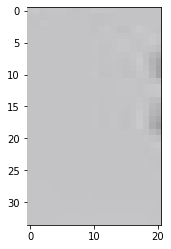

ind:  26
Prediction:  45


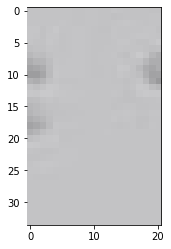

ind:  35
Prediction:  12


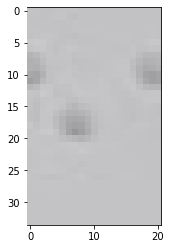

ind:  10
Prediction:  24


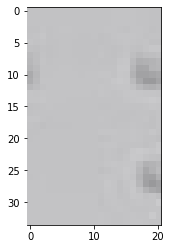

ind:  28
Prediction:  46


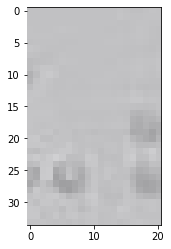

ind:  57
Prediction:  1356


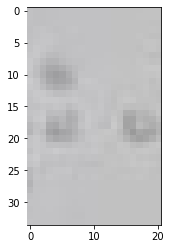

ind:  34
Prediction:  125


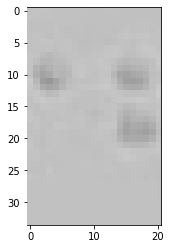

ind:  15
Prediction:  256


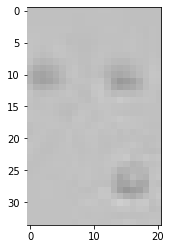

ind:  62
Prediction:  146


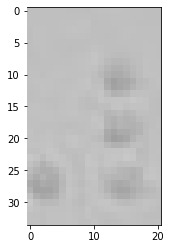

ind:  20
Prediction:  3456


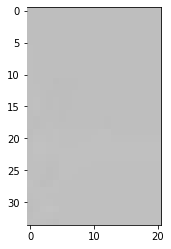

ind:  0
Prediction:  0


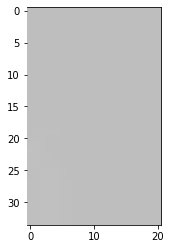

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

38


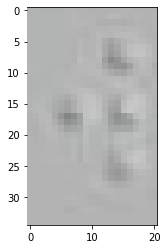

ind:  12
Prediction:  2456


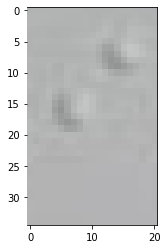

ind:  10
Prediction:  24


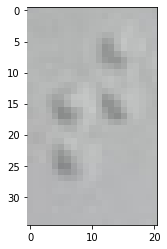

ind:  4
Prediction:  2345


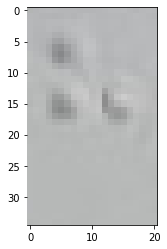

ind:  34
Prediction:  125


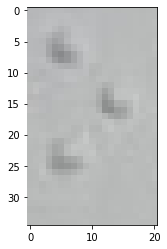

ind:  56
Prediction:  135


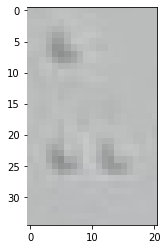

ind:  58
Prediction:  136


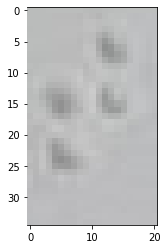

ind:  4
Prediction:  2345


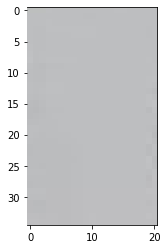

ind:  0
Prediction:  0


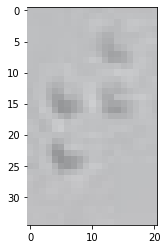

ind:  4
Prediction:  2345


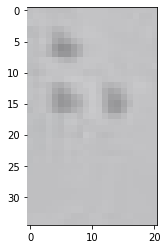

ind:  34
Prediction:  125


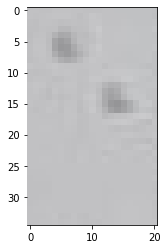

ind:  49
Prediction:  15


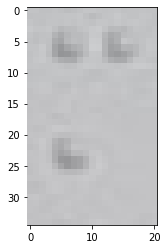

ind:  52
Prediction:  134


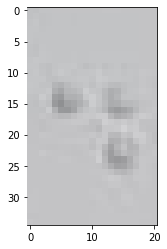

ind:  60
Prediction:  145


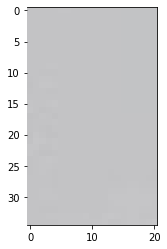

ind:  63
Prediction:  6


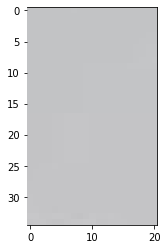

ind:  43
Prediction:  1236


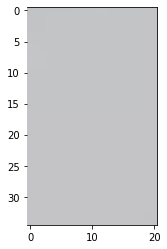

ind:  0
Prediction:  0


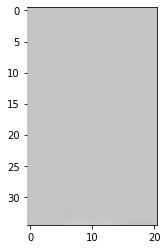

ind:  63
Prediction:  6


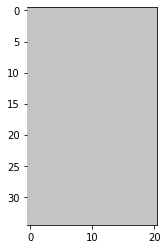

ind:  0
Prediction:  0


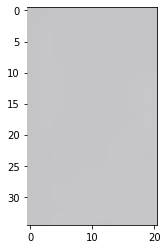

ind:  0
Prediction:  0


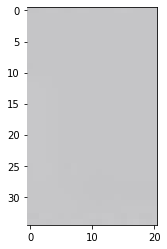

ind:  0
Prediction:  0


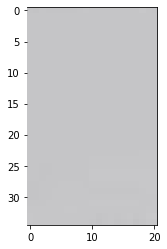

ind:  0
Prediction:  0


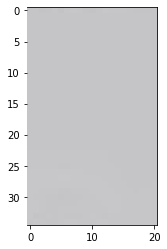

ind:  0
Prediction:  0


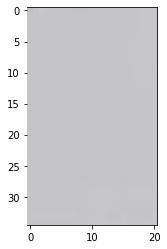

ind:  0
Prediction:  0


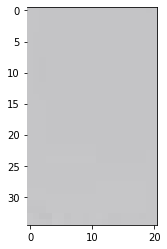

ind:  0
Prediction:  0


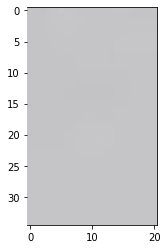

ind:  0
Prediction:  0


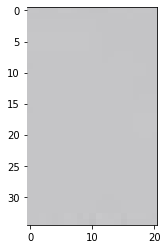

ind:  63
Prediction:  6


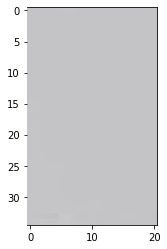

ind:  0
Prediction:  0


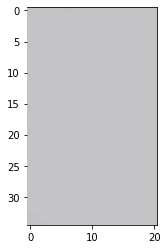

ind:  0
Prediction:  0


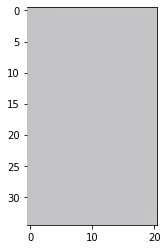

ind:  0
Prediction:  0


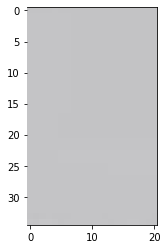

ind:  0
Prediction:  0


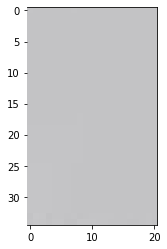

ind:  0
Prediction:  0


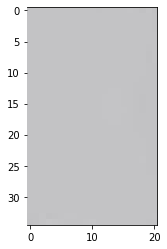

ind:  0
Prediction:  0


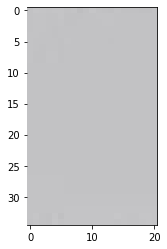

ind:  0
Prediction:  0


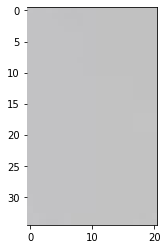

ind:  0
Prediction:  0


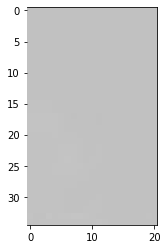

ind:  0
Prediction:  0


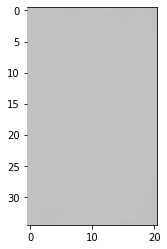

ind:  0
Prediction:  0


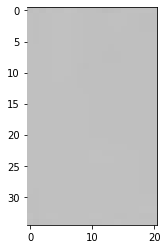

ind:  0
Prediction:  0


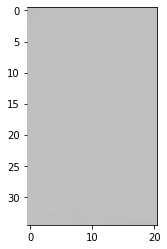

ind:  0
Prediction:  0


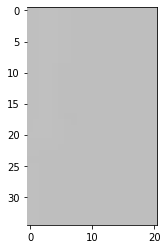

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

90


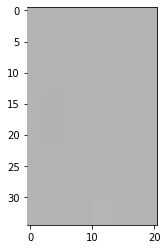

ind:  0
Prediction:  0


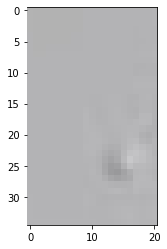

ind:  29
Prediction:  5


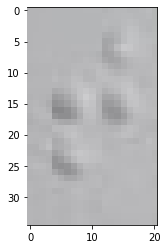

ind:  4
Prediction:  2345


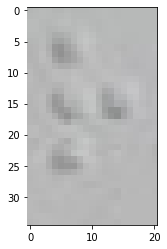

ind:  41
Prediction:  1235


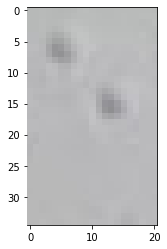

ind:  49
Prediction:  15


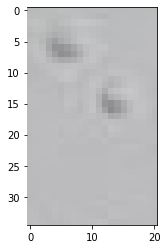

ind:  49
Prediction:  15


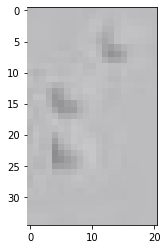

ind:  3
Prediction:  234


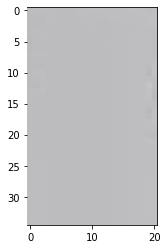

ind:  0
Prediction:  0


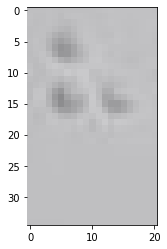

ind:  34
Prediction:  125


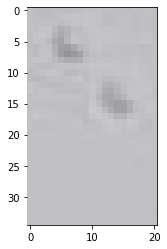

ind:  49
Prediction:  15


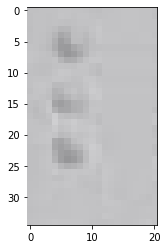

ind:  36
Prediction:  123


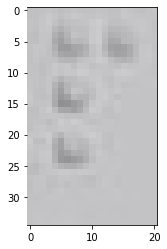

ind:  37
Prediction:  1234


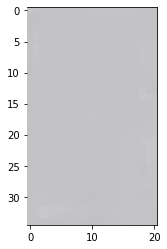

ind:  0
Prediction:  0


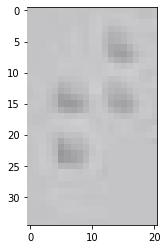

ind:  4
Prediction:  2345


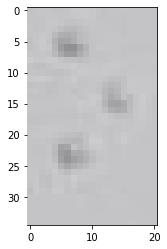

ind:  56
Prediction:  135


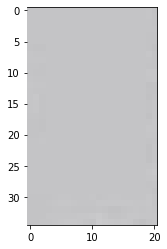

ind:  63
Prediction:  6


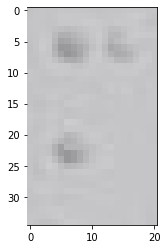

ind:  52
Prediction:  134


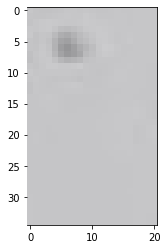

ind:  1
Prediction:  1


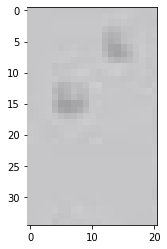

ind:  10
Prediction:  24


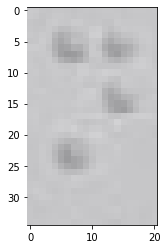

ind:  53
Prediction:  1345


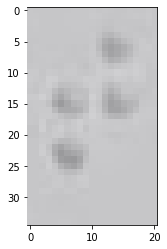

ind:  4
Prediction:  2345


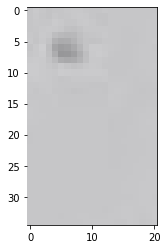

ind:  1
Prediction:  1


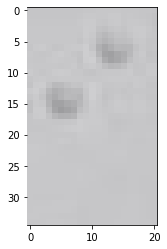

ind:  10
Prediction:  24


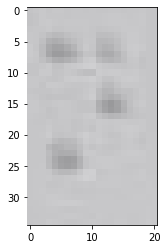

ind:  53
Prediction:  1345


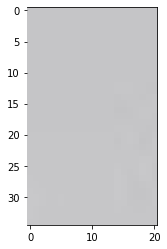

ind:  0
Prediction:  0


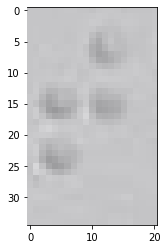

ind:  4
Prediction:  2345


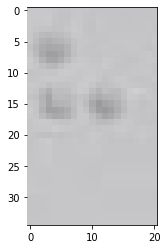

ind:  34
Prediction:  125


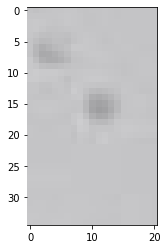

ind:  49
Prediction:  15


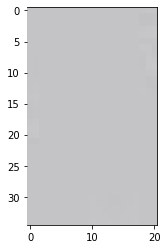

ind:  0
Prediction:  0


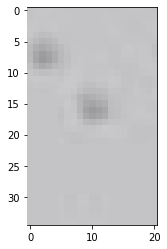

ind:  49
Prediction:  15


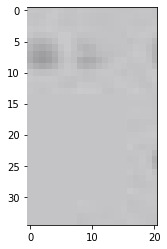

ind:  62
Prediction:  146


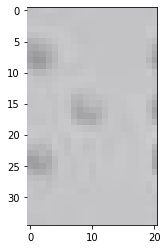

ind:  57
Prediction:  1356


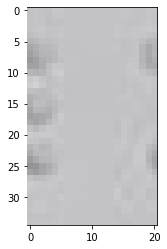

ind:  36
Prediction:  123


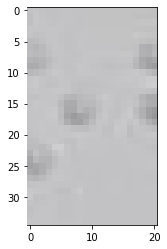

ind:  21
Prediction:  346


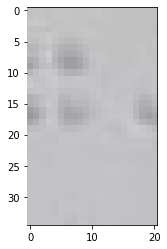

ind:  34
Prediction:  125


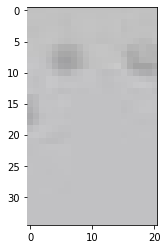

ind:  44
Prediction:  124


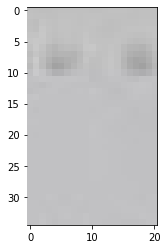

ind:  59
Prediction:  14


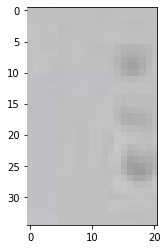

ind:  27
Prediction:  456


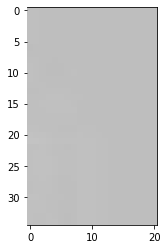

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

94


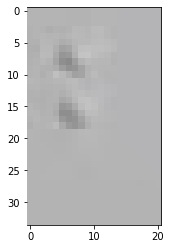

ind:  35
Prediction:  12


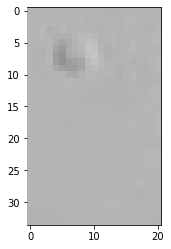

ind:  1
Prediction:  1


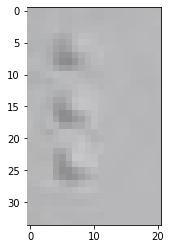

ind:  36
Prediction:  123


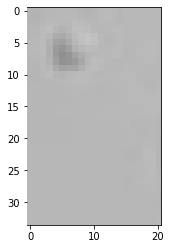

ind:  1
Prediction:  1


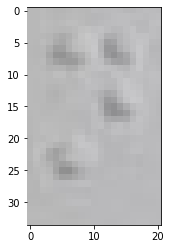

ind:  53
Prediction:  1345


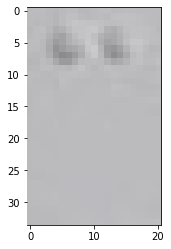

ind:  59
Prediction:  14


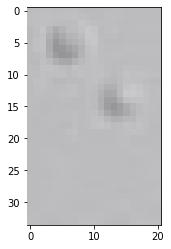

ind:  49
Prediction:  15


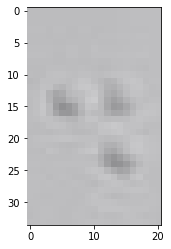

ind:  15
Prediction:  256


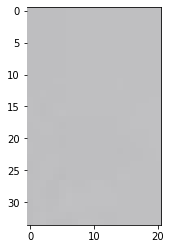

ind:  0
Prediction:  0


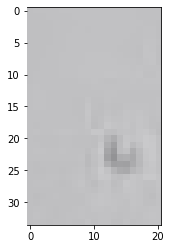

ind:  29
Prediction:  5


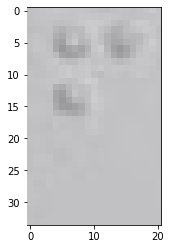

ind:  44
Prediction:  124


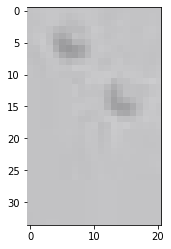

ind:  49
Prediction:  15


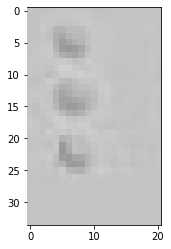

ind:  36
Prediction:  123


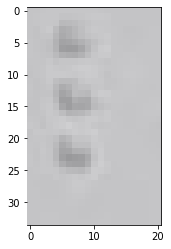

ind:  36
Prediction:  123


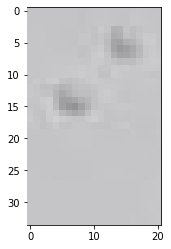

ind:  10
Prediction:  24


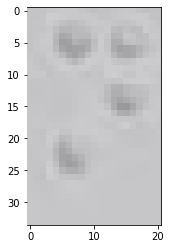

ind:  53
Prediction:  1345


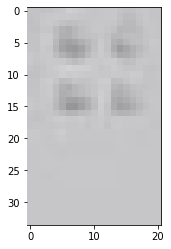

ind:  45
Prediction:  1245


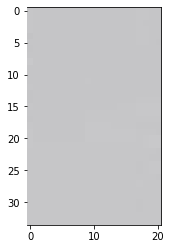

ind:  0
Prediction:  0


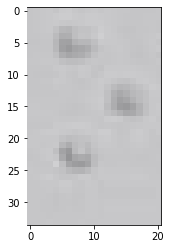

ind:  56
Prediction:  135


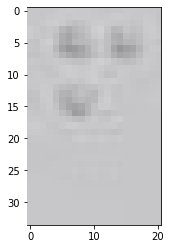

ind:  44
Prediction:  124


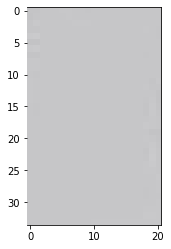

ind:  0
Prediction:  0


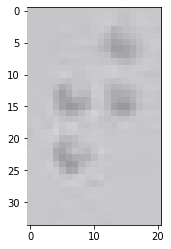

ind:  4
Prediction:  2345


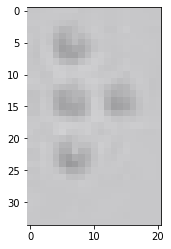

ind:  41
Prediction:  1235


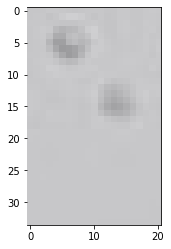

ind:  49
Prediction:  15


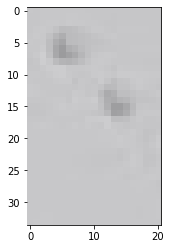

ind:  49
Prediction:  15


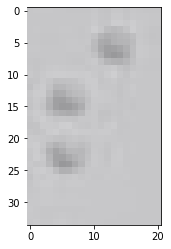

ind:  3
Prediction:  234


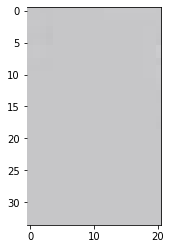

ind:  0
Prediction:  0


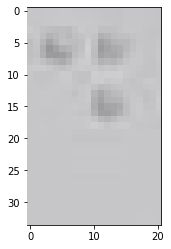

ind:  60
Prediction:  145


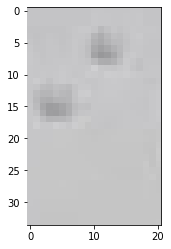

ind:  10
Prediction:  24


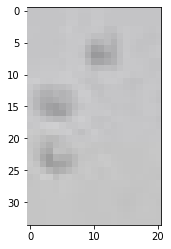

ind:  3
Prediction:  234


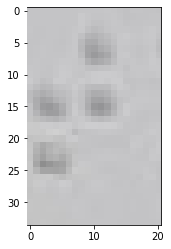

ind:  4
Prediction:  2345


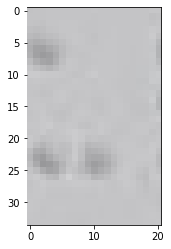

ind:  58
Prediction:  136


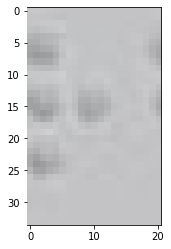

ind:  41
Prediction:  1235


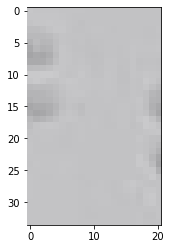

ind:  30
Prediction:  56


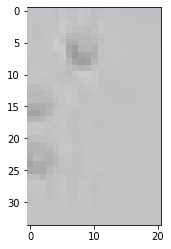

ind:  3
Prediction:  234


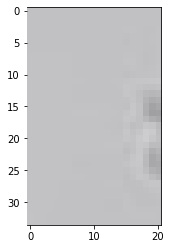

ind:  30
Prediction:  56


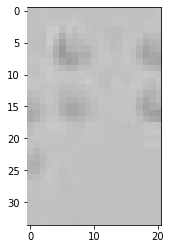

ind:  38
Prediction:  12345


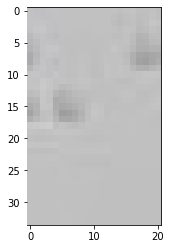

ind:  34
Prediction:  125


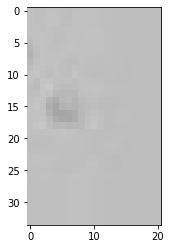

ind:  31
Prediction:  2


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

32


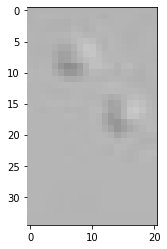

ind:  49
Prediction:  15


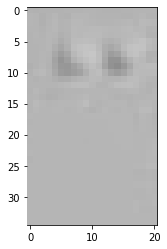

ind:  59
Prediction:  14


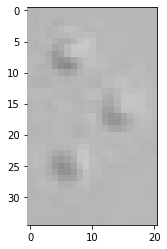

ind:  56
Prediction:  135


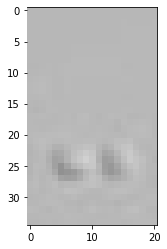

ind:  24
Prediction:  36


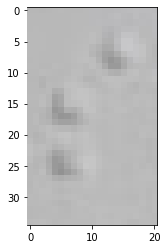

ind:  3
Prediction:  234


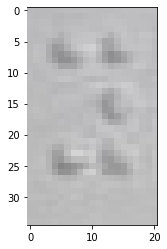

ind:  54
Prediction:  13456


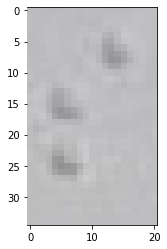

ind:  3
Prediction:  234


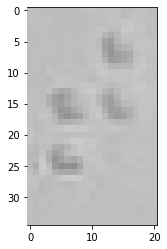

ind:  4
Prediction:  2345


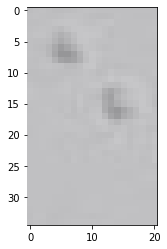

ind:  49
Prediction:  15


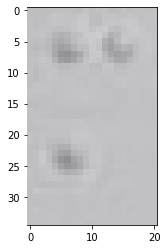

ind:  52
Prediction:  134


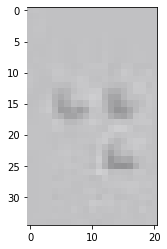

ind:  15
Prediction:  256


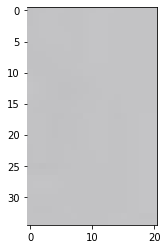

ind:  0
Prediction:  0


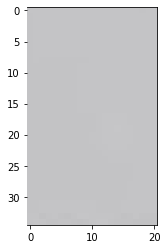

ind:  17
Prediction:  3


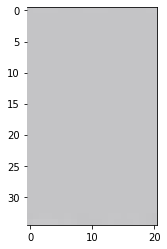

ind:  17
Prediction:  3


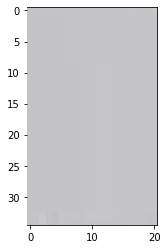

ind:  17
Prediction:  3


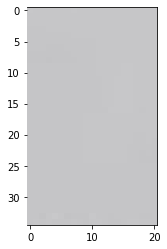

ind:  0
Prediction:  0


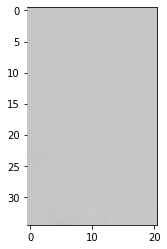

ind:  0
Prediction:  0


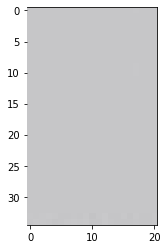

ind:  17
Prediction:  3


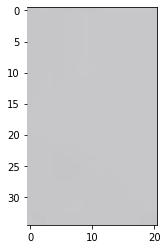

ind:  0
Prediction:  0


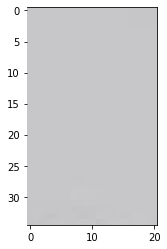

ind:  17
Prediction:  3


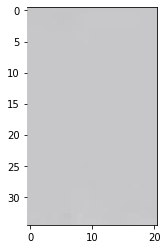

ind:  17
Prediction:  3


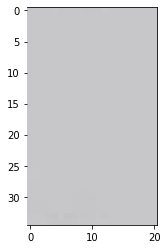

ind:  17
Prediction:  3


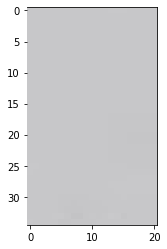

ind:  17
Prediction:  3


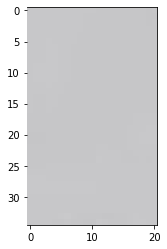

ind:  0
Prediction:  0


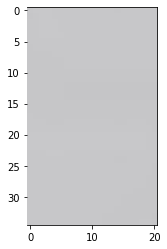

ind:  0
Prediction:  0


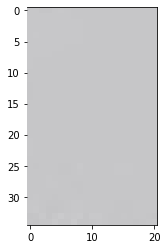

ind:  0
Prediction:  0


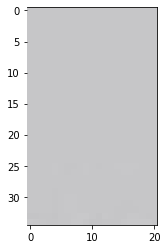

ind:  0
Prediction:  0


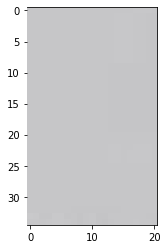

ind:  17
Prediction:  3


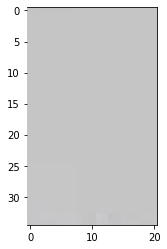

ind:  24
Prediction:  36


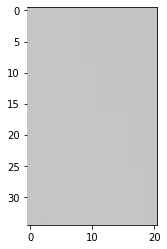

ind:  0
Prediction:  0


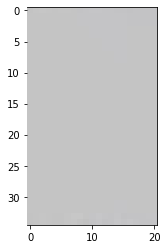

ind:  17
Prediction:  3


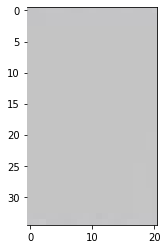

ind:  17
Prediction:  3


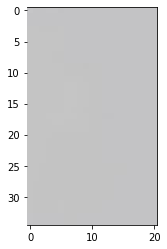

ind:  0
Prediction:  0


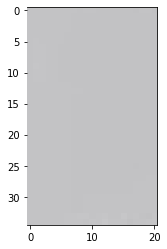

ind:  0
Prediction:  0


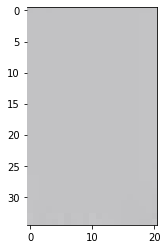

ind:  17
Prediction:  3


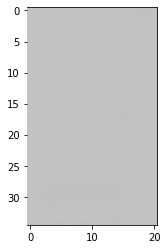

ind:  0
Prediction:  0


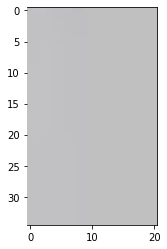

ind:  0
Prediction:  0


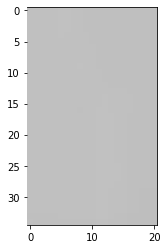

ind:  0
Prediction:  0


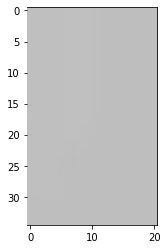

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

83


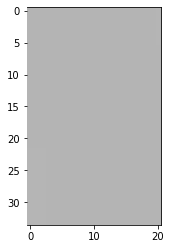

ind:  0
Prediction:  0


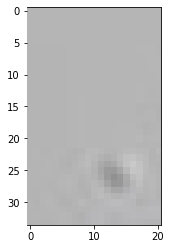

ind:  30
Prediction:  56


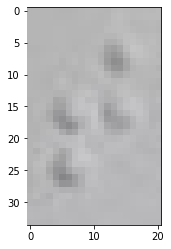

ind:  4
Prediction:  2345


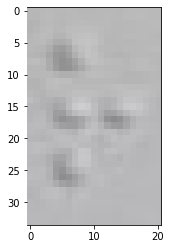

ind:  41
Prediction:  1235


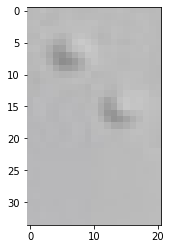

ind:  49
Prediction:  15


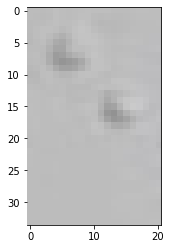

ind:  49
Prediction:  15


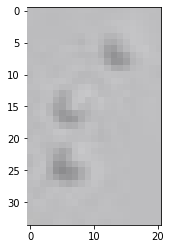

ind:  3
Prediction:  234


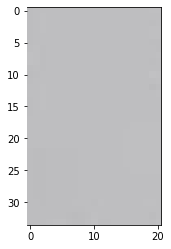

ind:  17
Prediction:  3


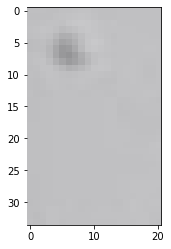

ind:  1
Prediction:  1


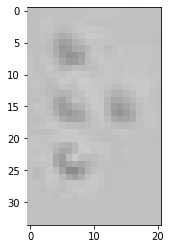

ind:  41
Prediction:  1235


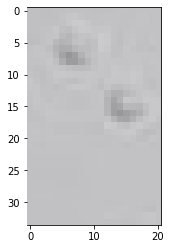

ind:  49
Prediction:  15


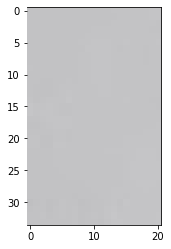

ind:  0
Prediction:  0


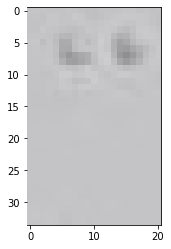

ind:  59
Prediction:  14


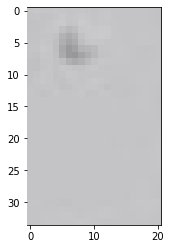

ind:  1
Prediction:  1


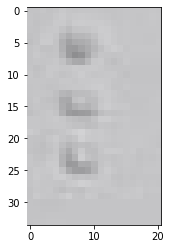

ind:  36
Prediction:  123


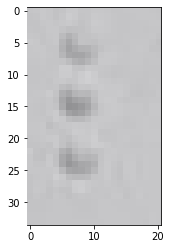

ind:  36
Prediction:  123


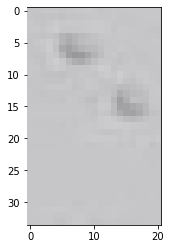

ind:  49
Prediction:  15


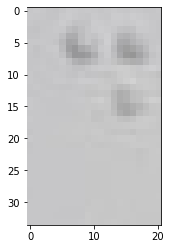

ind:  60
Prediction:  145


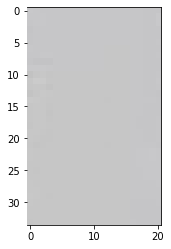

ind:  0
Prediction:  0


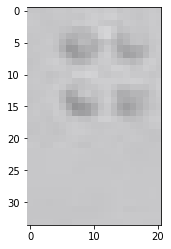

ind:  45
Prediction:  1245


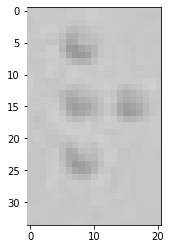

ind:  41
Prediction:  1235


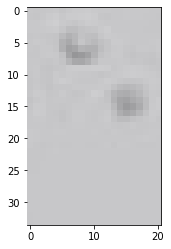

ind:  49
Prediction:  15


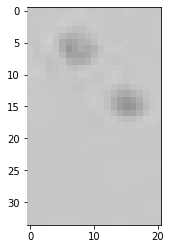

ind:  49
Prediction:  15


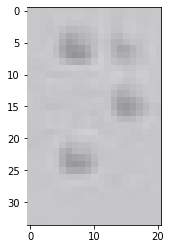

ind:  53
Prediction:  1345


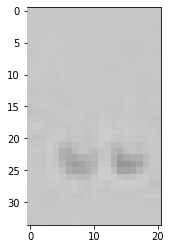

ind:  24
Prediction:  36


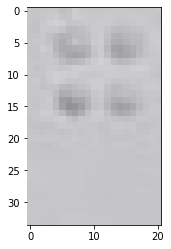

ind:  45
Prediction:  1245


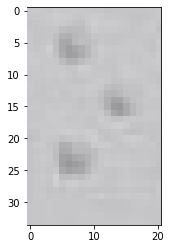

ind:  56
Prediction:  135


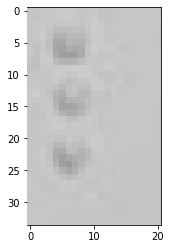

ind:  36
Prediction:  123


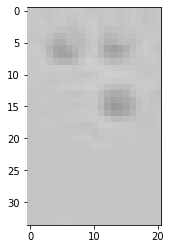

ind:  60
Prediction:  145


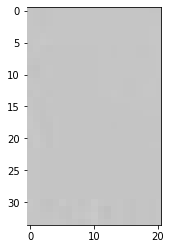

ind:  17
Prediction:  3


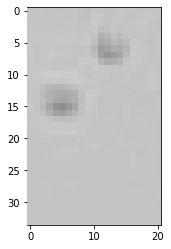

ind:  10
Prediction:  24


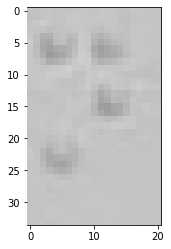

ind:  53
Prediction:  1345


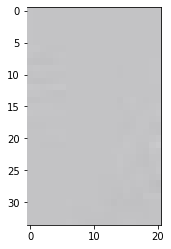

ind:  0
Prediction:  0


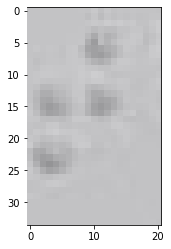

ind:  4
Prediction:  2345


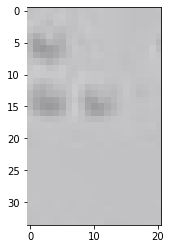

ind:  34
Prediction:  125


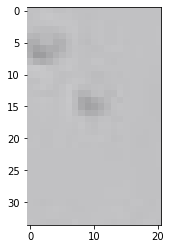

ind:  49
Prediction:  15


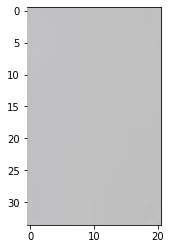

ind:  0
Prediction:  0


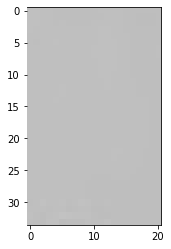

ind:  17
Prediction:  3


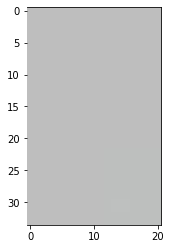

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

86


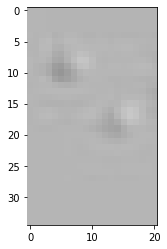

ind:  49
Prediction:  15


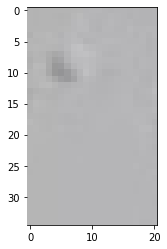

ind:  1
Prediction:  1


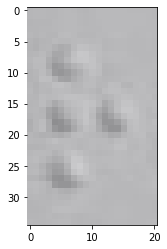

ind:  41
Prediction:  1235


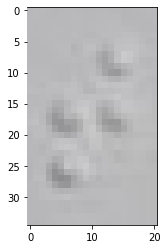

ind:  4
Prediction:  2345


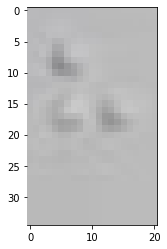

ind:  34
Prediction:  125


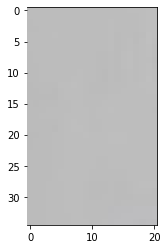

ind:  0
Prediction:  0


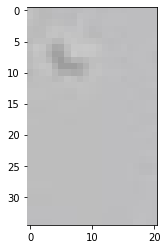

ind:  1
Prediction:  1


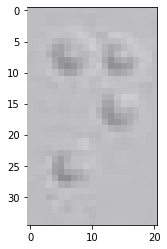

ind:  53
Prediction:  1345


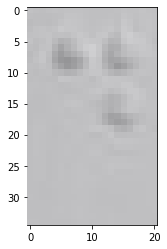

ind:  60
Prediction:  145


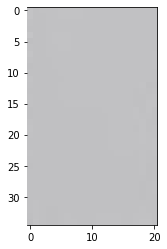

ind:  0
Prediction:  0


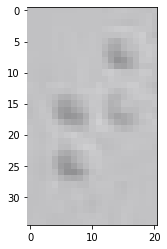

ind:  4
Prediction:  2345


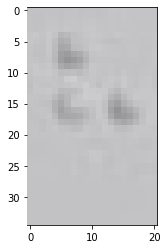

ind:  34
Prediction:  125


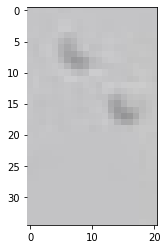

ind:  49
Prediction:  15


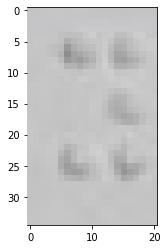

ind:  54
Prediction:  13456


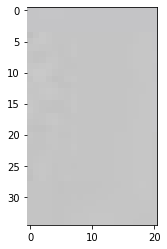

ind:  0
Prediction:  0


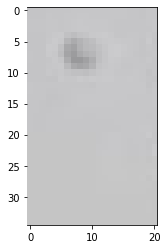

ind:  1
Prediction:  1


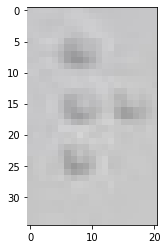

ind:  41
Prediction:  1235


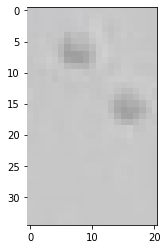

ind:  49
Prediction:  15


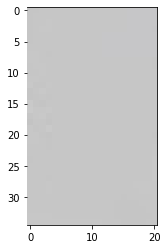

ind:  0
Prediction:  0


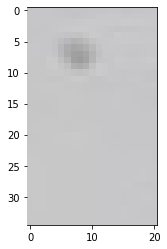

ind:  1
Prediction:  1


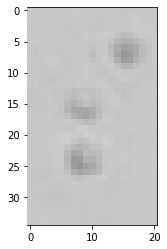

ind:  3
Prediction:  234


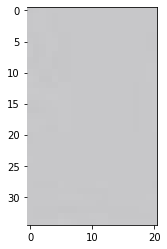

ind:  0
Prediction:  0


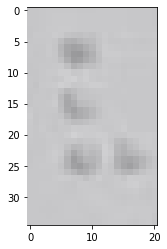

ind:  43
Prediction:  1236


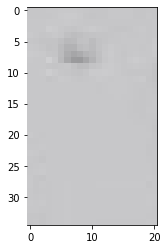

ind:  1
Prediction:  1


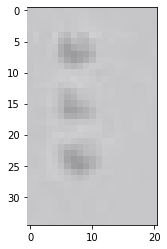

ind:  36
Prediction:  123


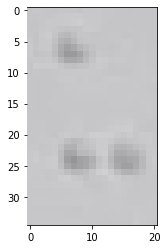

ind:  58
Prediction:  136


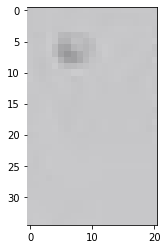

ind:  1
Prediction:  1


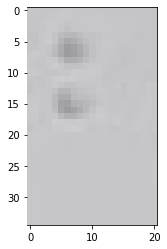

ind:  35
Prediction:  12


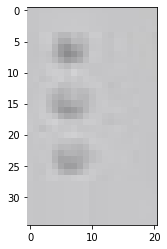

ind:  36
Prediction:  123


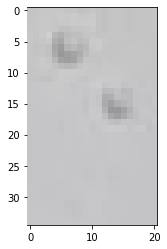

ind:  49
Prediction:  15


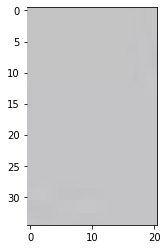

ind:  17
Prediction:  3


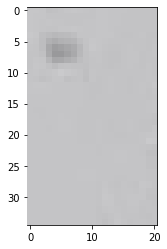

ind:  1
Prediction:  1


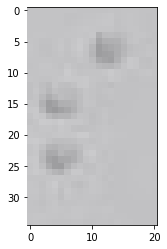

ind:  3
Prediction:  234


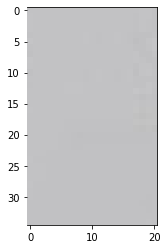

ind:  0
Prediction:  0


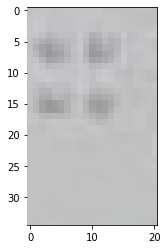

ind:  45
Prediction:  1245


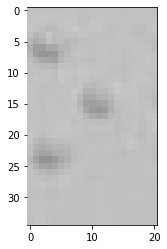

ind:  56
Prediction:  135


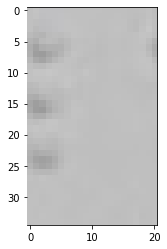

ind:  36
Prediction:  123


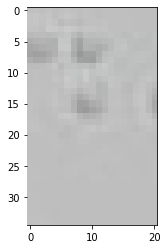

ind:  60
Prediction:  145


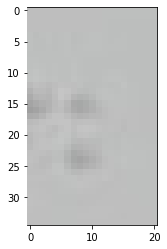

ind:  15
Prediction:  256


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

94


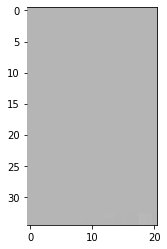

ind:  0
Prediction:  0


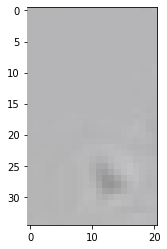

ind:  30
Prediction:  56


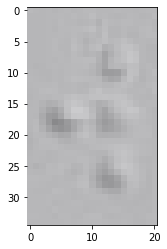

ind:  12
Prediction:  2456


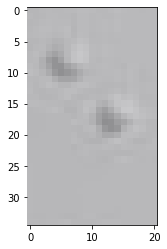

ind:  49
Prediction:  15


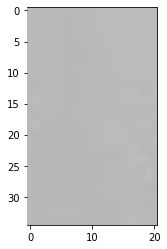

ind:  0
Prediction:  0


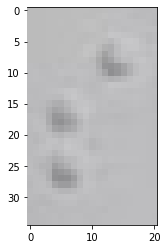

ind:  3
Prediction:  234


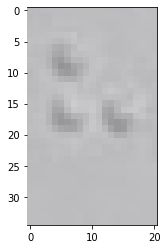

ind:  34
Prediction:  125


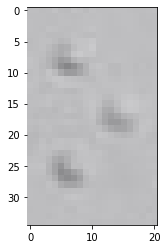

ind:  56
Prediction:  135


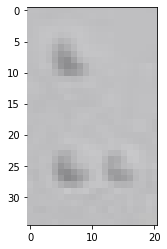

ind:  58
Prediction:  136


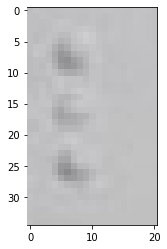

ind:  36
Prediction:  123


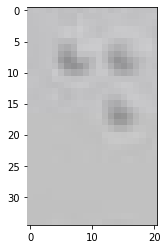

ind:  60
Prediction:  145


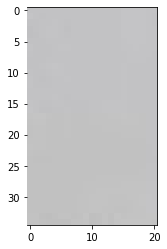

ind:  63
Prediction:  6


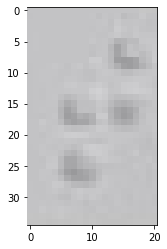

ind:  4
Prediction:  2345


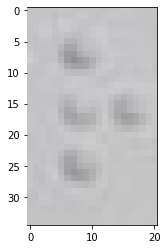

ind:  41
Prediction:  1235


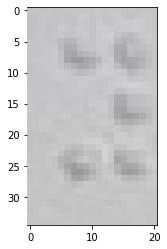

ind:  54
Prediction:  13456


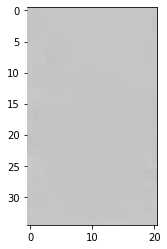

ind:  0
Prediction:  0


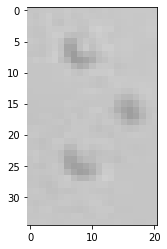

ind:  56
Prediction:  135


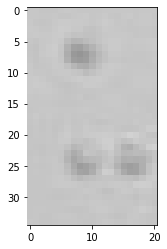

ind:  58
Prediction:  136


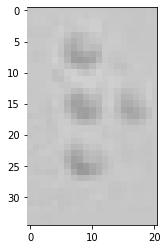

ind:  41
Prediction:  1235


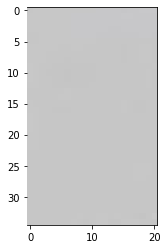

ind:  0
Prediction:  0


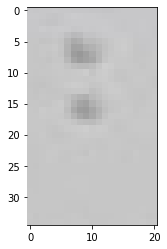

ind:  35
Prediction:  12


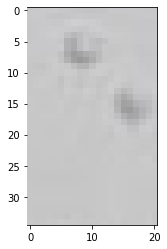

ind:  49
Prediction:  15


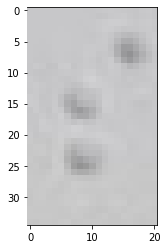

ind:  3
Prediction:  234


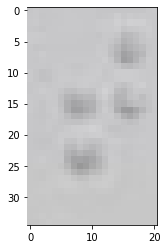

ind:  4
Prediction:  2345


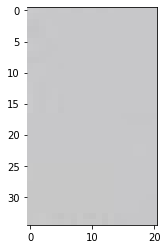

ind:  17
Prediction:  3


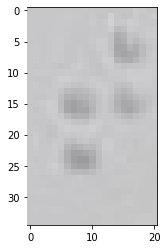

ind:  4
Prediction:  2345


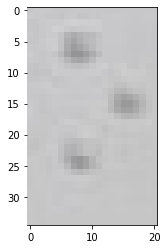

ind:  56
Prediction:  135


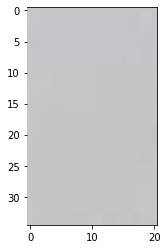

ind:  63
Prediction:  6


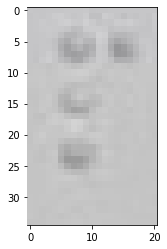

ind:  37
Prediction:  1234


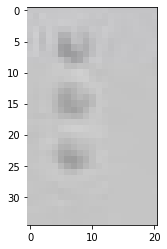

ind:  36
Prediction:  123


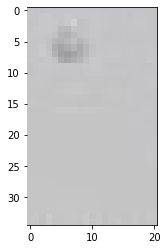

ind:  1
Prediction:  1


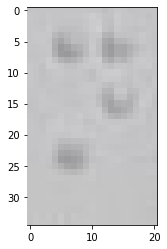

ind:  53
Prediction:  1345


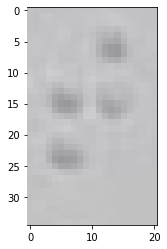

ind:  4
Prediction:  2345


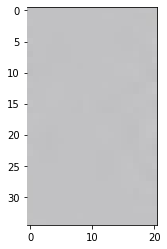

ind:  0
Prediction:  0


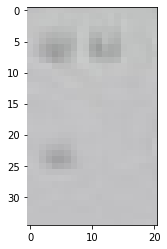

ind:  52
Prediction:  134


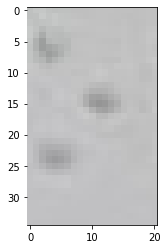

ind:  56
Prediction:  135


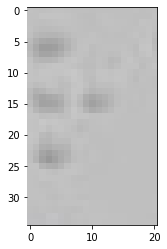

ind:  41
Prediction:  1235


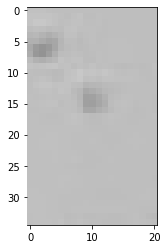

ind:  49
Prediction:  15


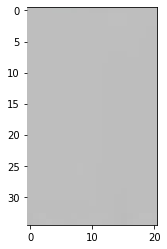

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

91


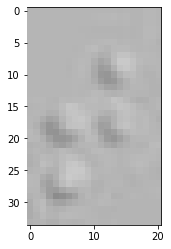

ind:  4
Prediction:  2345


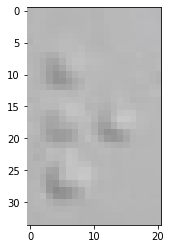

ind:  41
Prediction:  1235


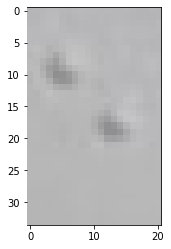

ind:  49
Prediction:  15


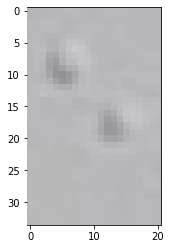

ind:  49
Prediction:  15


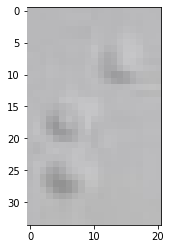

ind:  3
Prediction:  234


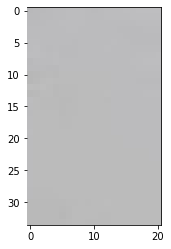

ind:  0
Prediction:  0


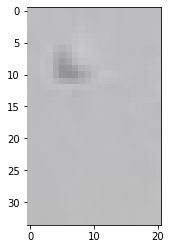

ind:  1
Prediction:  1


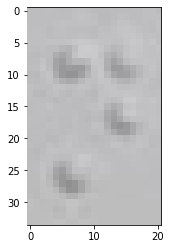

ind:  53
Prediction:  1345


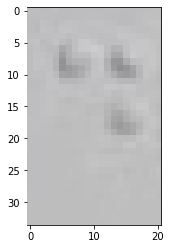

ind:  60
Prediction:  145


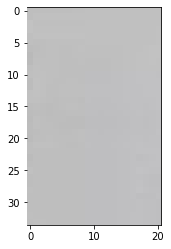

ind:  0
Prediction:  0


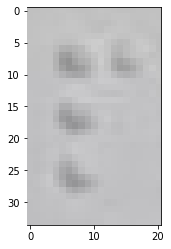

ind:  37
Prediction:  1234


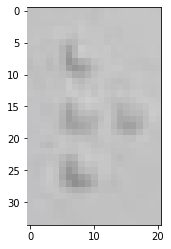

ind:  41
Prediction:  1235


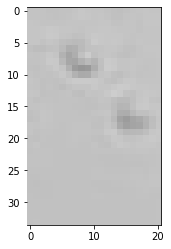

ind:  49
Prediction:  15


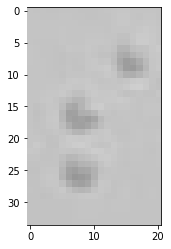

ind:  3
Prediction:  234


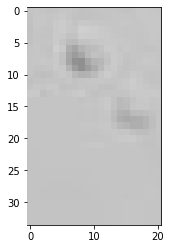

ind:  49
Prediction:  15


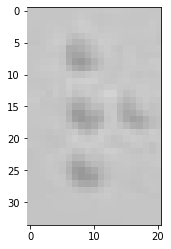

ind:  41
Prediction:  1235


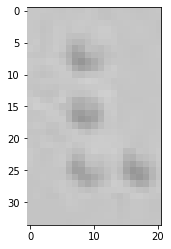

ind:  43
Prediction:  1236


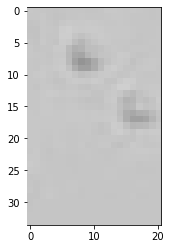

ind:  49
Prediction:  15


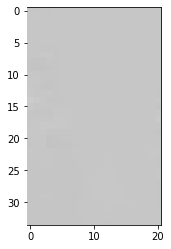

ind:  0
Prediction:  0


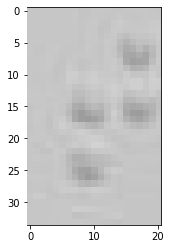

ind:  4
Prediction:  2345


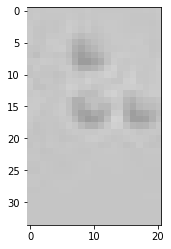

ind:  34
Prediction:  125


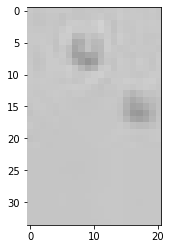

ind:  49
Prediction:  15


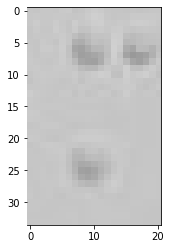

ind:  52
Prediction:  134


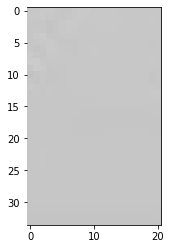

ind:  0
Prediction:  0


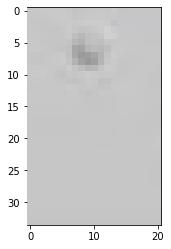

ind:  1
Prediction:  1


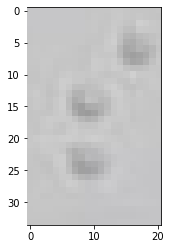

ind:  3
Prediction:  234


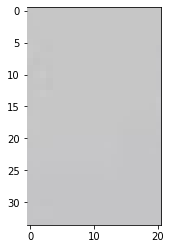

ind:  0
Prediction:  0


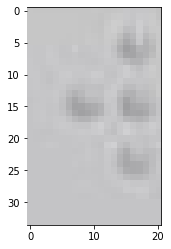

ind:  12
Prediction:  2456


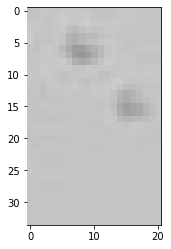

ind:  49
Prediction:  15


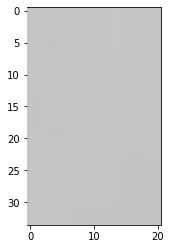

ind:  0
Prediction:  0


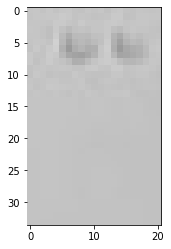

ind:  59
Prediction:  14


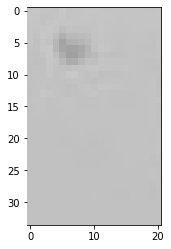

ind:  1
Prediction:  1


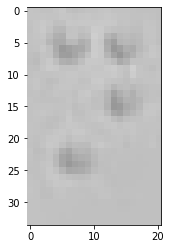

ind:  53
Prediction:  1345


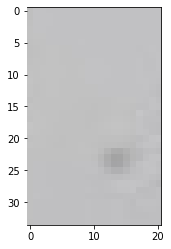

ind:  63
Prediction:  6


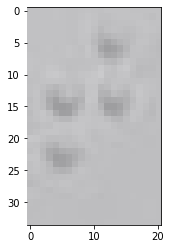

ind:  4
Prediction:  2345


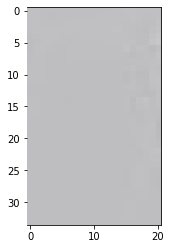

ind:  0
Prediction:  0


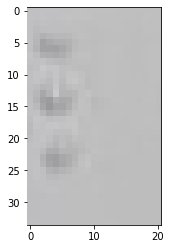

ind:  36
Prediction:  123


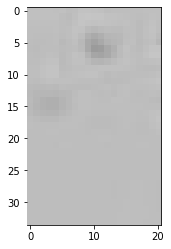

ind:  10
Prediction:  24


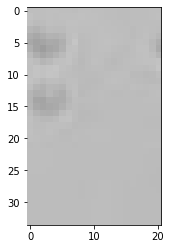

ind:  35
Prediction:  12


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

38


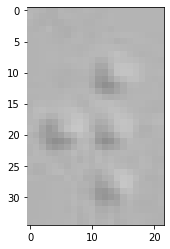

ind:  12
Prediction:  2456


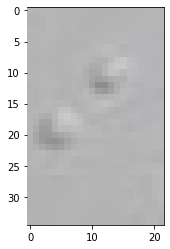

ind:  10
Prediction:  24


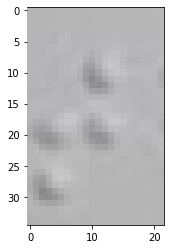

ind:  4
Prediction:  2345


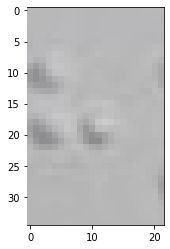

ind:  34
Prediction:  125


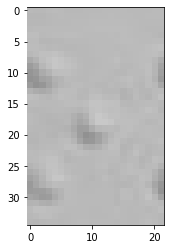

ind:  56
Prediction:  135


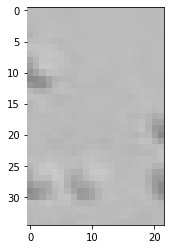

ind:  57
Prediction:  1356


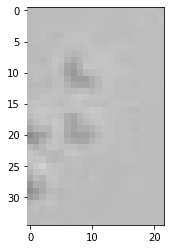

ind:  4
Prediction:  2345


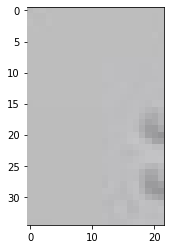

ind:  30
Prediction:  56


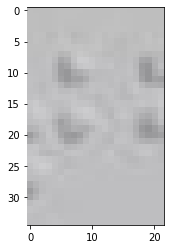

ind:  4
Prediction:  2345


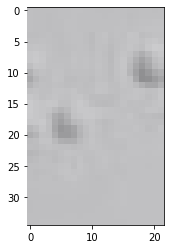

ind:  10
Prediction:  24


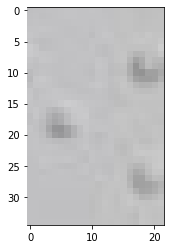

ind:  28
Prediction:  46


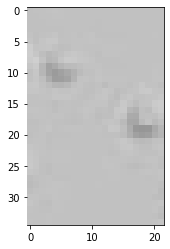

ind:  49
Prediction:  15


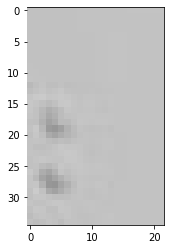

ind:  2
Prediction:  23


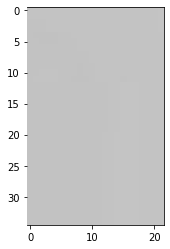

ind:  0
Prediction:  0


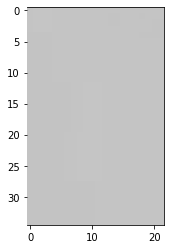

ind:  0
Prediction:  0


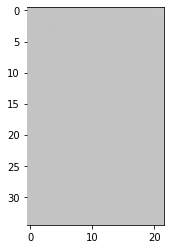

ind:  0
Prediction:  0


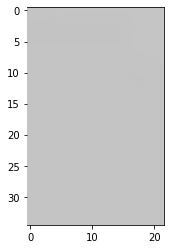

ind:  0
Prediction:  0


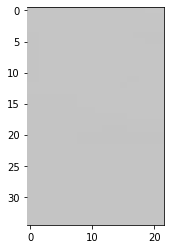

ind:  0
Prediction:  0


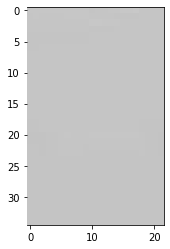

ind:  0
Prediction:  0


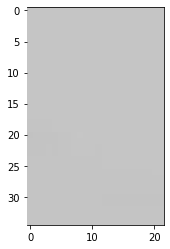

ind:  0
Prediction:  0


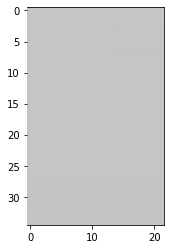

ind:  0
Prediction:  0


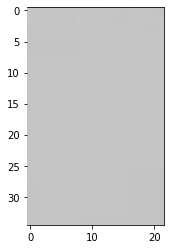

ind:  0
Prediction:  0


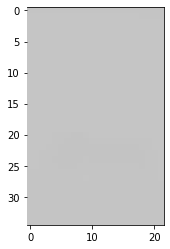

ind:  0
Prediction:  0


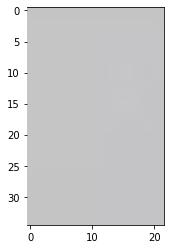

ind:  0
Prediction:  0


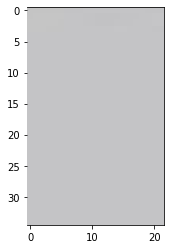

ind:  0
Prediction:  0


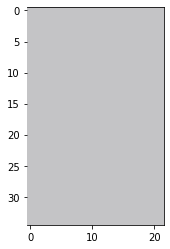

ind:  0
Prediction:  0


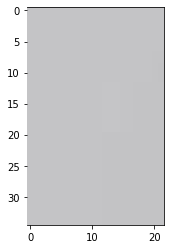

ind:  0
Prediction:  0


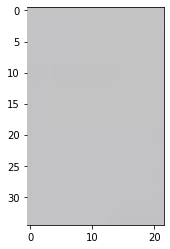

ind:  0
Prediction:  0


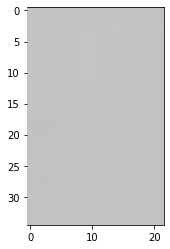

ind:  0
Prediction:  0


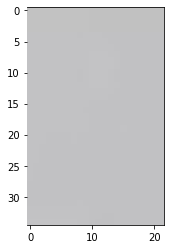

ind:  0
Prediction:  0


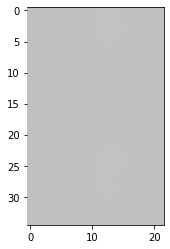

ind:  0
Prediction:  0


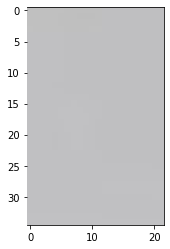

ind:  0
Prediction:  0


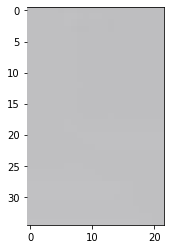

ind:  0
Prediction:  0


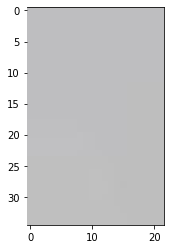

ind:  0
Prediction:  0


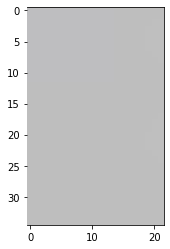

ind:  0
Prediction:  0


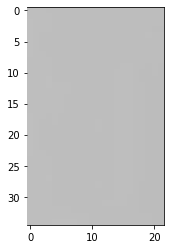

ind:  0
Prediction:  0


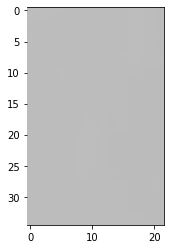

ind:  0
Prediction:  0
['6', '5', '2345', '1235', '15', '15', '234', '1236', '1', '1235', '15', '0', '13', '1345', '135', '2456', '1345', '0', '2', '234', '0', '1345', '2', '356', '136', '1235', '56', '123', '5', '2', '56', '236', '5', '46', '235', '23', '0', '0', '0', '0', '2456', '1', '2345', '15', '1235', '0', '124', '24', '123', '2345', '15', '1235', '234', '0', '1', '1345', '145', '0', '2345', '125', '15', '13456', '0', '2356', '136', '2', '1235', '1256', '0', '1356', '234', '5', '56', '2345', '16', '256', '1256', '56', '23', '0', '1234', '135', '123', '123', '136', '125', '246', '246', '125', '23', '0', '0', '6', '3', '0', '6', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '14', '14', '0', '0', '0', '0', '4', '4', '4', '0', '6', '5', '2345', '125', '15', '13456', '0', '1', '123', '234', '135', '0', '1', '145', '145', '0', '2345', '135', '0', '2345', '125', '15', '0', '12', '15', '2', '1356', '235', '13456', '46', '346', '2', '56', '346', '24', '2', '0', '0', '0', '1345',

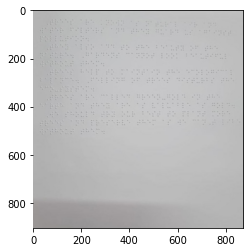

Treesvare known ,s n,url,?!;    water filters and they u,r zst; polluhh;  '            cc     They also add to the be,z!y,i,   nature gardens cannot lookbizh  without themdV                       trees help toMaintain the ezlhfc balance felling of trees distursqh,eco-system '''  ' ''''    '- ''  '     trees'are called green-gold'in the ' earth and they are as valuable'as gold we shouldTry our best'toPlant more trees and preserve them as we canT libwithozttie;                        


In [20]:
english_text_output = make_prediction("page2.jpeg")
print(english_text_output)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

1293


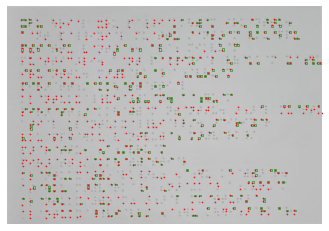

2
39 881 35 591 5 10
inter width:  4 inter height:  5
height, h, width, w: 


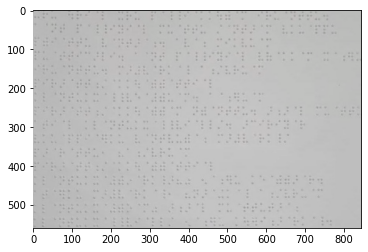

560 10 845 5


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

1294


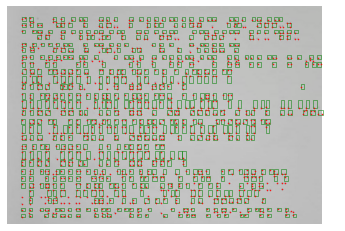

4
40 881 33 589 14 22
845 560
inter width:  8 inter height:  14
new:  14 22 8 14
width:  846 height:  570 nchars:  38 nlines:  16 w:  22.263157894736842 h:  35.625


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

95


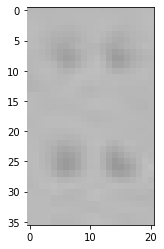

ind:  55
Prediction:  1346


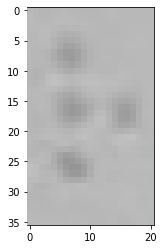

ind:  41
Prediction:  1235


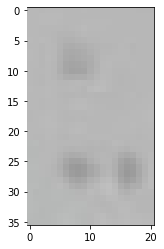

ind:  7
Prediction:  235


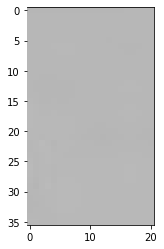

ind:  0
Prediction:  0


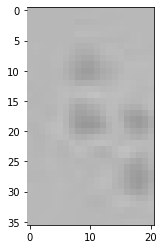

ind:  48
Prediction:  1256


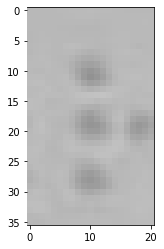

ind:  41
Prediction:  1235


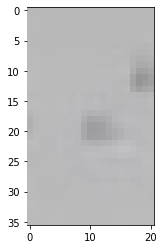

ind:  22
Prediction:  35


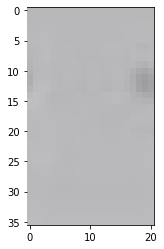

ind:  31
Prediction:  2


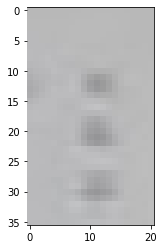

ind:  61
Prediction:  1456


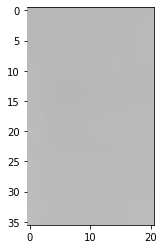

ind:  0
Prediction:  0


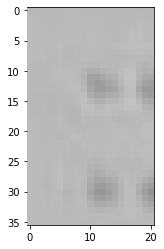

ind:  55
Prediction:  1346


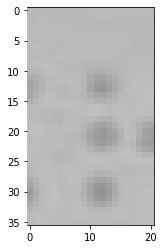

ind:  15
Prediction:  256


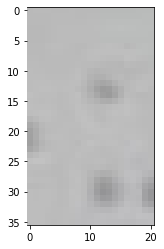

ind:  58
Prediction:  136


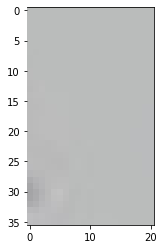

ind:  17
Prediction:  3


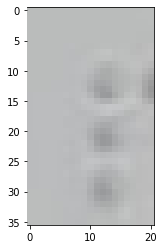

ind:  37
Prediction:  1234


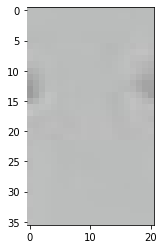

ind:  31
Prediction:  2


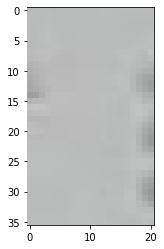

ind:  27
Prediction:  456


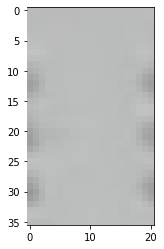

ind:  27
Prediction:  456


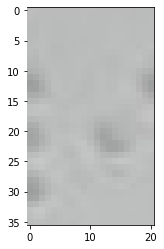

ind:  41
Prediction:  1235


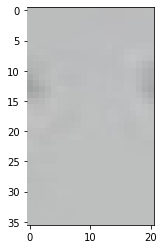

ind:  31
Prediction:  2


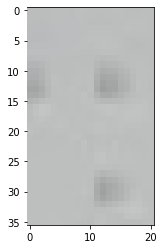

ind:  62
Prediction:  146


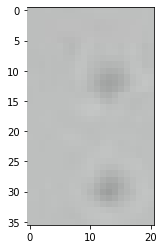

ind:  28
Prediction:  46


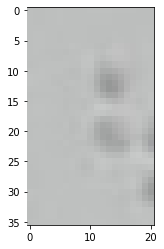

ind:  30
Prediction:  56


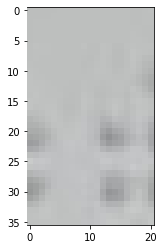

ind:  7
Prediction:  235


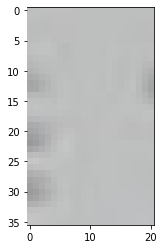

ind:  36
Prediction:  123


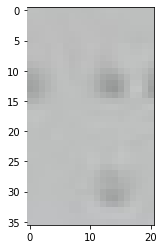

ind:  62
Prediction:  146


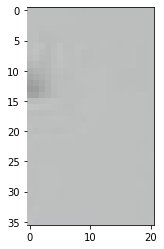

ind:  31
Prediction:  2


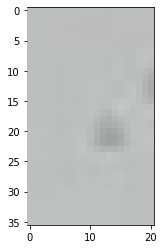

ind:  22
Prediction:  35


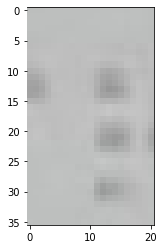

ind:  61
Prediction:  1456


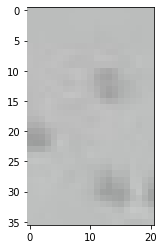

ind:  13
Prediction:  246


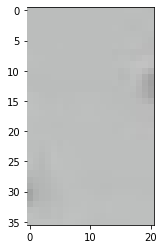

ind:  18
Prediction:  34


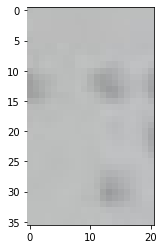

ind:  15
Prediction:  256


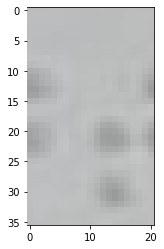

ind:  23
Prediction:  356


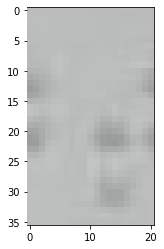

ind:  30
Prediction:  56


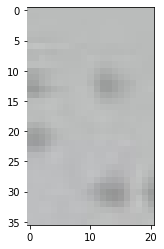

ind:  47
Prediction:  1246


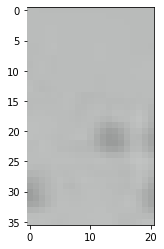

ind:  23
Prediction:  356


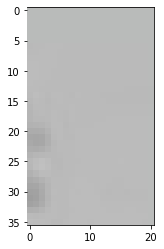

ind:  2
Prediction:  23


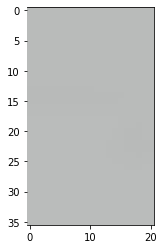

ind:  0
Prediction:  0


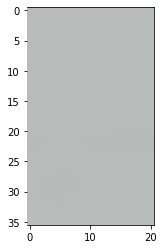

ind:  0
Prediction:  0


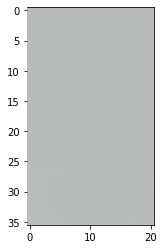

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

91


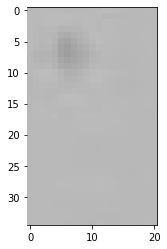

ind:  1
Prediction:  1


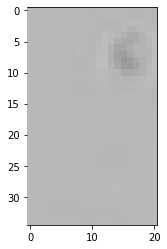

ind:  25
Prediction:  4


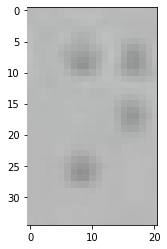

ind:  53
Prediction:  1345


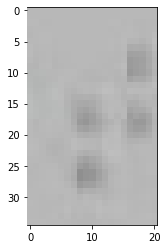

ind:  4
Prediction:  2345


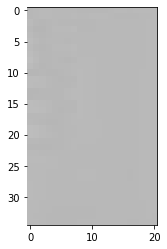

ind:  0
Prediction:  0


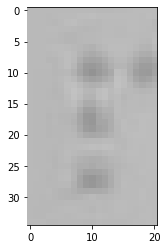

ind:  37
Prediction:  1234


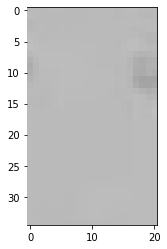

ind:  25
Prediction:  4


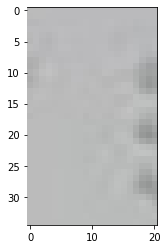

ind:  27
Prediction:  456


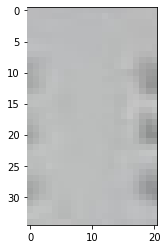

ind:  27
Prediction:  456


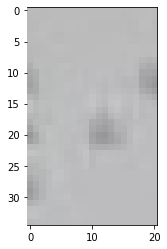

ind:  22
Prediction:  35


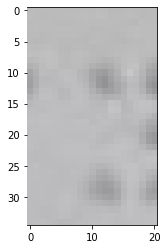

ind:  15
Prediction:  256


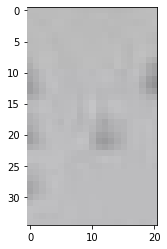

ind:  22
Prediction:  35


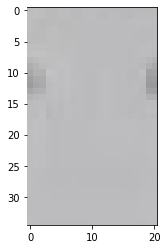

ind:  31
Prediction:  2


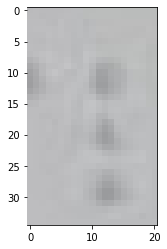

ind:  61
Prediction:  1456


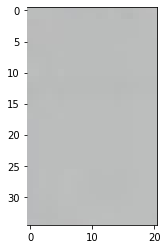

ind:  0
Prediction:  0


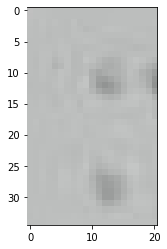

ind:  62
Prediction:  146


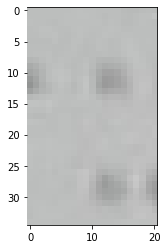

ind:  55
Prediction:  1346


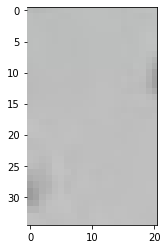

ind:  18
Prediction:  34


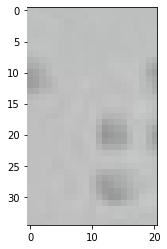

ind:  30
Prediction:  56


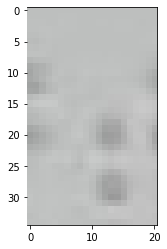

ind:  23
Prediction:  356


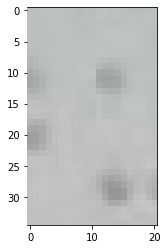

ind:  47
Prediction:  1246


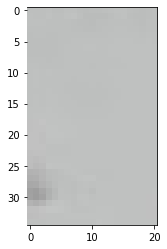

ind:  17
Prediction:  3


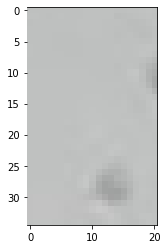

ind:  28
Prediction:  46


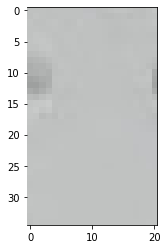

ind:  1
Prediction:  1


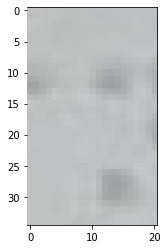

ind:  15
Prediction:  256


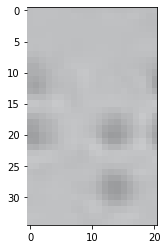

ind:  23
Prediction:  356


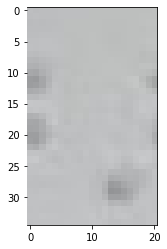

ind:  20
Prediction:  3456


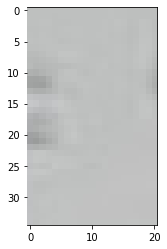

ind:  2
Prediction:  23


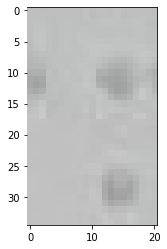

ind:  62
Prediction:  146


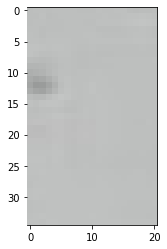

ind:  31
Prediction:  2


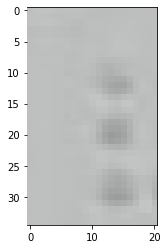

ind:  30
Prediction:  56


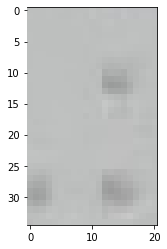

ind:  28
Prediction:  46


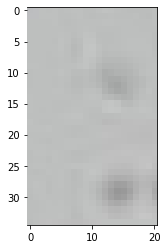

ind:  28
Prediction:  46


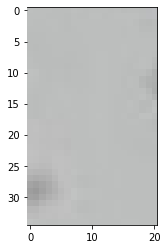

ind:  19
Prediction:  345


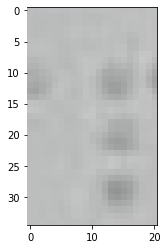

ind:  61
Prediction:  1456


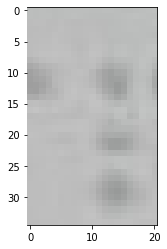

ind:  61
Prediction:  1456


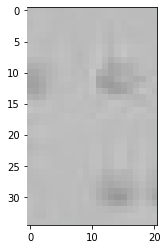

ind:  28
Prediction:  46


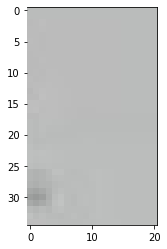

ind:  17
Prediction:  3


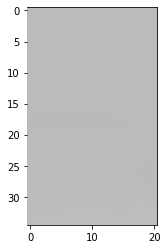

ind:  0
Prediction:  0


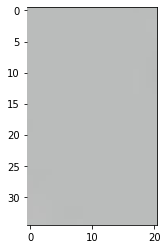

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

71


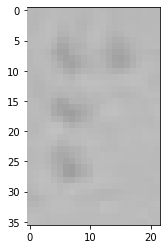

ind:  37
Prediction:  1234


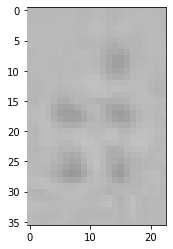

ind:  20
Prediction:  3456


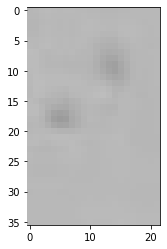

ind:  10
Prediction:  24


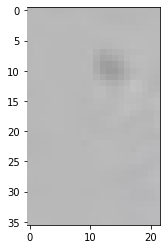

ind:  25
Prediction:  4


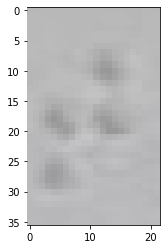

ind:  4
Prediction:  2345


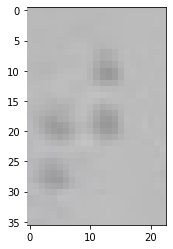

ind:  4
Prediction:  2345


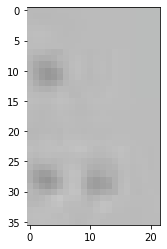

ind:  58
Prediction:  136


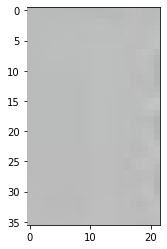

ind:  27
Prediction:  456


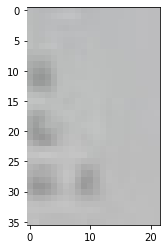

ind:  43
Prediction:  1236


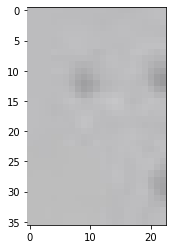

ind:  13
Prediction:  246


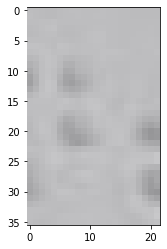

ind:  48
Prediction:  1256


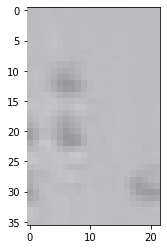

ind:  9
Prediction:  236


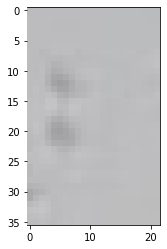

ind:  2
Prediction:  23


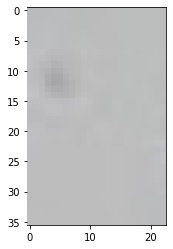

ind:  1
Prediction:  1


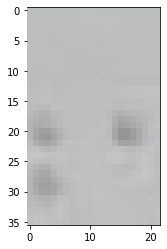

ind:  7
Prediction:  235


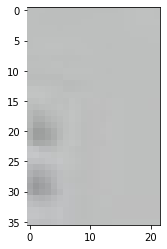

ind:  2
Prediction:  23


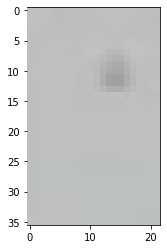

ind:  25
Prediction:  4


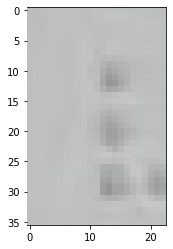

ind:  43
Prediction:  1236


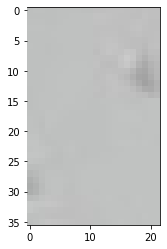

ind:  18
Prediction:  34


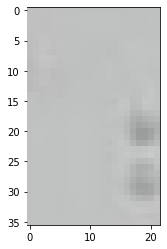

ind:  30
Prediction:  56


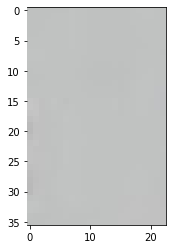

ind:  0
Prediction:  0


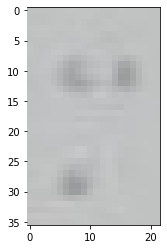

ind:  52
Prediction:  134


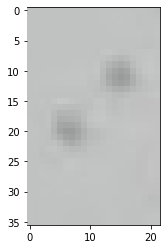

ind:  10
Prediction:  24


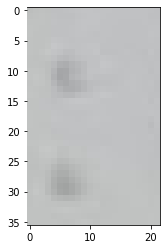

ind:  51
Prediction:  13


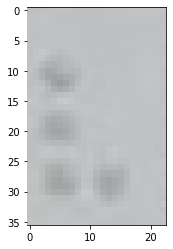

ind:  43
Prediction:  1236


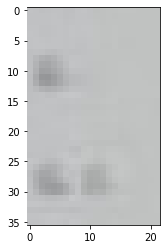

ind:  58
Prediction:  136


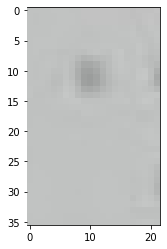

ind:  12
Prediction:  2456


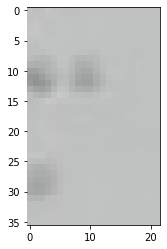

ind:  52
Prediction:  134


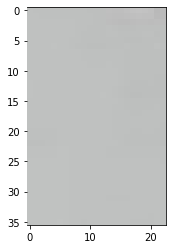

ind:  0
Prediction:  0


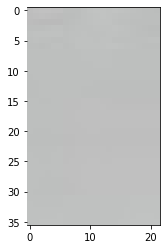

ind:  0
Prediction:  0


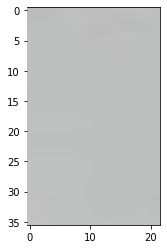

ind:  0
Prediction:  0


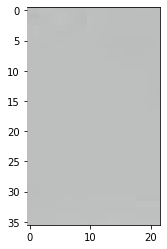

ind:  0
Prediction:  0


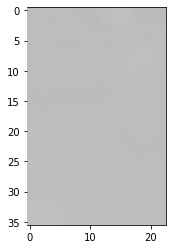

ind:  0
Prediction:  0


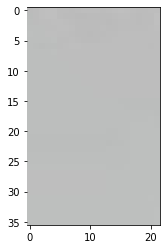

ind:  0
Prediction:  0


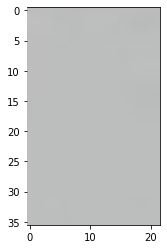

ind:  0
Prediction:  0


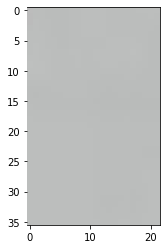

ind:  0
Prediction:  0


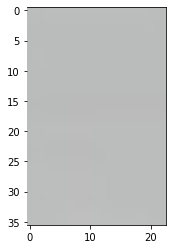

ind:  0
Prediction:  0


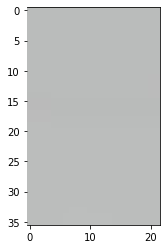

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

98


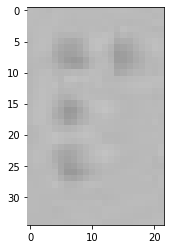

ind:  37
Prediction:  1234


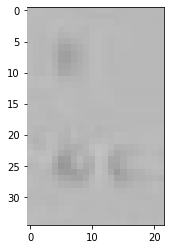

ind:  58
Prediction:  136


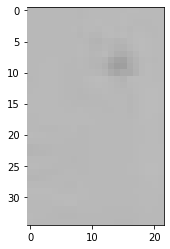

ind:  25
Prediction:  4


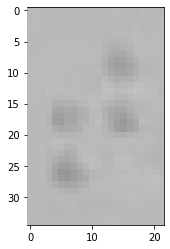

ind:  4
Prediction:  2345


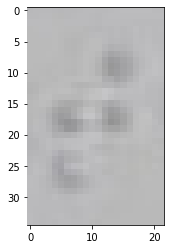

ind:  4
Prediction:  2345


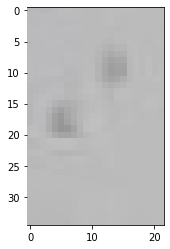

ind:  22
Prediction:  35


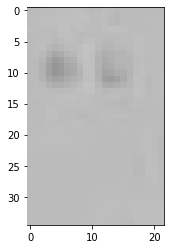

ind:  14
Prediction:  25


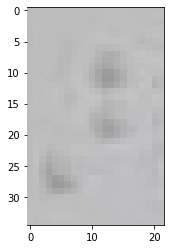

ind:  19
Prediction:  345


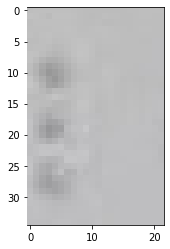

ind:  36
Prediction:  123


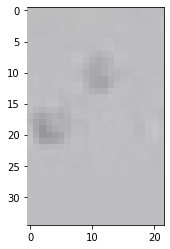

ind:  10
Prediction:  24


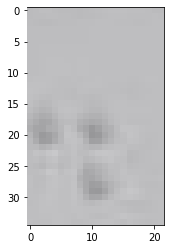

ind:  15
Prediction:  256


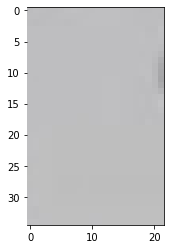

ind:  26
Prediction:  45


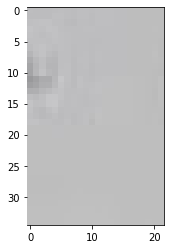

ind:  1
Prediction:  1


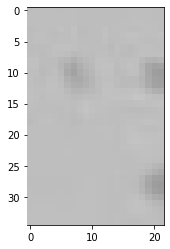

ind:  62
Prediction:  146


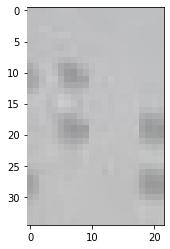

ind:  48
Prediction:  1256


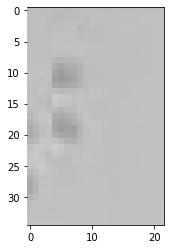

ind:  36
Prediction:  123


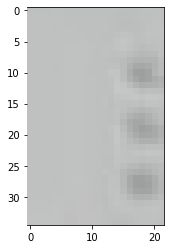

ind:  27
Prediction:  456


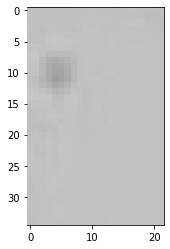

ind:  1
Prediction:  1


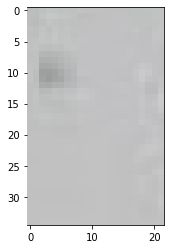

ind:  32
Prediction:  16


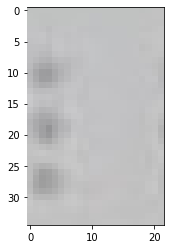

ind:  36
Prediction:  123


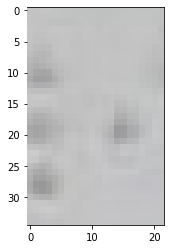

ind:  41
Prediction:  1235


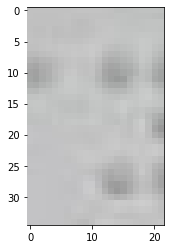

ind:  61
Prediction:  1456


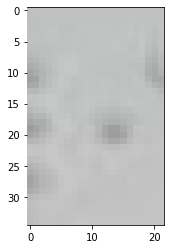

ind:  41
Prediction:  1235


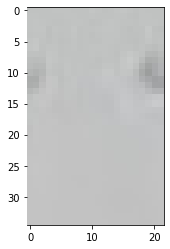

ind:  1
Prediction:  1


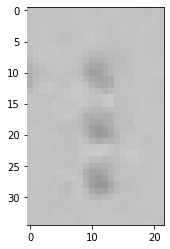

ind:  61
Prediction:  1456


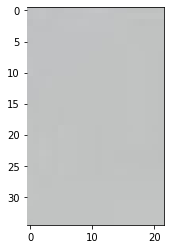

ind:  0
Prediction:  0


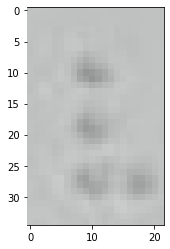

ind:  43
Prediction:  1236


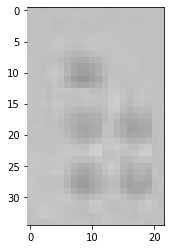

ind:  41
Prediction:  1235


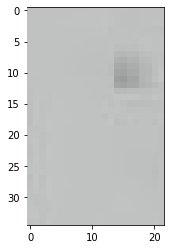

ind:  25
Prediction:  4


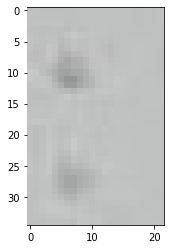

ind:  51
Prediction:  13


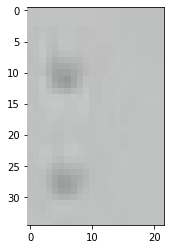

ind:  51
Prediction:  13


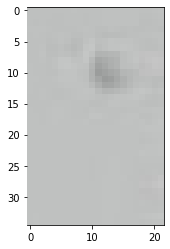

ind:  25
Prediction:  4


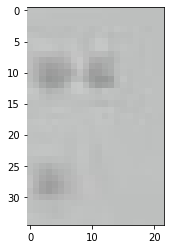

ind:  14
Prediction:  25


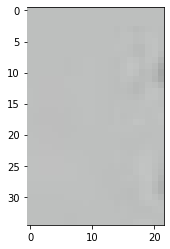

ind:  27
Prediction:  456


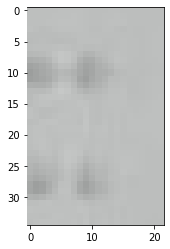

ind:  55
Prediction:  1346


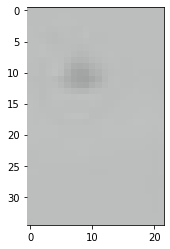

ind:  1
Prediction:  1


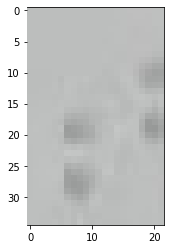

ind:  4
Prediction:  2345


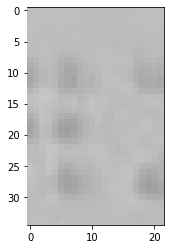

ind:  40
Prediction:  12346


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

73


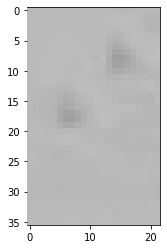

ind:  19
Prediction:  345


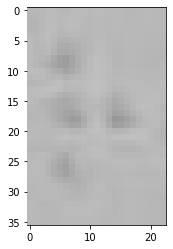

ind:  41
Prediction:  1235


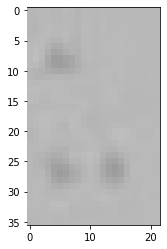

ind:  58
Prediction:  136


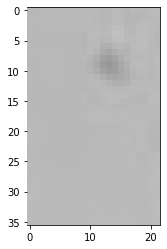

ind:  25
Prediction:  4


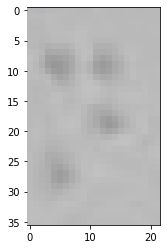

ind:  53
Prediction:  1345


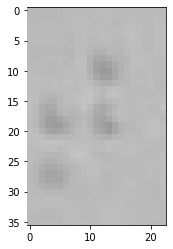

ind:  4
Prediction:  2345


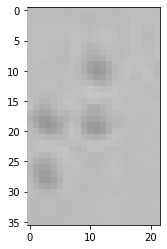

ind:  4
Prediction:  2345


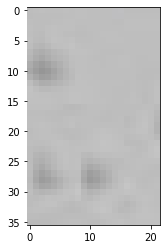

ind:  58
Prediction:  136


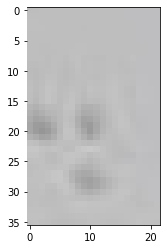

ind:  15
Prediction:  256


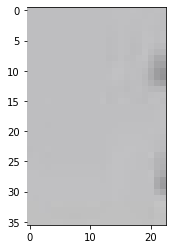

ind:  27
Prediction:  456


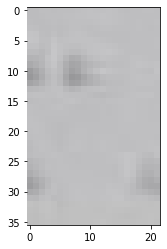

ind:  32
Prediction:  16


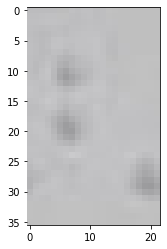

ind:  50
Prediction:  126


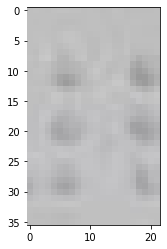

ind:  39
Prediction:  123456


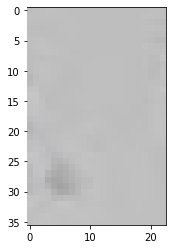

ind:  50
Prediction:  126


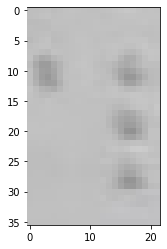

ind:  61
Prediction:  1456


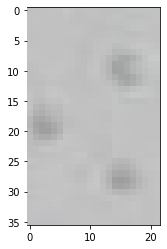

ind:  13
Prediction:  246


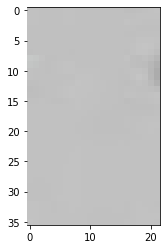

ind:  25
Prediction:  4


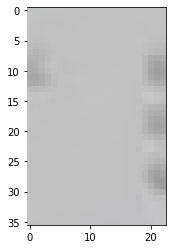

ind:  27
Prediction:  456


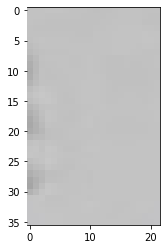

ind:  36
Prediction:  123


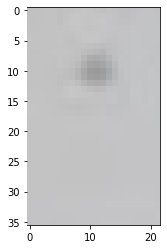

ind:  1
Prediction:  1


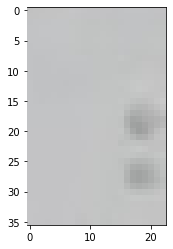

ind:  30
Prediction:  56


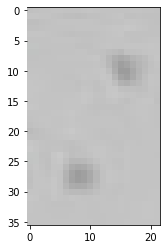

ind:  18
Prediction:  34


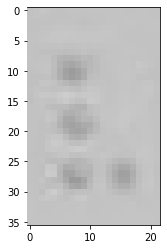

ind:  43
Prediction:  1236


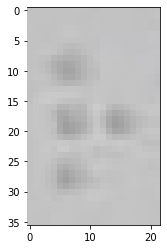

ind:  41
Prediction:  1235


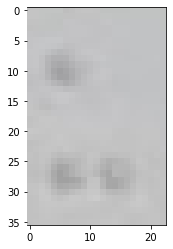

ind:  58
Prediction:  136


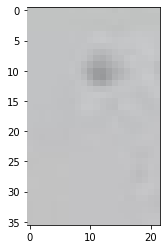

ind:  1
Prediction:  1


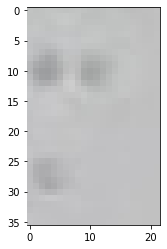

ind:  52
Prediction:  134


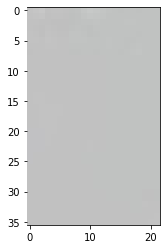

ind:  0
Prediction:  0


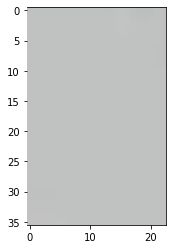

ind:  0
Prediction:  0


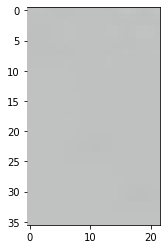

ind:  0
Prediction:  0


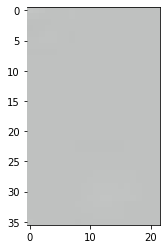

ind:  0
Prediction:  0


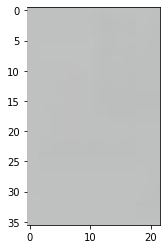

ind:  0
Prediction:  0


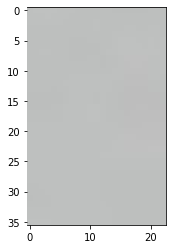

ind:  0
Prediction:  0


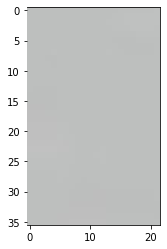

ind:  0
Prediction:  0


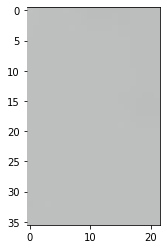

ind:  0
Prediction:  0


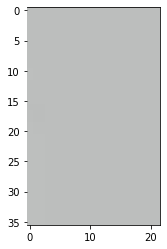

ind:  0
Prediction:  0


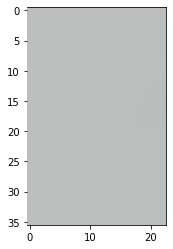

ind:  0
Prediction:  0


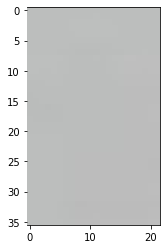

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

62


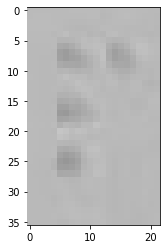

ind:  37
Prediction:  1234


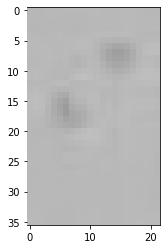

ind:  10
Prediction:  24


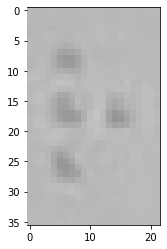

ind:  41
Prediction:  1235


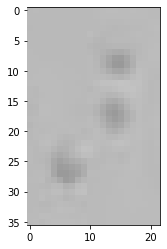

ind:  19
Prediction:  345


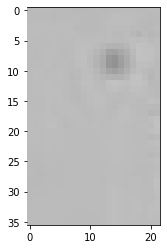

ind:  29
Prediction:  5


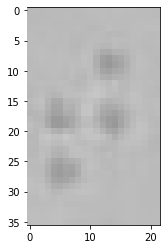

ind:  4
Prediction:  2345


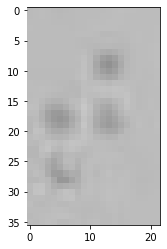

ind:  4
Prediction:  2345


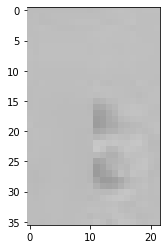

ind:  30
Prediction:  56


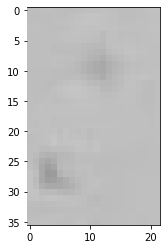

ind:  19
Prediction:  345


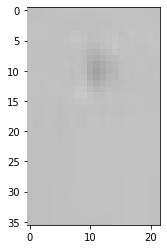

ind:  29
Prediction:  5


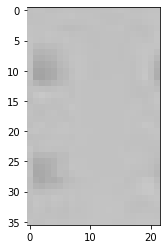

ind:  27
Prediction:  456


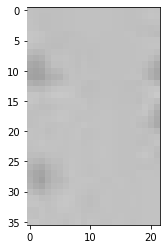

ind:  51
Prediction:  13


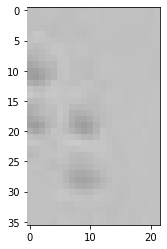

ind:  48
Prediction:  1256


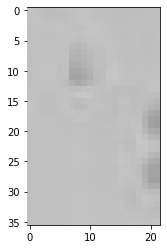

ind:  30
Prediction:  56


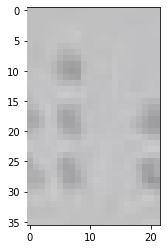

ind:  39
Prediction:  123456


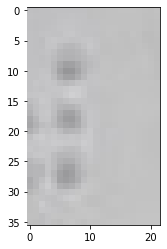

ind:  36
Prediction:  123


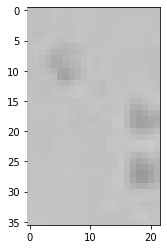

ind:  33
Prediction:  156


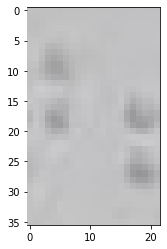

ind:  30
Prediction:  56


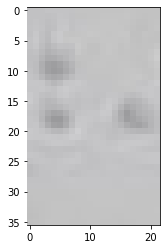

ind:  34
Prediction:  125


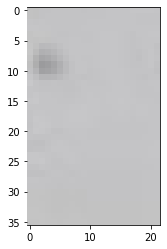

ind:  1
Prediction:  1


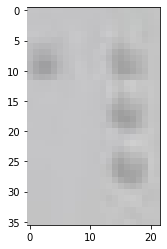

ind:  27
Prediction:  456


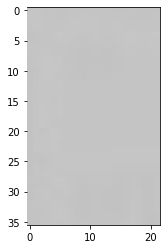

ind:  0
Prediction:  0


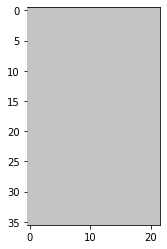

ind:  0
Prediction:  0


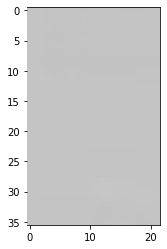

ind:  0
Prediction:  0


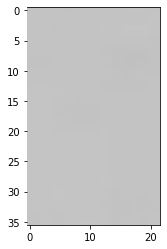

ind:  0
Prediction:  0


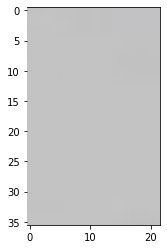

ind:  63
Prediction:  6


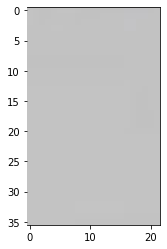

ind:  0
Prediction:  0


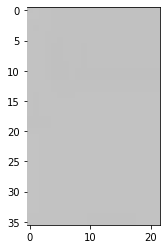

ind:  0
Prediction:  0


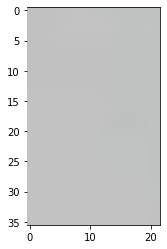

ind:  0
Prediction:  0


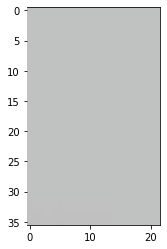

ind:  0
Prediction:  0


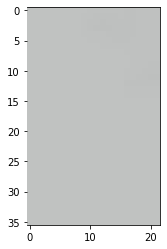

ind:  0
Prediction:  0


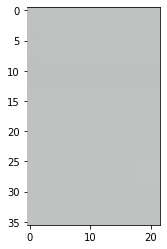

ind:  0
Prediction:  0


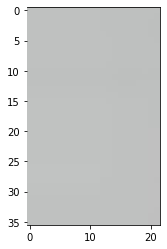

ind:  0
Prediction:  0


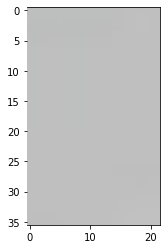

ind:  0
Prediction:  0


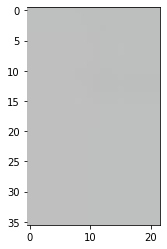

ind:  0
Prediction:  0


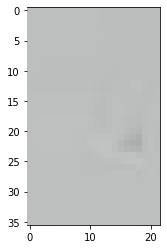

ind:  63
Prediction:  6


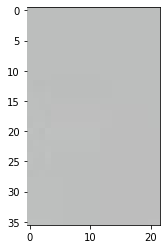

ind:  0
Prediction:  0


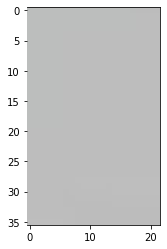

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

72


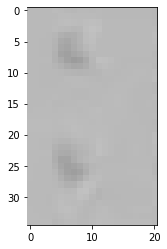

ind:  36
Prediction:  123


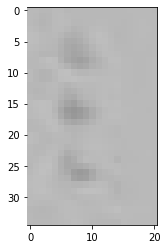

ind:  36
Prediction:  123


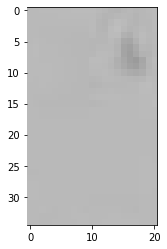

ind:  25
Prediction:  4


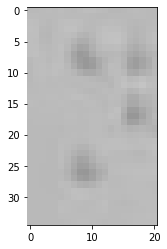

ind:  53
Prediction:  1345


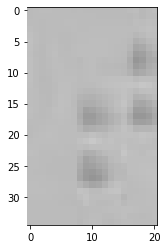

ind:  19
Prediction:  345


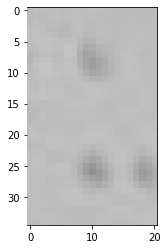

ind:  58
Prediction:  136


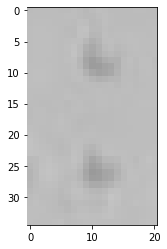

ind:  28
Prediction:  46


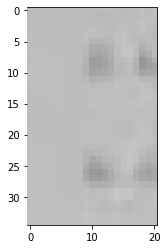

ind:  55
Prediction:  1346


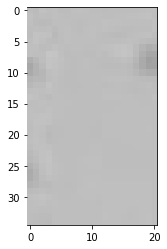

ind:  3
Prediction:  234


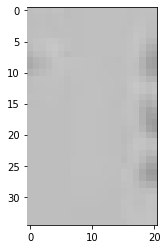

ind:  27
Prediction:  456


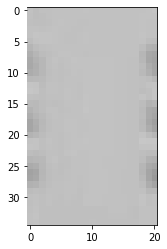

ind:  27
Prediction:  456


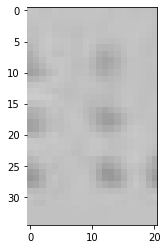

ind:  39
Prediction:  123456


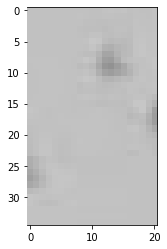

ind:  49
Prediction:  15


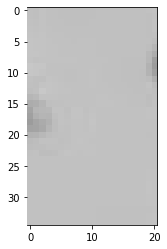

ind:  31
Prediction:  2


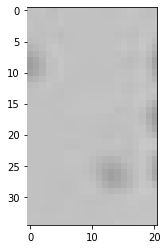

ind:  20
Prediction:  3456


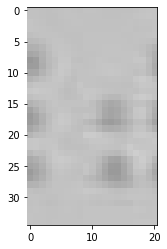

ind:  39
Prediction:  123456


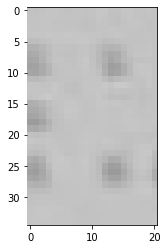

ind:  40
Prediction:  12346


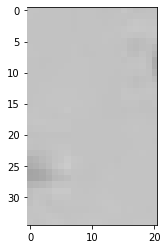

ind:  17
Prediction:  3


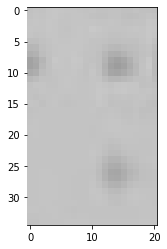

ind:  62
Prediction:  146


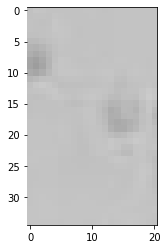

ind:  49
Prediction:  15


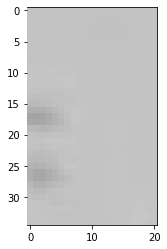

ind:  2
Prediction:  23


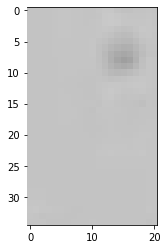

ind:  25
Prediction:  4


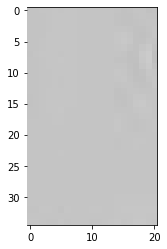

ind:  0
Prediction:  0


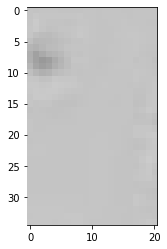

ind:  31
Prediction:  2


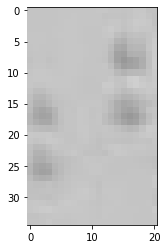

ind:  4
Prediction:  2345


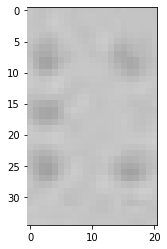

ind:  39
Prediction:  123456


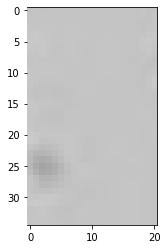

ind:  19
Prediction:  345


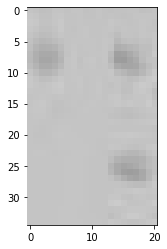

ind:  62
Prediction:  146


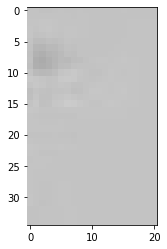

ind:  31
Prediction:  2


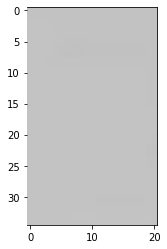

ind:  0
Prediction:  0


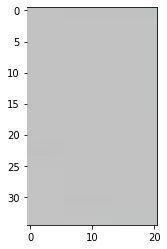

ind:  0
Prediction:  0


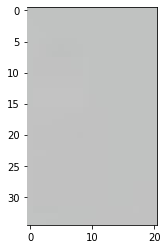

ind:  0
Prediction:  0


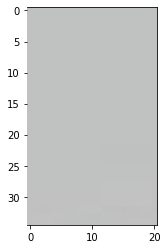

ind:  0
Prediction:  0


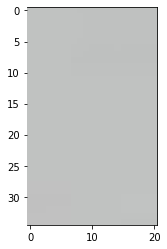

ind:  0
Prediction:  0


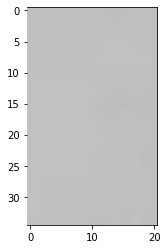

ind:  0
Prediction:  0


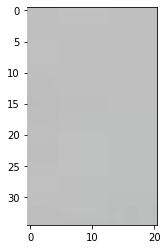

ind:  0
Prediction:  0


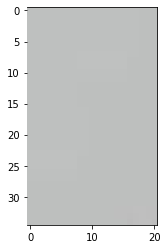

ind:  0
Prediction:  0


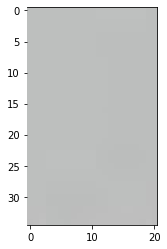

ind:  0
Prediction:  0


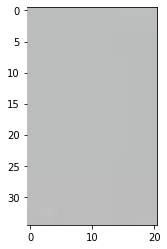

ind:  0
Prediction:  0


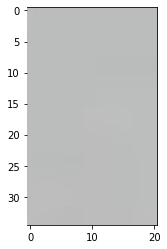

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

108


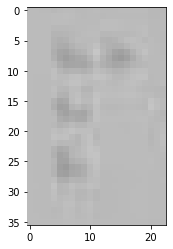

ind:  37
Prediction:  1234


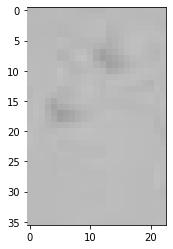

ind:  10
Prediction:  24


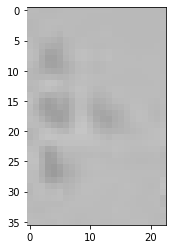

ind:  41
Prediction:  1235


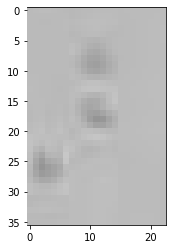

ind:  20
Prediction:  3456


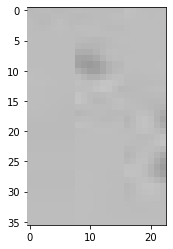

ind:  33
Prediction:  156


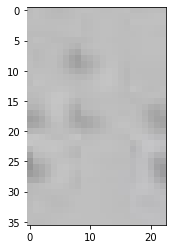

ind:  48
Prediction:  1256


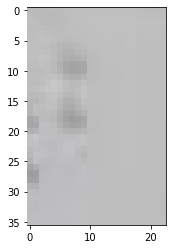

ind:  4
Prediction:  2345


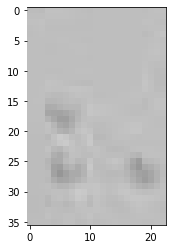

ind:  48
Prediction:  1256


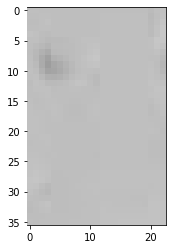

ind:  51
Prediction:  13


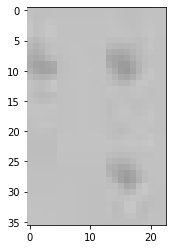

ind:  62
Prediction:  146


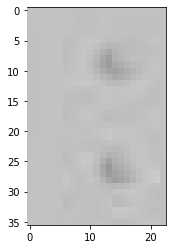

ind:  28
Prediction:  46


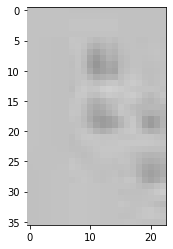

ind:  48
Prediction:  1256


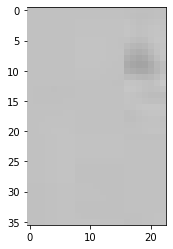

ind:  25
Prediction:  4


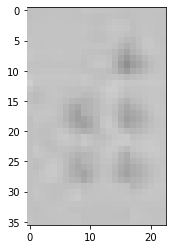

ind:  5
Prediction:  23456


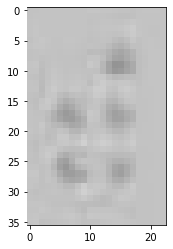

ind:  20
Prediction:  3456


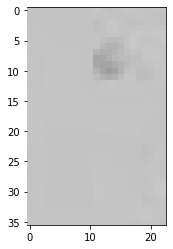

ind:  25
Prediction:  4


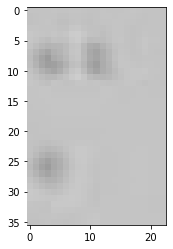

ind:  52
Prediction:  134


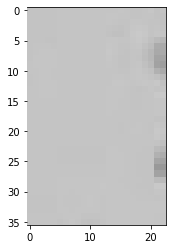

ind:  28
Prediction:  46


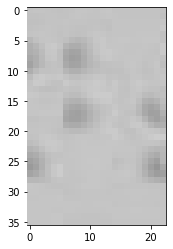

ind:  48
Prediction:  1256


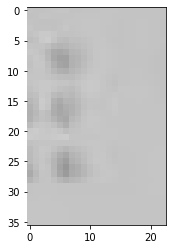

ind:  36
Prediction:  123


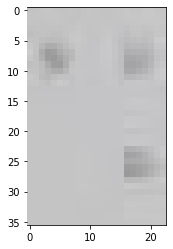

ind:  62
Prediction:  146


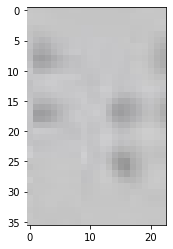

ind:  48
Prediction:  1256


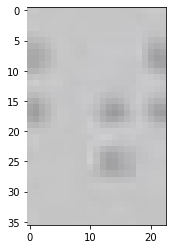

ind:  30
Prediction:  56


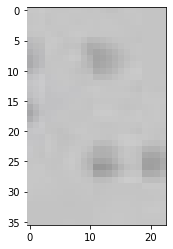

ind:  47
Prediction:  1246


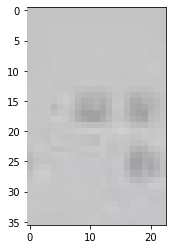

ind:  15
Prediction:  256


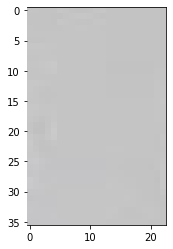

ind:  0
Prediction:  0


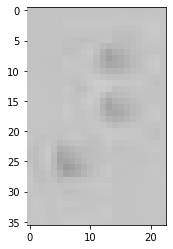

ind:  19
Prediction:  345


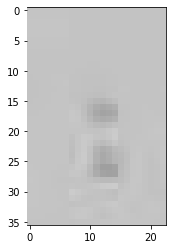

ind:  30
Prediction:  56


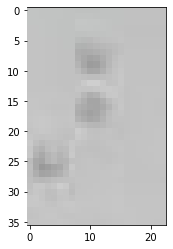

ind:  19
Prediction:  345


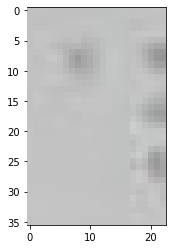

ind:  61
Prediction:  1456


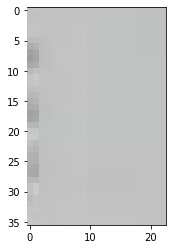

ind:  36
Prediction:  123


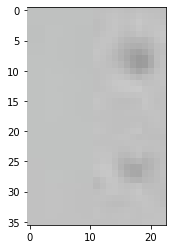

ind:  28
Prediction:  46


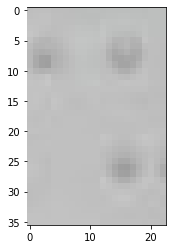

ind:  62
Prediction:  146


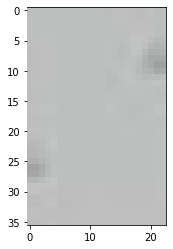

ind:  17
Prediction:  3


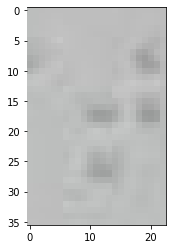

ind:  4
Prediction:  2345


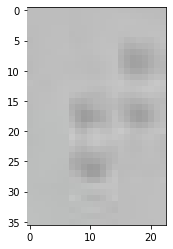

ind:  4
Prediction:  2345


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

82


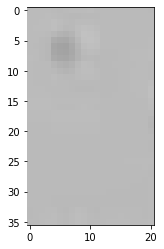

ind:  1
Prediction:  1


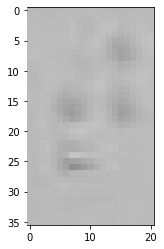

ind:  4
Prediction:  2345


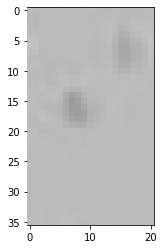

ind:  56
Prediction:  135


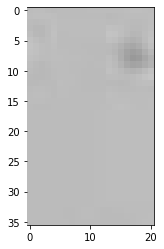

ind:  25
Prediction:  4


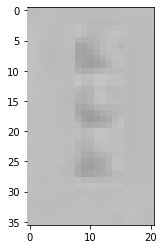

ind:  27
Prediction:  456


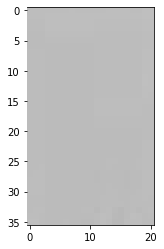

ind:  63
Prediction:  6


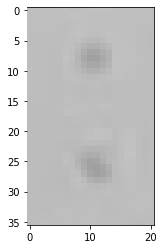

ind:  28
Prediction:  46


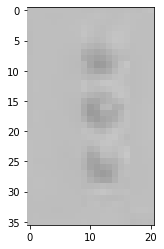

ind:  27
Prediction:  456


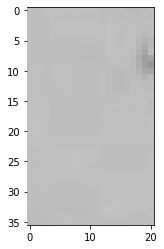

ind:  25
Prediction:  4


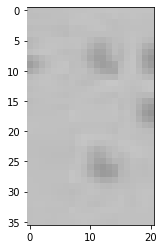

ind:  53
Prediction:  1345


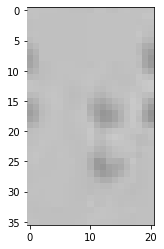

ind:  48
Prediction:  1256


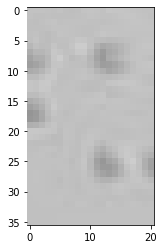

ind:  47
Prediction:  1246


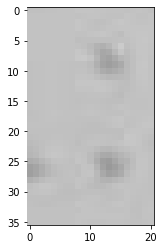

ind:  28
Prediction:  46


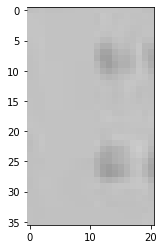

ind:  28
Prediction:  46


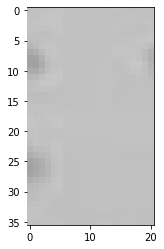

ind:  51
Prediction:  13


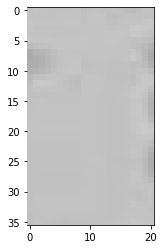

ind:  27
Prediction:  456


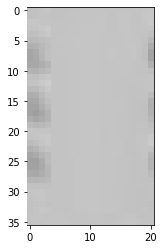

ind:  27
Prediction:  456


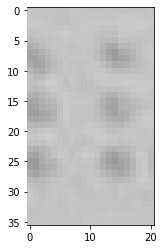

ind:  39
Prediction:  123456


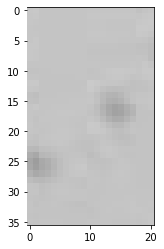

ind:  22
Prediction:  35


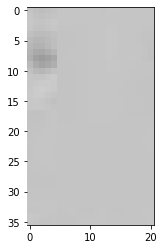

ind:  35
Prediction:  12


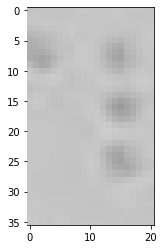

ind:  61
Prediction:  1456


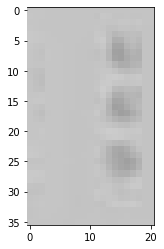

ind:  27
Prediction:  456


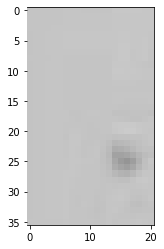

ind:  29
Prediction:  5


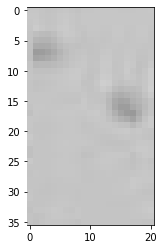

ind:  49
Prediction:  15


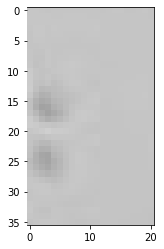

ind:  2
Prediction:  23


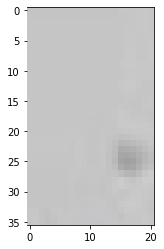

ind:  29
Prediction:  5


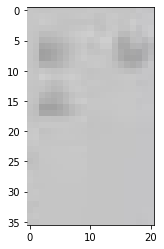

ind:  44
Prediction:  124


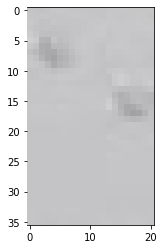

ind:  49
Prediction:  15


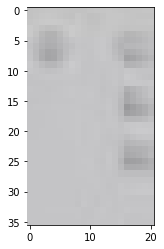

ind:  61
Prediction:  1456


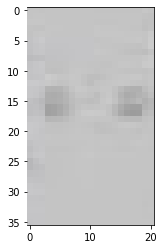

ind:  14
Prediction:  25


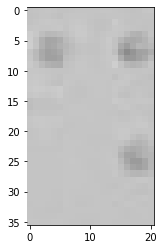

ind:  62
Prediction:  146


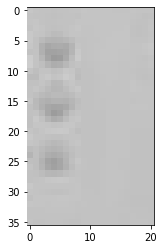

ind:  36
Prediction:  123


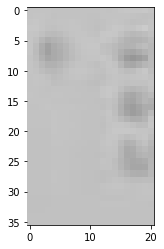

ind:  61
Prediction:  1456


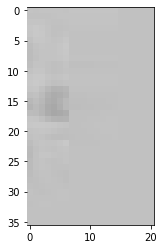

ind:  31
Prediction:  2


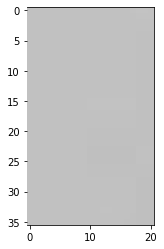

ind:  0
Prediction:  0


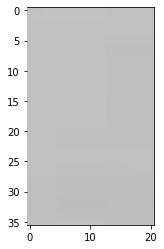

ind:  0
Prediction:  0


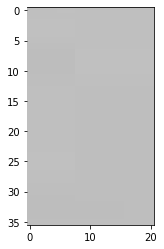

ind:  0
Prediction:  0


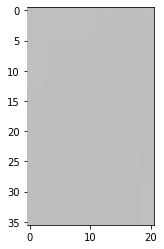

ind:  0
Prediction:  0


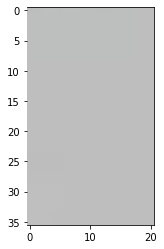

ind:  0
Prediction:  0


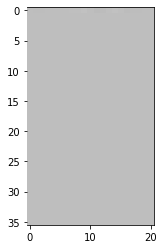

ind:  25
Prediction:  4


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

85


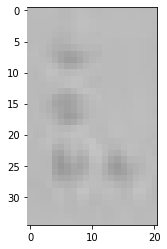

ind:  43
Prediction:  1236


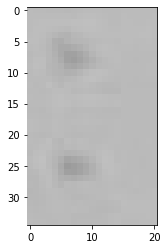

ind:  51
Prediction:  13


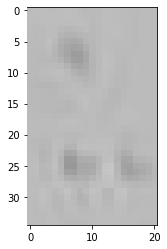

ind:  58
Prediction:  136


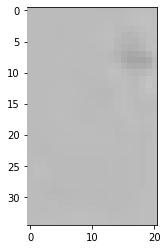

ind:  25
Prediction:  4


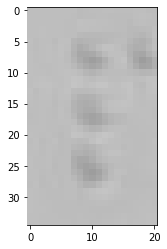

ind:  37
Prediction:  1234


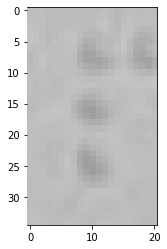

ind:  37
Prediction:  1234


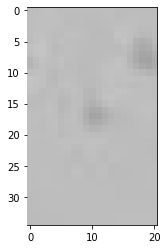

ind:  19
Prediction:  345


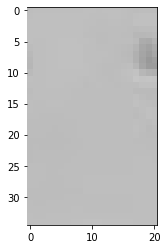

ind:  25
Prediction:  4


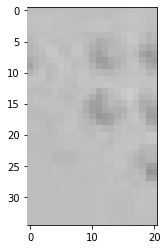

ind:  61
Prediction:  1456


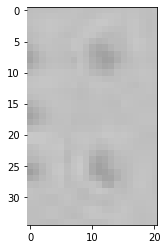

ind:  40
Prediction:  12346


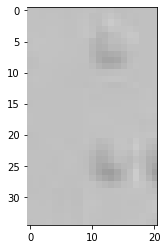

ind:  28
Prediction:  46


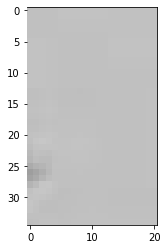

ind:  17
Prediction:  3


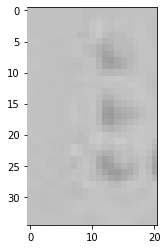

ind:  27
Prediction:  456


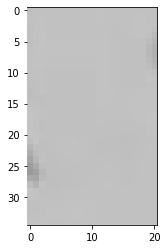

ind:  18
Prediction:  34


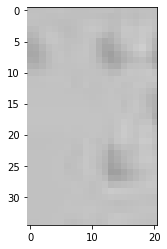

ind:  61
Prediction:  1456


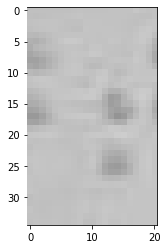

ind:  30
Prediction:  56


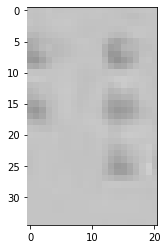

ind:  39
Prediction:  123456


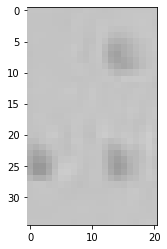

ind:  11
Prediction:  245


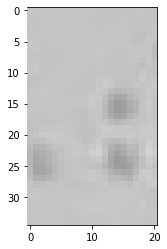

ind:  23
Prediction:  356


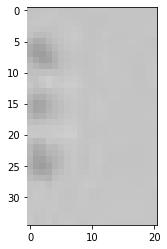

ind:  36
Prediction:  123


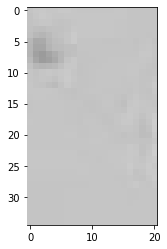

ind:  31
Prediction:  2


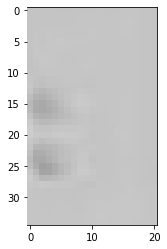

ind:  2
Prediction:  23


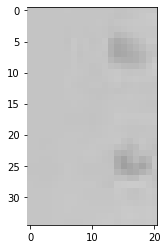

ind:  28
Prediction:  46


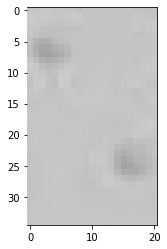

ind:  32
Prediction:  16


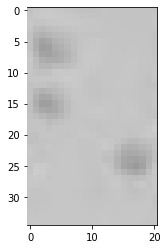

ind:  50
Prediction:  126


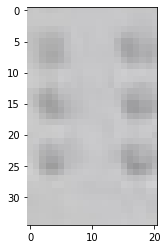

ind:  39
Prediction:  123456


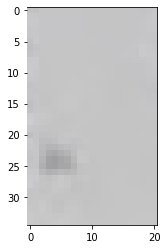

ind:  50
Prediction:  126


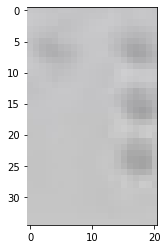

ind:  61
Prediction:  1456


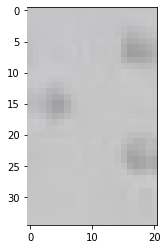

ind:  13
Prediction:  246


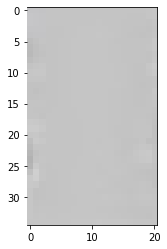

ind:  36
Prediction:  123


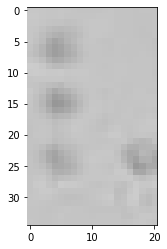

ind:  43
Prediction:  1236


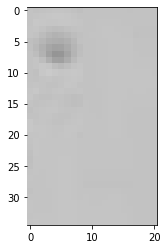

ind:  1
Prediction:  1


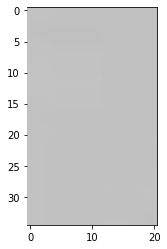

ind:  0
Prediction:  0


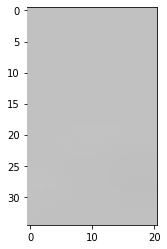

ind:  0
Prediction:  0


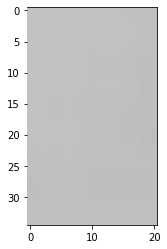

ind:  0
Prediction:  0


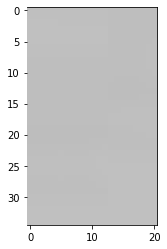

ind:  0
Prediction:  0


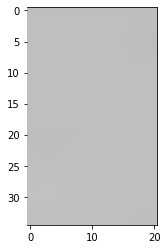

ind:  0
Prediction:  0


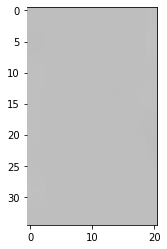

ind:  0
Prediction:  0


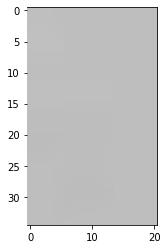

ind:  0
Prediction:  0


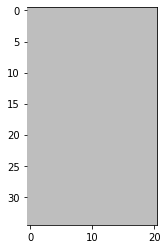

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

48


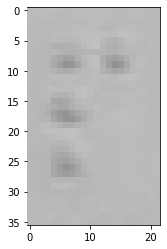

ind:  37
Prediction:  1234


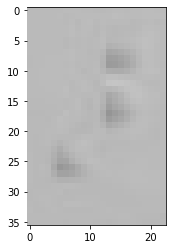

ind:  19
Prediction:  345


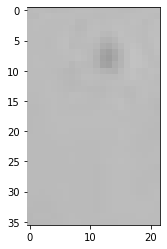

ind:  25
Prediction:  4


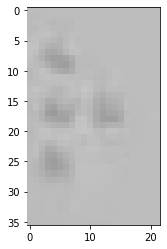

ind:  41
Prediction:  1235


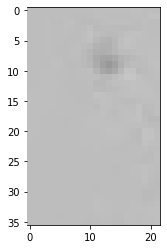

ind:  25
Prediction:  4


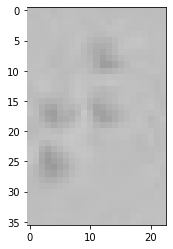

ind:  4
Prediction:  2345


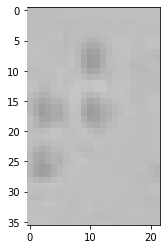

ind:  4
Prediction:  2345


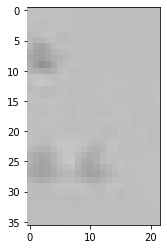

ind:  58
Prediction:  136


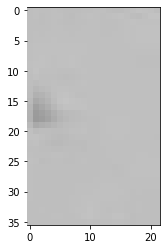

ind:  31
Prediction:  2


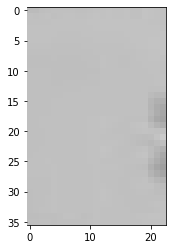

ind:  30
Prediction:  56


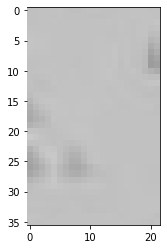

ind:  18
Prediction:  34


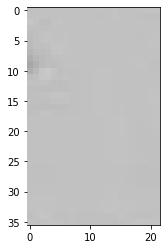

ind:  1
Prediction:  1


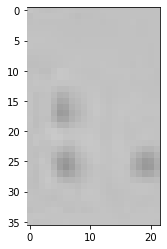

ind:  9
Prediction:  236


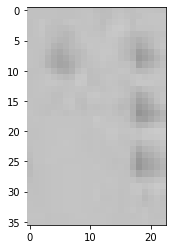

ind:  61
Prediction:  1456


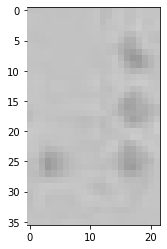

ind:  20
Prediction:  3456


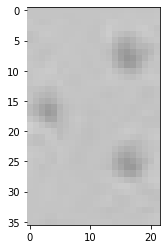

ind:  13
Prediction:  246


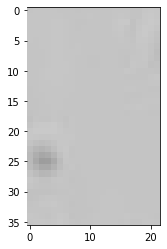

ind:  17
Prediction:  3


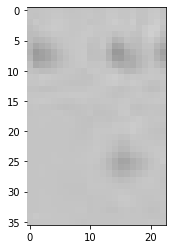

ind:  62
Prediction:  146


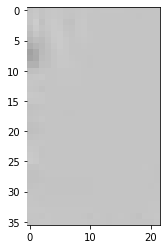

ind:  36
Prediction:  123


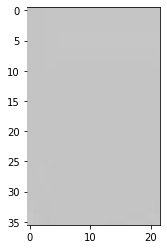

ind:  0
Prediction:  0


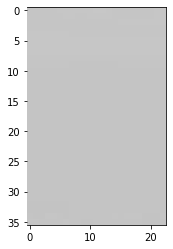

ind:  0
Prediction:  0


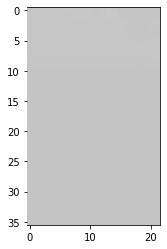

ind:  0
Prediction:  0


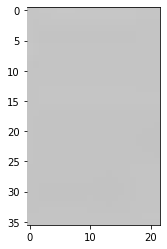

ind:  0
Prediction:  0


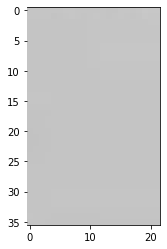

ind:  0
Prediction:  0


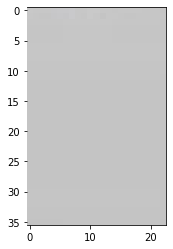

ind:  0
Prediction:  0


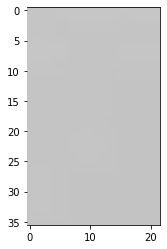

ind:  0
Prediction:  0


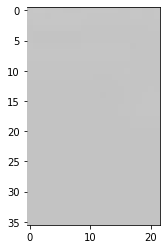

ind:  0
Prediction:  0


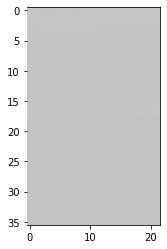

ind:  0
Prediction:  0


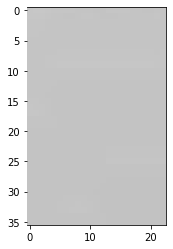

ind:  0
Prediction:  0


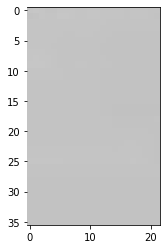

ind:  0
Prediction:  0


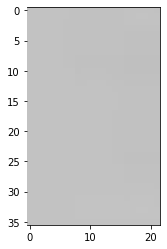

ind:  0
Prediction:  0


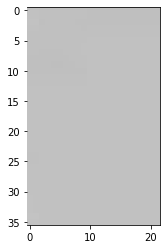

ind:  0
Prediction:  0


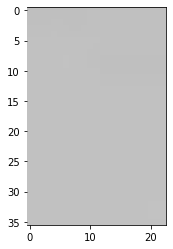

ind:  0
Prediction:  0


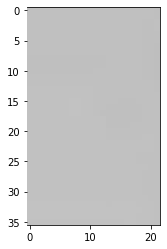

ind:  0
Prediction:  0


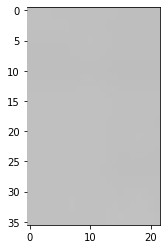

ind:  0
Prediction:  0


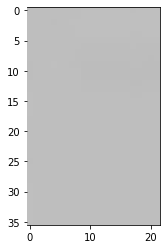

ind:  0
Prediction:  0


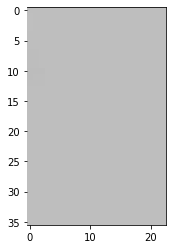

ind:  0
Prediction:  0


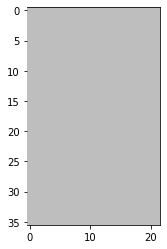

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

61


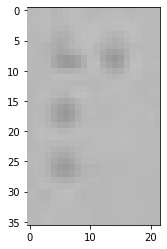

ind:  37
Prediction:  1234


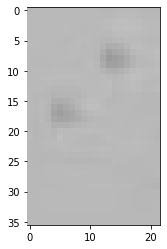

ind:  19
Prediction:  345


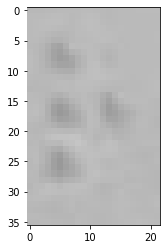

ind:  41
Prediction:  1235


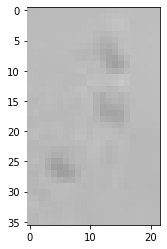

ind:  19
Prediction:  345


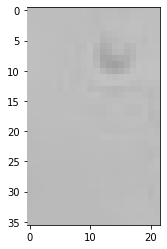

ind:  25
Prediction:  4


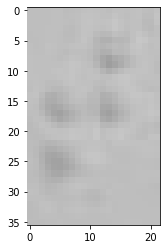

ind:  4
Prediction:  2345


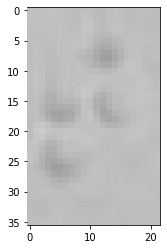

ind:  4
Prediction:  2345


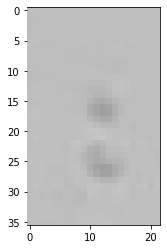

ind:  30
Prediction:  56


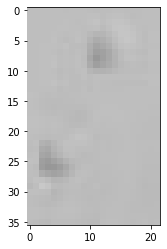

ind:  19
Prediction:  345


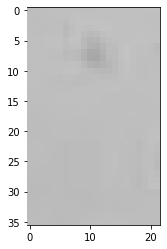

ind:  1
Prediction:  1


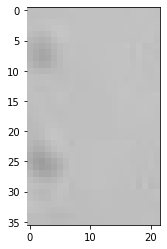

ind:  36
Prediction:  123


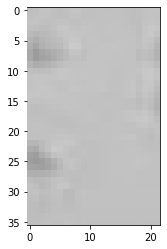

ind:  51
Prediction:  13


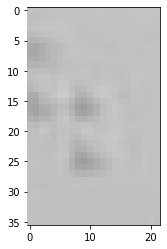

ind:  48
Prediction:  1256


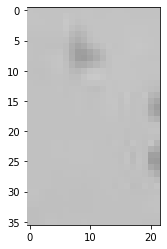

ind:  33
Prediction:  156


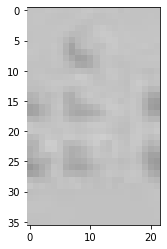

ind:  39
Prediction:  123456


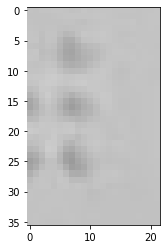

ind:  20
Prediction:  3456


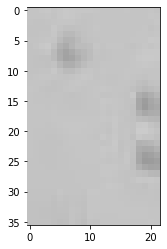

ind:  30
Prediction:  56


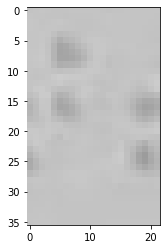

ind:  30
Prediction:  56


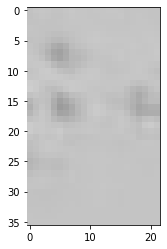

ind:  34
Prediction:  125


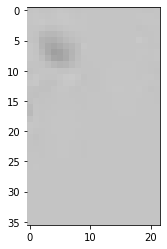

ind:  1
Prediction:  1


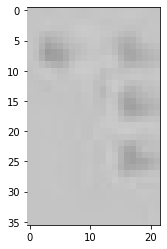

ind:  61
Prediction:  1456


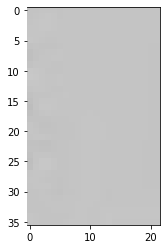

ind:  36
Prediction:  123


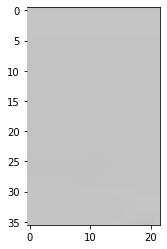

ind:  0
Prediction:  0


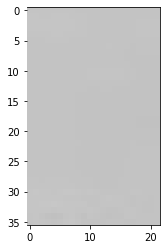

ind:  17
Prediction:  3


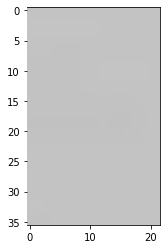

ind:  0
Prediction:  0


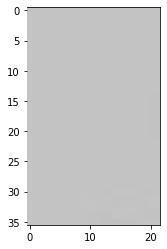

ind:  63
Prediction:  6


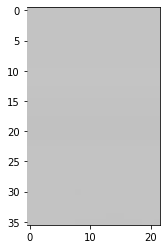

ind:  0
Prediction:  0


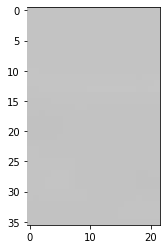

ind:  0
Prediction:  0


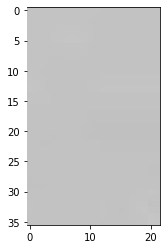

ind:  0
Prediction:  0


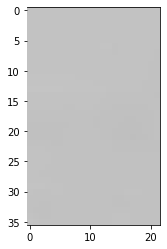

ind:  0
Prediction:  0


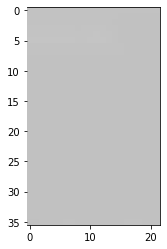

ind:  0
Prediction:  0


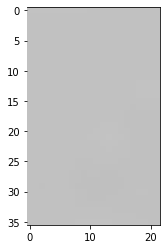

ind:  0
Prediction:  0


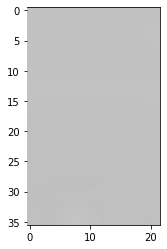

ind:  17
Prediction:  3


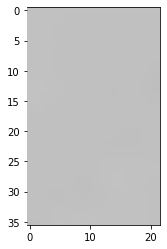

ind:  0
Prediction:  0


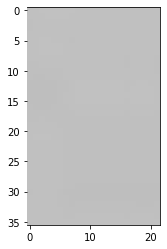

ind:  0
Prediction:  0


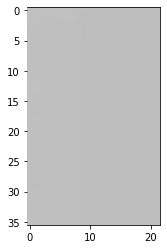

ind:  0
Prediction:  0


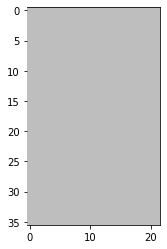

ind:  0
Prediction:  0


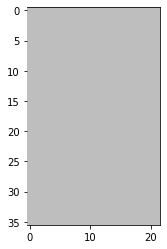

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

93


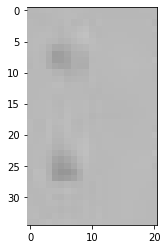

ind:  51
Prediction:  13


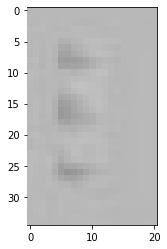

ind:  36
Prediction:  123


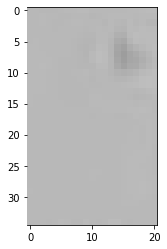

ind:  25
Prediction:  4


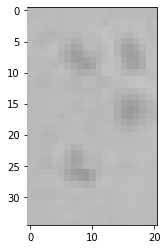

ind:  53
Prediction:  1345


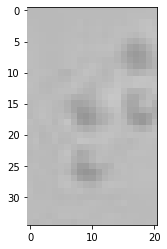

ind:  4
Prediction:  2345


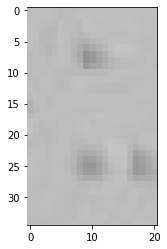

ind:  58
Prediction:  136


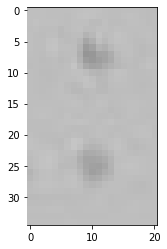

ind:  28
Prediction:  46


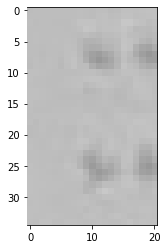

ind:  55
Prediction:  1346


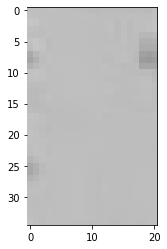

ind:  25
Prediction:  4


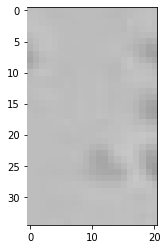

ind:  20
Prediction:  3456


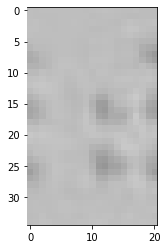

ind:  39
Prediction:  123456


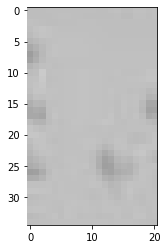

ind:  19
Prediction:  345


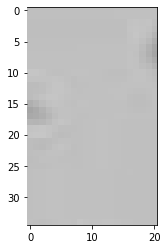

ind:  31
Prediction:  2


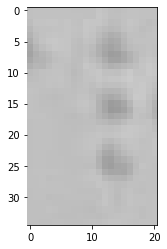

ind:  61
Prediction:  1456


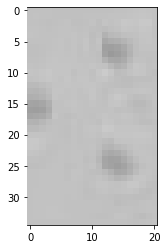

ind:  13
Prediction:  246


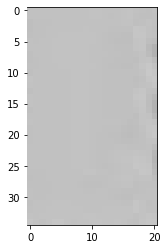

ind:  27
Prediction:  456


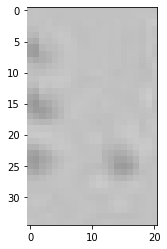

ind:  43
Prediction:  1236


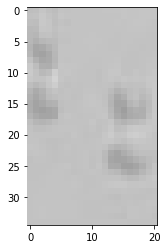

ind:  30
Prediction:  56


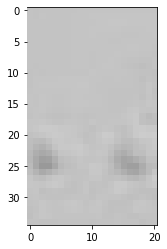

ind:  14
Prediction:  25


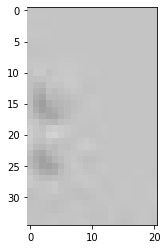

ind:  2
Prediction:  23


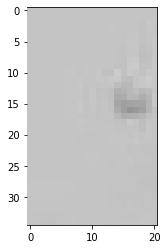

ind:  29
Prediction:  5


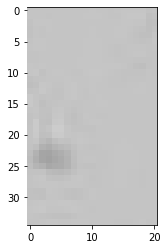

ind:  31
Prediction:  2


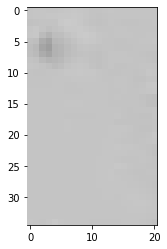

ind:  1
Prediction:  1


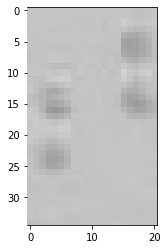

ind:  2
Prediction:  23


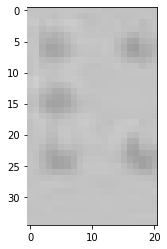

ind:  40
Prediction:  12346


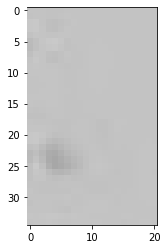

ind:  51
Prediction:  13


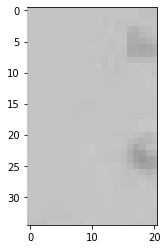

ind:  28
Prediction:  46


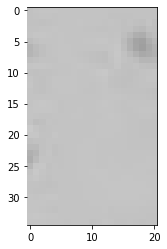

ind:  25
Prediction:  4


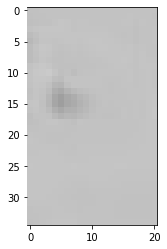

ind:  31
Prediction:  2


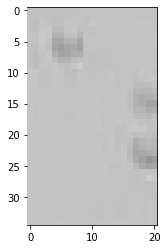

ind:  33
Prediction:  156


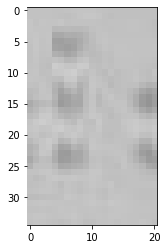

ind:  30
Prediction:  56


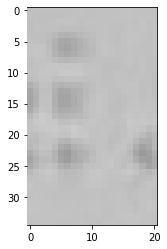

ind:  48
Prediction:  1256


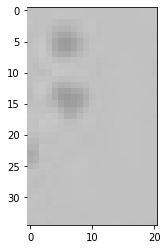

ind:  35
Prediction:  12


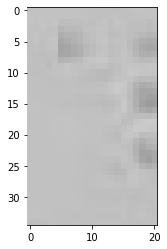

ind:  61
Prediction:  1456


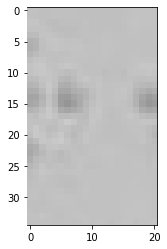

ind:  34
Prediction:  125


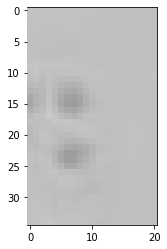

ind:  2
Prediction:  23


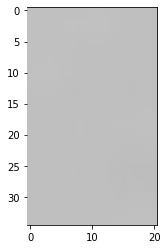

ind:  0
Prediction:  0


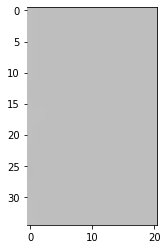

ind:  0
Prediction:  0


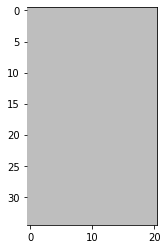

ind:  0
Prediction:  0


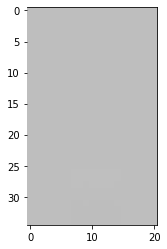

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

82


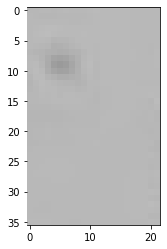

ind:  1
Prediction:  1


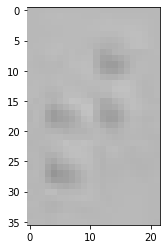

ind:  4
Prediction:  2345


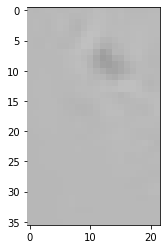

ind:  25
Prediction:  4


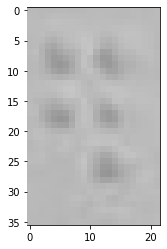

ind:  46
Prediction:  12456


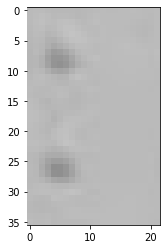

ind:  36
Prediction:  123


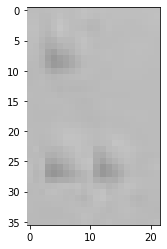

ind:  58
Prediction:  136


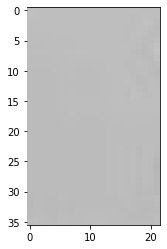

ind:  0
Prediction:  0


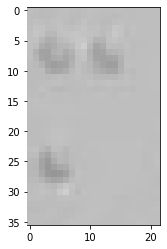

ind:  52
Prediction:  134


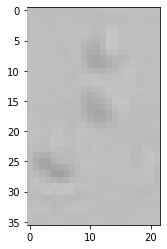

ind:  19
Prediction:  345


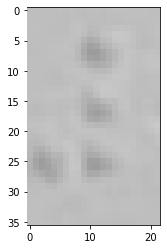

ind:  20
Prediction:  3456


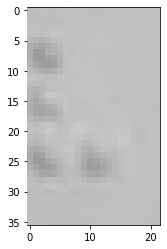

ind:  43
Prediction:  1236


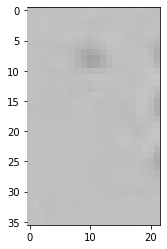

ind:  61
Prediction:  1456


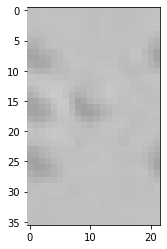

ind:  47
Prediction:  1246


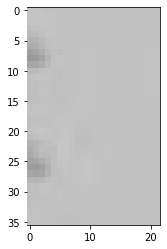

ind:  51
Prediction:  13


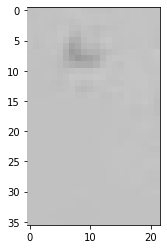

ind:  1
Prediction:  1


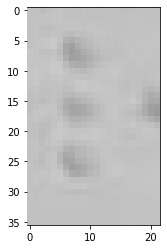

ind:  41
Prediction:  1235


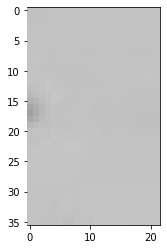

ind:  31
Prediction:  2


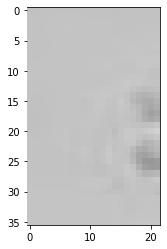

ind:  30
Prediction:  56


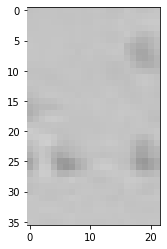

ind:  21
Prediction:  346


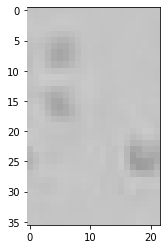

ind:  50
Prediction:  126


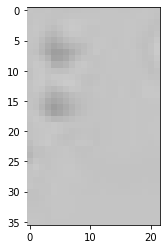

ind:  35
Prediction:  12


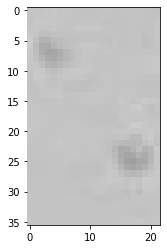

ind:  32
Prediction:  16


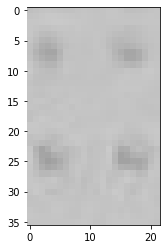

ind:  46
Prediction:  12456


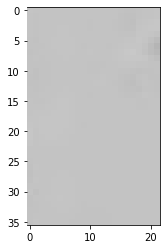

ind:  25
Prediction:  4


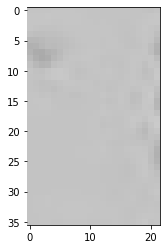

ind:  27
Prediction:  456


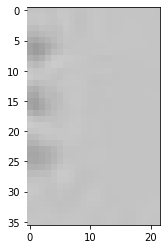

ind:  36
Prediction:  123


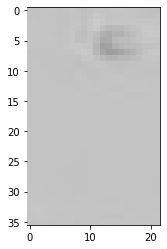

ind:  25
Prediction:  4


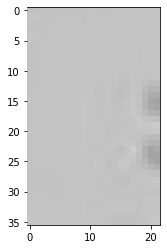

ind:  30
Prediction:  56


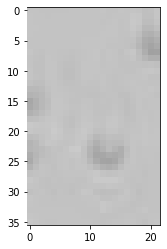

ind:  34
Prediction:  125


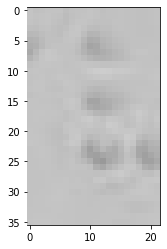

ind:  61
Prediction:  1456


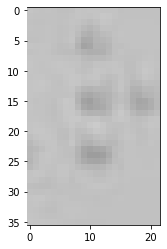

ind:  41
Prediction:  1235


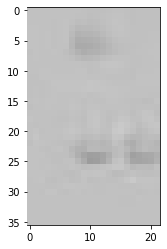

ind:  58
Prediction:  136


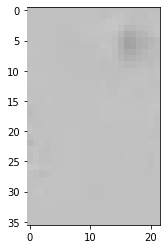

ind:  25
Prediction:  4


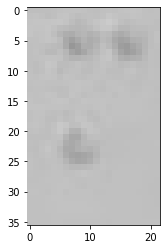

ind:  52
Prediction:  134


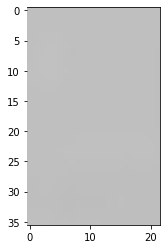

ind:  0
Prediction:  0


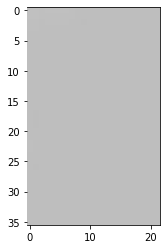

ind:  0
Prediction:  0


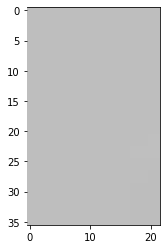

ind:  0
Prediction:  0


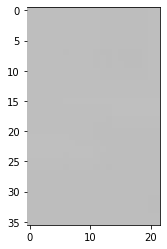

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

83


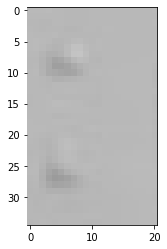

ind:  51
Prediction:  13


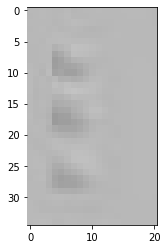

ind:  36
Prediction:  123


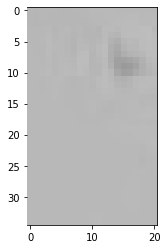

ind:  25
Prediction:  4


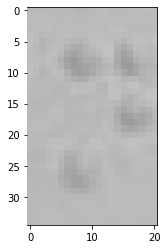

ind:  53
Prediction:  1345


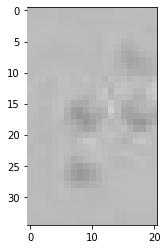

ind:  4
Prediction:  2345


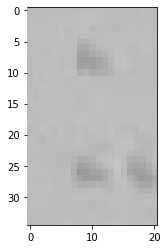

ind:  58
Prediction:  136


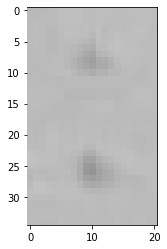

ind:  51
Prediction:  13


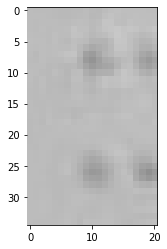

ind:  55
Prediction:  1346


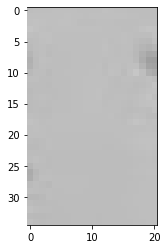

ind:  25
Prediction:  4


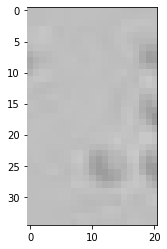

ind:  20
Prediction:  3456


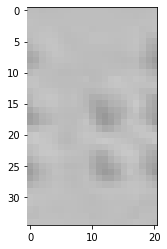

ind:  39
Prediction:  123456


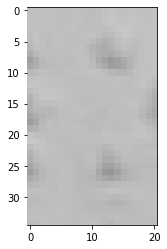

ind:  39
Prediction:  123456


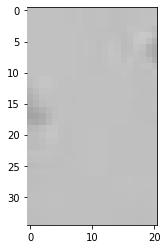

ind:  31
Prediction:  2


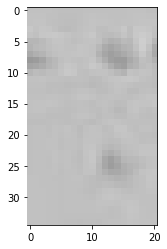

ind:  62
Prediction:  146


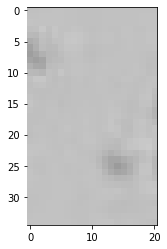

ind:  32
Prediction:  16


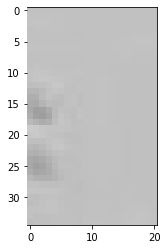

ind:  2
Prediction:  23


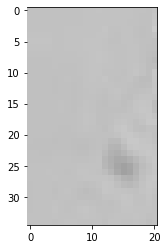

ind:  32
Prediction:  16


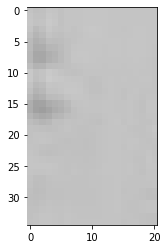

ind:  35
Prediction:  12


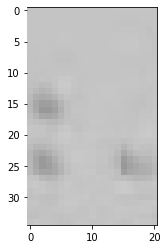

ind:  9
Prediction:  236


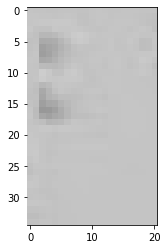

ind:  35
Prediction:  12


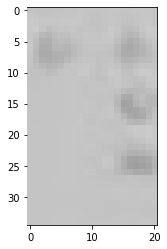

ind:  61
Prediction:  1456


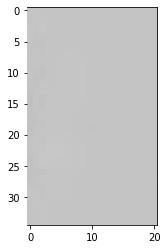

ind:  0
Prediction:  0


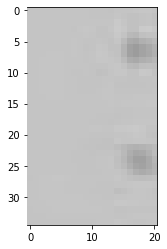

ind:  28
Prediction:  46


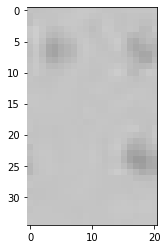

ind:  62
Prediction:  146


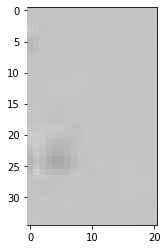

ind:  51
Prediction:  13


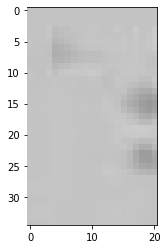

ind:  30
Prediction:  56


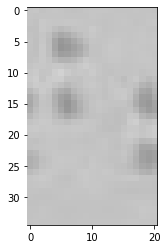

ind:  30
Prediction:  56


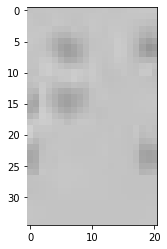

ind:  47
Prediction:  1246


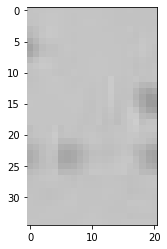

ind:  30
Prediction:  56


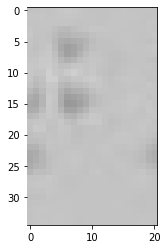

ind:  50
Prediction:  126


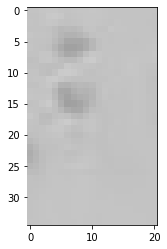

ind:  35
Prediction:  12


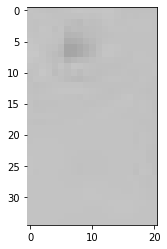

ind:  1
Prediction:  1


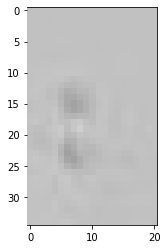

ind:  2
Prediction:  23


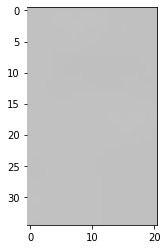

ind:  0
Prediction:  0


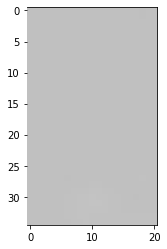

ind:  0
Prediction:  0


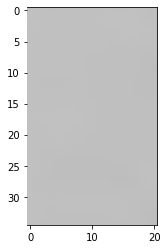

ind:  0
Prediction:  0


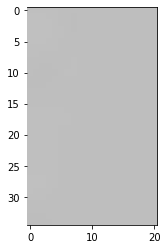

ind:  0
Prediction:  0


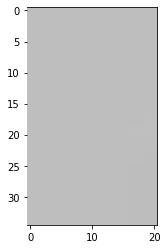

ind:  0
Prediction:  0


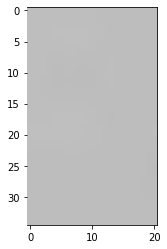

ind:  0
Prediction:  0


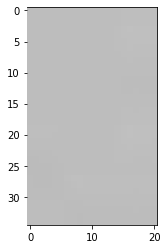

ind:  0
Prediction:  0


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

90


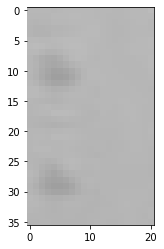

ind:  51
Prediction:  13


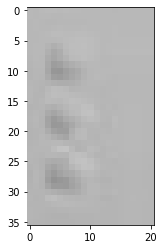

ind:  36
Prediction:  123


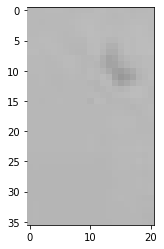

ind:  25
Prediction:  4


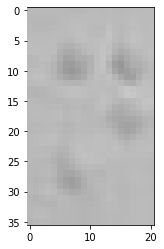

ind:  53
Prediction:  1345


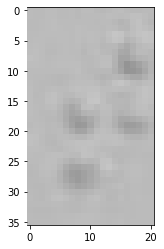

ind:  4
Prediction:  2345


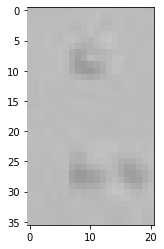

ind:  58
Prediction:  136


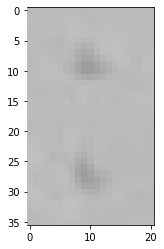

ind:  51
Prediction:  13


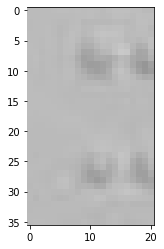

ind:  55
Prediction:  1346


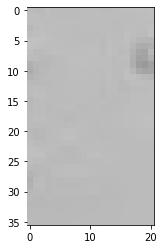

ind:  25
Prediction:  4


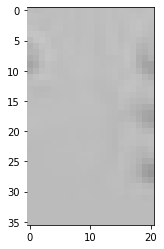

ind:  27
Prediction:  456


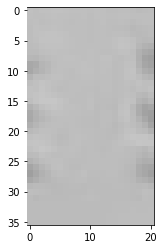

ind:  27
Prediction:  456


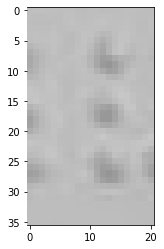

ind:  39
Prediction:  123456


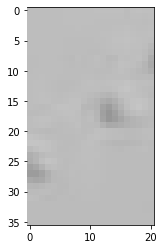

ind:  22
Prediction:  35


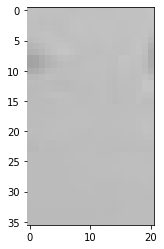

ind:  1
Prediction:  1


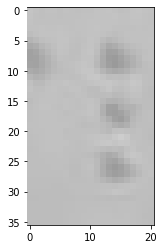

ind:  61
Prediction:  1456


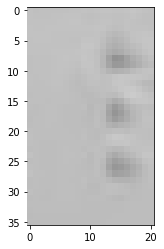

ind:  27
Prediction:  456


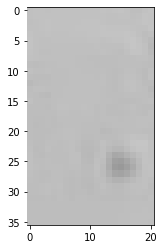

ind:  28
Prediction:  46


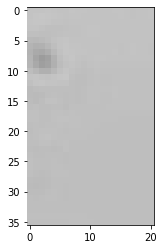

ind:  1
Prediction:  1


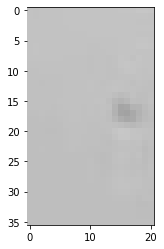

ind:  29
Prediction:  5


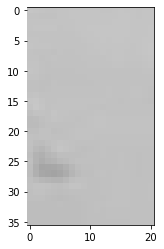

ind:  17
Prediction:  3


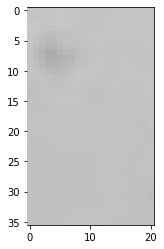

ind:  1
Prediction:  1


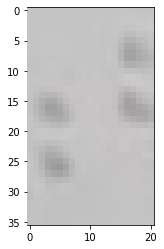

ind:  19
Prediction:  345


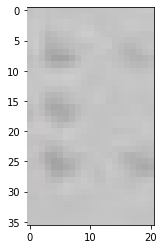

ind:  40
Prediction:  12346


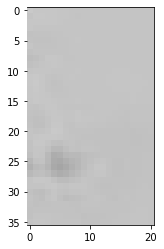

ind:  50
Prediction:  126


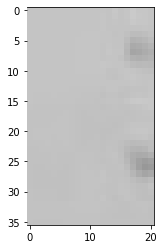

ind:  28
Prediction:  46


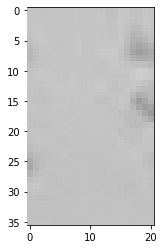

ind:  26
Prediction:  45


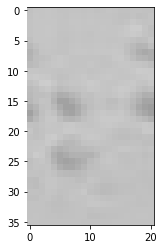

ind:  44
Prediction:  124


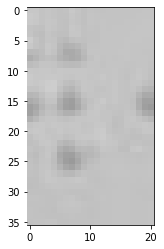

ind:  41
Prediction:  1235


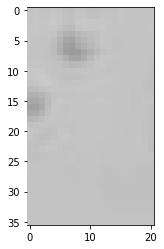

ind:  10
Prediction:  24


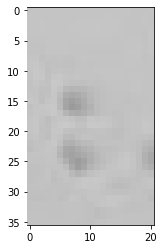

ind:  9
Prediction:  236


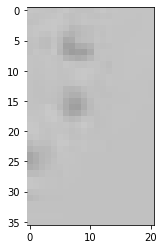

ind:  19
Prediction:  345


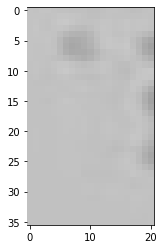

ind:  61
Prediction:  1456


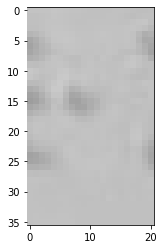

ind:  41
Prediction:  1235


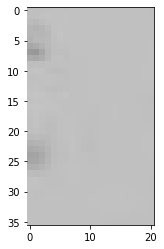

ind:  51
Prediction:  13


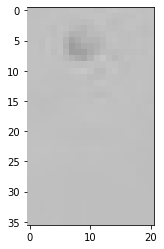

ind:  1
Prediction:  1


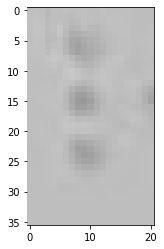

ind:  41
Prediction:  1235


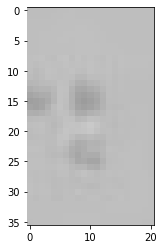

ind:  15
Prediction:  256


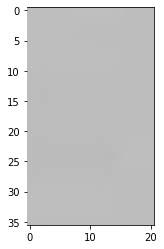

ind:  0
Prediction:  0


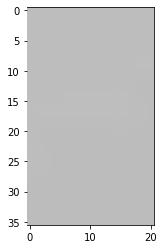

ind:  0
Prediction:  0


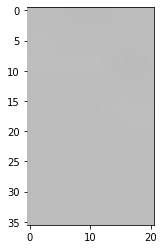

ind:  0
Prediction:  0
['1346', '1235', '235', '0', '1256', '1235', '35', '2', '1456', '0', '1346', '256', '136', '3', '1234', '2', '456', '456', '1235', '2', '146', '46', '56', '235', '123', '146', '2', '35', '1456', '246', '34', '256', '356', '56', '1246', '356', '23', '0', '0', '0', '1', '4', '1345', '2345', '0', '1234', '4', '456', '456', '35', '256', '35', '2', '1456', '0', '146', '1346', '34', '56', '356', '1246', '3', '46', '1', '256', '356', '3456', '23', '146', '2', '56', '46', '46', '345', '1456', '1456', '46', '3', '0', '0', '1234', '3456', '24', '4', '2345', '2345', '136', '456', '1236', '246', '1256', '236', '23', '1', '235', '23', '4', '1236', '34', '56', '0', '134', '24', '13', '1236', '136', '2456', '134', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1234', '136', '4', '2345', '2345', '35', '25', '345', '123', '24', '256', '45', '1', '146', '1256', '123', '456', '1', '16', '123', '1235', '1456', '1235', '1', '1456', '0', '1236', '1235', '4', '13', '13', '4', '25',

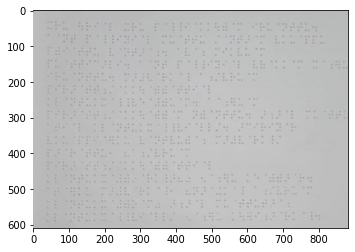

ஒர ஊரீ ஒ.உபளளரஶனலஶீஔஐ.ன   அந்த பள்ளீ.ஈ ஶொஐனஅ.ணஶனா  பணித்துளவௌஊஅவ்ஐன மிகவும          புத்தீஞாலி.அஶூலளஅலரரஅ வரக்கஞ்ளொஅதஷாருந்தது.ளௌள்லஅனைவருஅம           பிராததனாளகூனலனஹஅள    ஃ         ஃ  லலந்ஆஉஒஸளளேணஷஶே^ தாஶ           பிரணூதூகஶூண்ம்ஊலஶூன. ஆனாலஶததஅதோள்ஃளந்ஊகளளீளேஏஞஶல     வ்குப்பாஷ்ளைனஜலௌலவஅ        பார்த்துனைஅணௌஶல                   பாராத்தனாஅலகூணனனஹஅல  ஃ           கலந்துஒண்ஆஔளவனஞஅஷகன்ஊஹ    அதற்லு மாணவகஅரனஙறள்லன்ஹரும்    கலந்துகொண்ஶ ஶகனனனஅ       கலந்துகொள்ளீஅளஅஅஆஷரிஆரகஅர.  


In [21]:
tamil_text_output = make_prediction("tamil2.jpeg", "tamil")
print(tamil_text_output)

## MODULE 5: Text Correction

In [22]:
!sudo apt-get install swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (512 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

In [23]:
!sudo pip install jamspell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 4.3 MB/s 
  Created wheel for jamspell: filename=jamspell-0.0.12-cp37-cp37m-linux_x86_64.whl size=1347653 sha256=75e270ede48ba947d681a0f68e98584f3d4727d818caf543c6f7305766d62341
  Stored in directory: /root/.cache/pip/wheels/68/df/9c/9b335e69aa0f28e7f508ec0ebefadcc703f168beb52ae7ebe7
Successfully built jamspell


In [24]:
!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz

--2022-06-03 02:23:46--  https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz [following]
--2022-06-03 02:23:46--  https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36611828 (35M) [application/octet-stream]
Saving to: ‘en.tar.gz’

en.tar.gz           100%[===================>]  34.92M   115MB/s    in 0.3s    

2022-06-03 02:23:49 (115 MB/s) - ‘en.tar.gz’ saved [36611828/36611828]



In [25]:
!tar -xvf en.tar.gz

en.bin


In [26]:
import jamspell

In [27]:
jsp = jamspell.TSpellCorrector()
assert jsp.LoadLangModel('en.bin')

In [28]:
def preprocess_before_correction(text):
  new_str = list(text)
  for i in range(len(text)):
    if text[i] == "'":
      new_str[i] = " "
    elif not text[i].isalpha() and text[i] != '.' and text[i] != ' ' and text[i] != '-':
      if (i > 0 and text[i-1] != ' ') or ( i < len(text) - 1 and text[i+1] != ' '):
        new_str[i] = "e"
  return ''.join(new_str)

In [31]:
preprocessed = preprocess_before_correction(english_text_output)

In [32]:
corrected = jsp.FixFragment(preprocessed)

In [34]:
print(corrected)

Treesvare known es neurleeee    water filters and they uer este polluted               cc     They also add to the beezeyeie   nature gardens cannot lookbizh  without them                       trees help maIntain the ezlhfc balance felling of trees distursqheeco-system                 -           trees are called green-gold in the   earth and they are as valuable as gold we shouldEr our best plAnt more trees and preserve them as we can libwithozttiee                        


## MODULE 6: Text Summarization

In [36]:
pip install sumy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 10.1 MB 23.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21712 sha256=5b063bf67bceb3758f4c4f310c588d8c571b0cd1376e2c6b1b9125c8ff96fdba
  Stored in directory: /root/.cache/pip/wheels/d4/bf/51/81d27ad638e1a6dca4f362ecc33d1e2c764b8ea7ec751b8fc1
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=df86d7ee30250ef37addcbaac01e13ed00ba680d0afc339ae002cf3cbd199f4a
  Stored in directory: /root/.cache/pip/wheels/0e/06/e8/7ee176e95ea9a8a8c3b3afcb1869f20adbd42413d4611c6eb4
Successfully built breadability pycountry


In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
import sumy, nltk

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lsa import LsaSummarizer

In [38]:
print(corrected)

Treesvare known es neurleeee    water filters and they uer este polluted               cc     They also add to the beezeyeie   nature gardens cannot lookbizh  without them                       trees help maIntain the ezlhfc balance felling of trees distursqheeco-system                 -           trees are called green-gold in the   earth and they are as valuable as gold we shouldEr our best plAnt more trees and preserve them as we can libwithozttiee                        


In [43]:
summarizer_luhn = LuhnSummarizer()
parser = PlaintextParser.from_string(corrected, Tokenizer('english'))
summary_1 =summarizer_luhn(parser.document, 1)

In [44]:
luhn=""
for sentence in summary_1:
    luhn+=str(sentence)
luhn
print(summary_1)

(<Sentence: Treesvare known es neurleeee    water filters and they uer este polluted               cc     They also add to the beezeyeie   nature gardens cannot lookbizh  without them                       trees help maIntain the ezlhfc balance felling of trees distursqheeco-system                 -           trees are called green-gold in the   earth and they are as valuable as gold we shouldEr our best plAnt more trees and preserve them as we can libwithozttiee>,)


## MODULE 7: Text to Speech

In [46]:
pip install gtts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
from gtts import gTTS
import os

def text_to_audio(my_text, lang="en"):
  myobj = gTTS(text=my_text, lang=lang, slow=False)
  myobj.save("voice.mp3")
  os.system("voice.mp3")

In [48]:
text_to_audio(english_text_output)

In [49]:
text_to_audio(tamil_text_output, "ta")

## Performance Analysis

In [51]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 4.3 MB/s 
     |████████████████████████████████| 212 kB 35.6 MB/s 
     |████████████████████████████████| 140 kB 53.1 MB/s 
     |████████████████████████████████| 1.1 MB 48.9 MB/s 
     |████████████████████████████████| 86 kB 4.6 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 52.3 MB/s 
     |████████████████████████████████| 127 kB 29.3 MB/s 
     |████████████████████████████████| 271 kB 57.9 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 40.8 MB/s 
     |████████████████████████████████| 112 kB 66.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing ins

In [52]:
pip install jiwer jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.5 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149862 sha256=c6c17ea56709d3d9a56579233fc56b5ce0476076b4f2f1e841bbb2b9887d035c
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [53]:
from datasets import load_metric=
metric = load_metric("cer")

In [50]:
ref = "Trees are known as natural air and  water filters and they gaurd us against pollution.                             They also added to the beauty of the  nature. Gardens cannot look beautiful without them.                          Trees help to maintain the ecological balance. Felling of trees disturbs the eco-system.                      Trees are called green-gold in the   earth and they are as valuable as gold. We should try our best to plant more trees and preserve them as we can't live without them."

In [54]:
print(corrected)

Treesvare known es neurleeee    water filters and they uer este polluted               cc     They also add to the beezeyeie   nature gardens cannot lookbizh  without them                       trees help maIntain the ezlhfc balance felling of trees distursqheeco-system                 -           trees are called green-gold in the   earth and they are as valuable as gold we shouldEr our best plAnt more trees and preserve them as we can libwithozttiee                        


In [55]:
metric.add(prediction=corrected, reference=ref)

In [56]:
acc = 1 - metric.compute()
print(acc)

0.7837209302325582


In [57]:
pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
from Levenshtein import *

In [60]:
jaro(corrected,ref)

0.7757387479324739

In [61]:
jaro_winkler(corrected, ref)

0.887869373966237

In [62]:
tamil_ref = 'ஒரு ஊரில் ஒரு பள்ளிக்கூடம் இருந்தது. அந்த பள்ளியில் முத்து ஐந்தாம் வகுப்பு படித்து வந்தான். அவன் மிகவும் புத்திசாலி. அந்த பள்ளியில் வழக்கம் ஒன்று இருந்தது. மாணவர்கள் அனைவரும் பிராத்தனைக்  கூட்டத்தில் கலந்து கொள்ளவேண்டும். அன்றும் பிரார்த்தனைக் கூட்டம் நடந்தது. அனால் முத்து அதில் கலந்து கொள்ளவில்லை. ஆசிரியர் வகுப்பிற்கு வந்தவுடன் மாணவர்களை பார்த்து "அனைவரும் பிரார்த்தனைக் கூட்டத்தில் கலந்துகொண்டீர்களா?" என்று கேட்டார். அதற்கு மாணவர்கள், நாங்கள் அனைவரும் கலந்துகொண்டோம் அனால் முத்துதான் கலந்து கொள்ளவில்லை என்று கூறினார்கள்.'

In [63]:
metric = load_metric("cer")
metric.add(prediction=tamil_text_output, reference=tamil_ref)

In [64]:
print(1 - metric.compute())

0.4


In [65]:
jaro(tamil_text_output, tamil_ref)

0.5858610120536463

In [66]:
jaro_winkler(tamil_text_output, tamil_ref)

0.668688809642917

## Built Applications

### Web Application
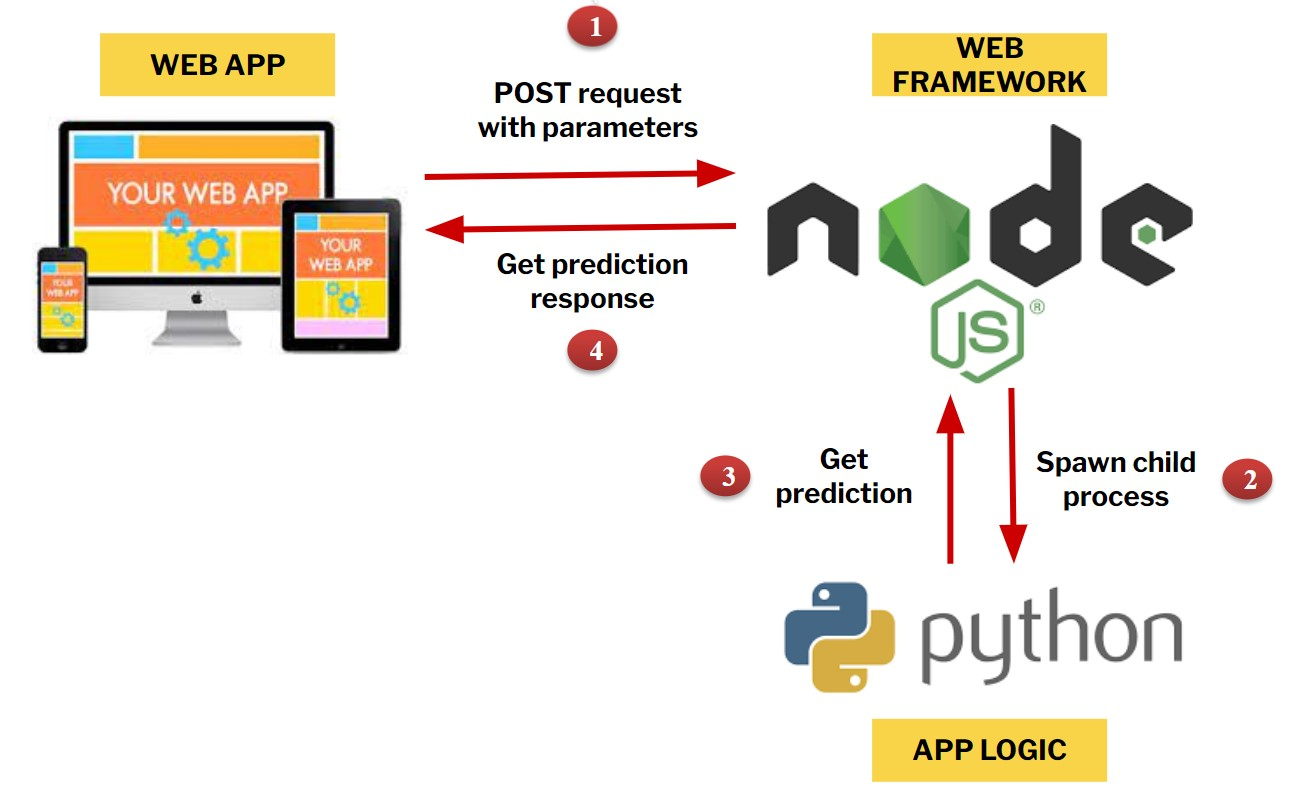

### API
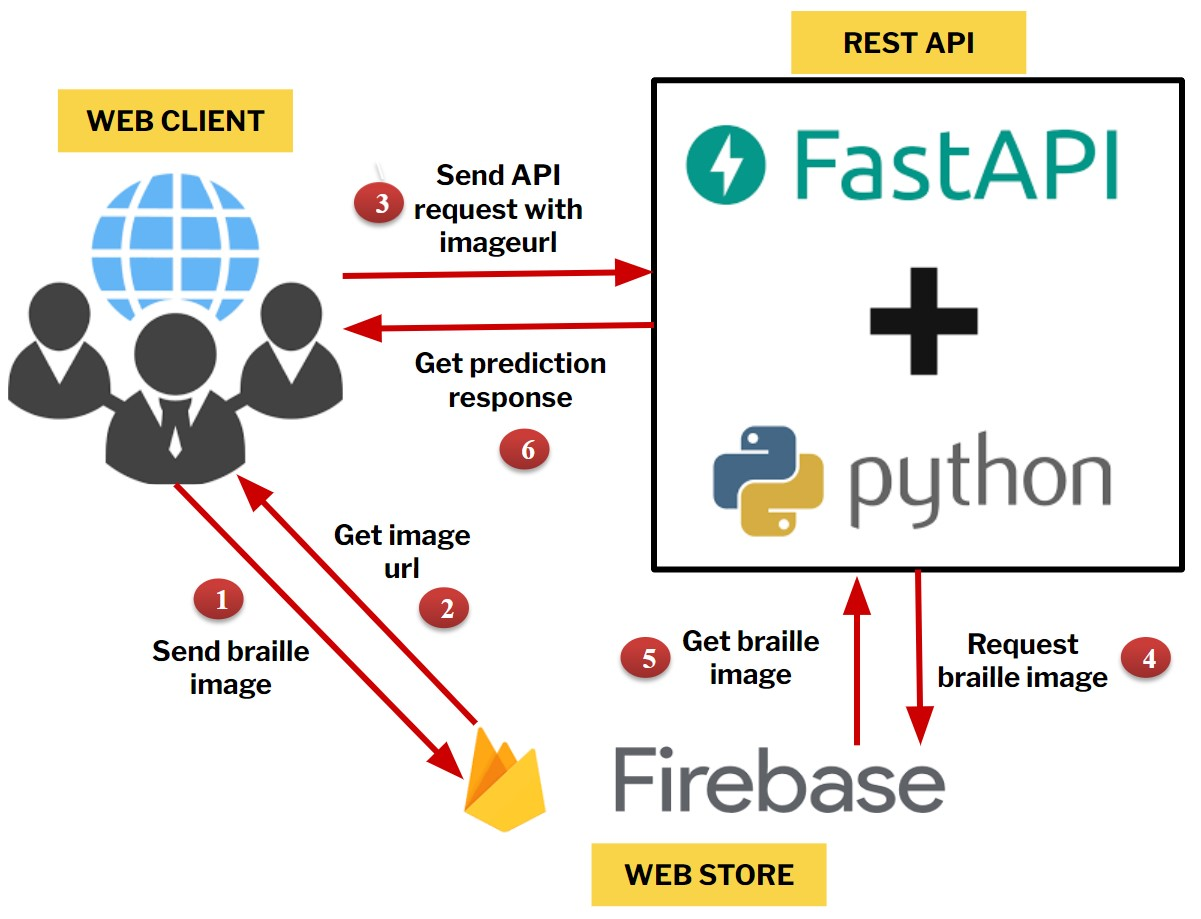

### Mobile Application
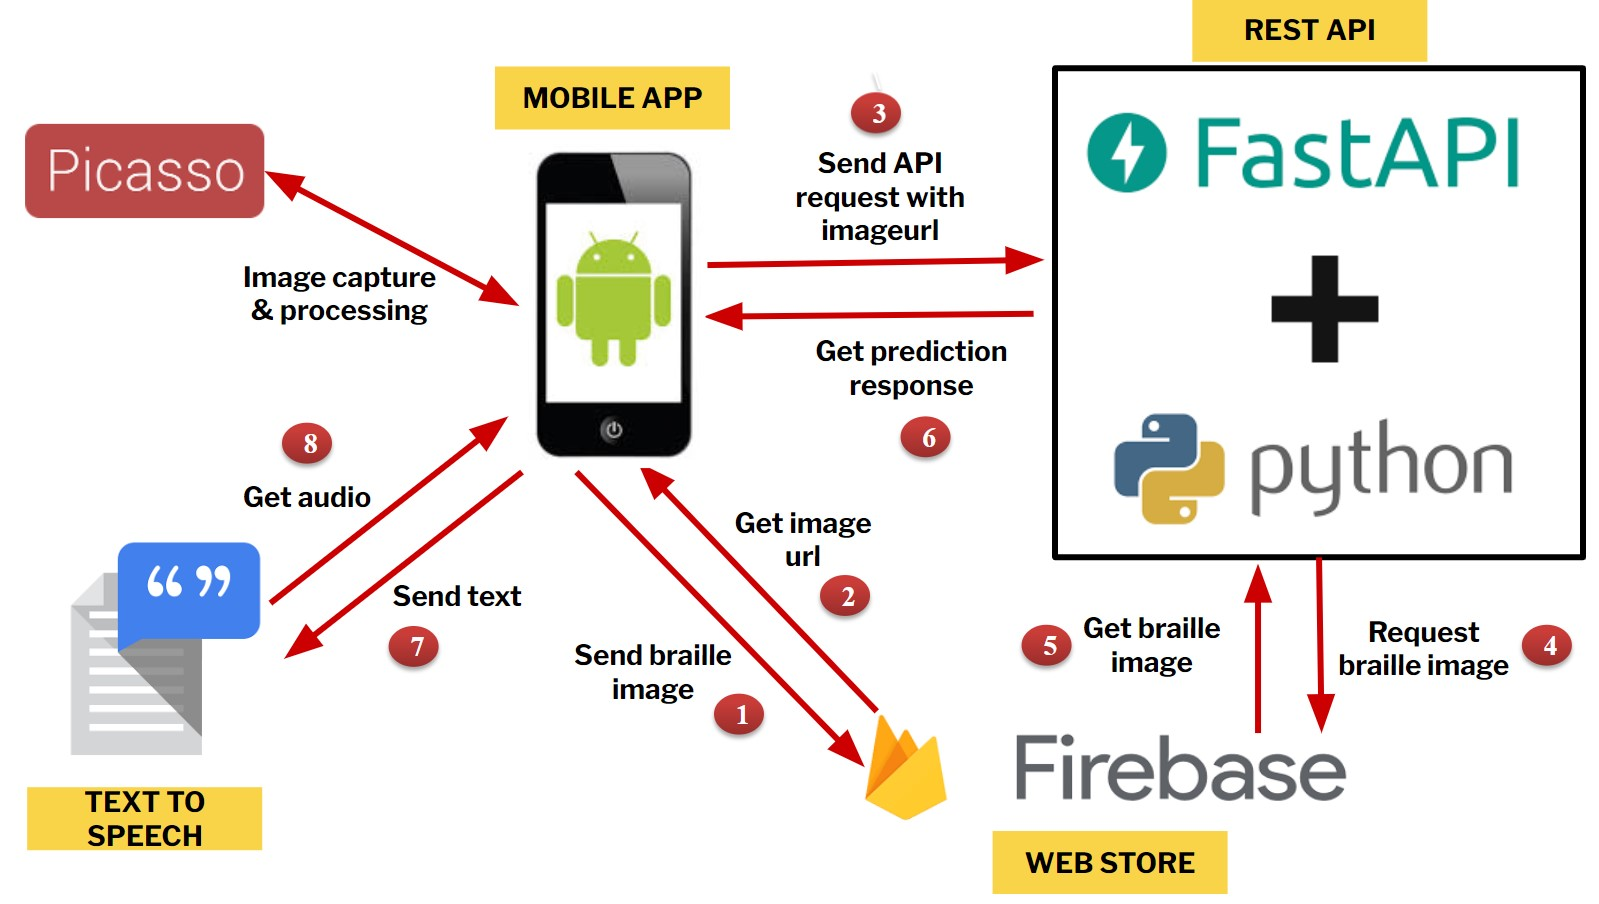